# Algorithmic trading 

Abstract


In [1]:
# %connect_info
%matplotlib inline
!git pull
import time
import datetime
import tqdm
import seaborn as sns
sns.set_theme()
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from notebooks.lambda_imports import *
# plt.style.use('seaborn')
start_notebook=time.time()

Already up to date.
PROJECT_PATH=E:\javif\Coding\Python\market_making_fw\python_lambda
LAMBDA_OUTPUT_PATH=X:\output_models
LAMBDA_TEMP_PATH=E:\javif\Coding\Python\market_making_fw\java\temp
BACKTEST_JAR_PATH(LAMBDA_JAR_PATH)=E:\javif\Coding\Python\market_making_fw\java\executables\Backtest\target\Backtest.jar
log_path(LAMBDA_LOGS_PATH)=X:\logs\250623
LAMBDA_DATA_PATH=X:\


# Index:
* [Configuration](#configuration)
* [Algorithms](#algorithms)
* [Parameter tuning](#parameter_tuning)
* [Training](#training)
* [Testing](#testing)
* [Results](#results)
  * [Ratios](#ratios)
    * [Sharpe](#sharpe)
* [Email](#email)

## Configuration<a class="anchor" id="configuration"></a>

In [2]:
NAME = "AlphaAvellanedaStoikov"
HEDGE=True

PARAMETER_TUNING=False
TRAINING=True
TESTING=True

DEBUG=False
instrument_pk='btceur_kraken'
hedge_instrument_pks=["etheur_kraken"]

QUANTITY=0.01
FIRST_HOUR=7.0
LAST_HOUR=19.0
Algorithm.DELAY_MS=0#65 ms of slippage
Algorithm.FEES_COMMISSIONS_INCLUDED=False
Algorithm.MULTITHREAD_CONFIGURATION = MultiThreadConfiguration.singlethread#singlethread

stop_action_on_filled = False
seed_number=int(28220)
np.random.seed(seed_number)
import random
random.seed(seed_number)

if DEBUG:
    print("DEBUG")
    NAME+="_debug"
    FIRST_HOUR=13
    LAST_HOUR=17

In [3]:
def get_n_days_before(reference_date: datetime, n: int):
    days = []
    current_date = reference_date
    while len(days) < n:
        current_date -= datetime.timedelta(days=1)
        if current_date.weekday() < 5:  # Monday to Friday are 0 to 4
            days.append(current_date)
    return days
days_test = 30
if DEBUG:
    days_test=5
start_date_experiment=datetime.datetime(year=2025,month=6,day=9)
days_backtest = get_n_days_before(start_date_experiment,days_test)

day_train=days_backtest[0]
days_backtest.remove(day_train)

## Hedge<a class="anchor" id="hedge"></a>

In [4]:
if HEDGE:
    synthetic_instrument_file = rf"{LAMBDA_INPUT_PATH}/MarketMakingHedge/{NAME}_{instrument_pk}_betas.json"
    regression_price_type = RegressionPriceType.returns
    
    statarb_instrument = StatArbInstrument(
    main_instrument=instrument_pk, list_instruments=hedge_instrument_pks, regression_price_type=regression_price_type
    )
    
    resolution = CandleTimeResolution.SECOND

    bestResolution = 'S'  #MIN , S
    bestNumUnitsCandles = 30
    bestPeriod = 15    
    test_size = 0.05
    print(f"bestConfig:{bestNumUnitsCandles} {bestResolution}   period:{bestPeriod}")
    
    statarb_instrument.get_pair_summaries(start_date=day_train,
                                          end_date=day_train,
                                          resolutions=[bestResolution],
                                          candle_type=CandleType.CANDLE_MIDPRICE_TIME,
                                          num_units=[bestNumUnitsCandles], spread_quantile=0.5,
                                          save_best_path=synthetic_instrument_file,
                                          test_size=test_size
                                          )
else:
    synthetic_instrument_file = ""


bestConfig:30 S   period:15
{
    "etheur_kraken": 0.26707029342651367,
    "half_life": 0.6614145539308061,
    "period": 1,
    "half_life_seconds": 19.842436617924182,
    "mean": 5.37715108984288e-13,
    "std": 0.0002341346989851445,
    "intercept": 8.101480489131063e-06,
    "seconds_candles": 30,
    "regression_price_type": "Returns"
} -> best candles 30 seconds half_life 0.6614145539308061 candles resolution S into X:\input_models/MarketMakingHedge/AlphaAvellanedaStoikov_btceur_kraken_betas.json


## Algorithms<a class="anchor" id="algorithms"></a>

In [5]:
algorithms_list = []
algorithm_info_to_algo={}
algorithms_parameter_tuning_max = {}#algorithm to parameters
algorithms_parameter_tuning_min = {}#algorithm to parameters
algorithms_parameter_tuning_link={}#parameter tuning algo to is linked results
algorithms_train_list = []
algorithms_benchmark = []

In [6]:
# ConstantSpread
parameters_default = {
    ConstantSpreadParameters.quantity_limit: (QUANTITY*10),
    AlgorithmParameters.quantity: (QUANTITY),
    AlgorithmParameters.first_hour: (FIRST_HOUR),
    AlgorithmParameters.last_hour: (LAST_HOUR),
    AlgorithmParameters.seed : seed_number,
    ConstantSpreadParameters.level:(1),
    AlgorithmParameters.synthetic_instrument_file:synthetic_instrument_file
}
algorithm_info_constant='benchmark'
constant_spread_10 = ConstantSpread(algorithm_info=algorithm_info_constant,parameters=parameters_default)
print(f'{constant_spread_10.algorithm_info} with params {constant_spread_10.parameters}')

algorithm_info_to_algo[constant_spread_10.algorithm_info] = constant_spread_10
algorithms_list.append(constant_spread_10)
algorithms_benchmark.append(constant_spread_10)

ConstantSpread_benchmark with params {'quantityLimit': 0.1, 'quantity': 0.01, 'firstHour': 7.0, 'lastHour': 19.0, 'seed': 28220, 'level': 1, 'syntheticInstrumentFile': 'X:\\input_models/MarketMakingHedge/AlphaAvellanedaStoikov_btceur_kraken_betas.json', 'ui': 0, 'skewLevel': 0, 'minQuantityFollow': 0}


In [7]:
# LinearConstantSpread
parameters_default = {
    LinearConstantSpreadParameters.quantity_limit: (QUANTITY*10),
    AlgorithmParameters.quantity: (QUANTITY),
    AlgorithmParameters.first_hour: (FIRST_HOUR),
    AlgorithmParameters.last_hour: (LAST_HOUR),
    AlgorithmParameters.seed : seed_number,
    LinearConstantSpreadParameters.level:(1),
    AlgorithmParameters.synthetic_instrument_file:synthetic_instrument_file
}

algorithm_info_linear_constant='benchmark'
linear_constant_spread = LinearConstantSpread(algorithm_info=algorithm_info_linear_constant,parameters=parameters_default)
print(f'{linear_constant_spread.algorithm_info} with params {linear_constant_spread.parameters}')

algorithm_info_to_algo[linear_constant_spread.algorithm_info] = linear_constant_spread
algorithms_list.append(linear_constant_spread)
algorithms_benchmark.append(linear_constant_spread)

LinearConstantSpread_benchmark with params {'quantityLimit': 0.1, 'quantity': 0.01, 'firstHour': 7.0, 'lastHour': 19.0, 'seed': 28220, 'level': 1, 'syntheticInstrumentFile': 'X:\\input_models/MarketMakingHedge/AlphaAvellanedaStoikov_btceur_kraken_betas.json'}


In [8]:
# AvellanedaStoikov
avellaneda_stoikov_parameters_default = {
    # Avellaneda default
    AvellanedaStoikovParameters.risk_aversion: (0.9),
    AvellanedaStoikovParameters.midprice_period_seconds: (60),
    AvellanedaStoikovParameters.seconds_change_k:(60),
    AlgorithmParameters.quantity: (QUANTITY),
    AlgorithmParameters.first_hour: (FIRST_HOUR),
    AlgorithmParameters.last_hour: (LAST_HOUR),
    AlgorithmParameters.seed : seed_number,
    AvellanedaStoikovParameters.k_calculation: KCalculationEnum.Pct,
    AvellanedaStoikovParameters.spread_calculation:SpreadCalculationEnum.Avellaneda,
    AvellanedaStoikovParameters.calculate_Tt:0,
    AlgorithmParameters.synthetic_instrument_file:synthetic_instrument_file
}


algorithm_info_as='benchmark'
avellaneda_stoikov = AvellanedaStoikov(algorithm_info=algorithm_info_as,parameters=avellaneda_stoikov_parameters_default)
print(f'{avellaneda_stoikov.algorithm_info} with params {avellaneda_stoikov.parameters}')

algorithms_parameter_tuning_min[avellaneda_stoikov] = {AvellanedaStoikovParameters.risk_aversion:0.0001,AvellanedaStoikovParameters.midprice_period_window:5,AvellanedaStoikovParameters.midprice_period_seconds:3, AvellanedaStoikovParameters.seconds_change_k:60,}
algorithms_parameter_tuning_max[avellaneda_stoikov] =  {AvellanedaStoikovParameters.risk_aversion:0.9, AvellanedaStoikovParameters.midprice_period_window:120,AvellanedaStoikovParameters.midprice_period_seconds:60, AvellanedaStoikovParameters.seconds_change_k:60*10}
algorithm_info_to_algo[avellaneda_stoikov.algorithm_info] = avellaneda_stoikov
algorithms_list.append(avellaneda_stoikov)
algorithms_benchmark.append(avellaneda_stoikov)

AvellanedaStoikov_benchmark with params {'riskAversion': 0.9, 'midpricePeriodSeconds': 60, 'changeKPeriodSeconds': 60, 'quantity': 0.01, 'firstHour': 7.0, 'lastHour': 19.0, 'seed': 28220, 'kCalculation': 'Pct', 'spreadCalculation': 'Avellaneda', 'calculateTt': 0, 'syntheticInstrumentFile': 'X:\\input_models/MarketMakingHedge/AlphaAvellanedaStoikov_btceur_kraken_betas.json', 'skew': 0, 'midpricePeriodWindow': 15, 'ui': 0, 'kDefault': -1, 'aDefault': -1, 'sigmaDefault': -1, 'positionMultiplier': 1.0, 'spreadMultiplier': 1.0}


In [9]:
## rl configuration
rl_step_seconds=5
rl_reward_function = ScoreEnum.asymmetric_dampened_pnl
rl_port= 666




rl_max_batch_size=100000
rl_batch_size=1024
rl_epoch=150
rl_exploration_prob=0.2
rl_learning_rate = 0.01
rl_discount_factor=0.85

horizon_ticks_private_state=5
horizon_ticks_market_state=15
horizon_candles_state=5
horizon_min_ms_tick=1


In [10]:
# AlphaAvellanedaStoikov DQN
rl_action_type= ReinforcementLearningActionType.discrete
rl_model = BaseModelType.DQN

most_significant_state_columns=[]
parameters_default = {
    AlgorithmParameters.quantity: (QUANTITY),
    AlgorithmParameters.first_hour: (FIRST_HOUR),
    AlgorithmParameters.last_hour: (LAST_HOUR),
    AlgorithmParameters.seed : seed_number,
    AlgorithmParameters.synthetic_instrument_file:synthetic_instrument_file,
    
    # ACTIONS -> will define later
#     AlphaAvellanedaAlgorithmParameters.skew_action: [],
#     AlphaAvellanedaAlgorithmParameters.risk_aversion_action: [],
#     AlphaAvellanedaAlgorithmParameters.midprice_period_window_action: [],
#     AlphaAvellanedaAlgorithmParameters.change_k_period_seconds_action: [],

    #STATES
    RlAlgorithmParameters.horizon_ticks_private_state: (horizon_ticks_private_state),
    RlAlgorithmParameters.horizon_ticks_market_state: (horizon_ticks_market_state),
    RlAlgorithmParameters.horizon_candles_state: (horizon_candles_state),
    RlAlgorithmParameters.horizon_min_ms_tick: horizon_min_ms_tick,

    RlAlgorithmParameters.state_filter: most_significant_state_columns,
    
    #REWARD
    RlAlgorithmParameters.score: rl_reward_function,
    RlAlgorithmParameters.step_seconds: (rl_step_seconds),
    
    #LEARNING CONFIG
    RlAlgorithmParameters.rl_port: rl_port,
    RlAlgorithmParameters.action_type: rl_action_type,
    RlAlgorithmParameters.model: rl_model,
    
    RlAlgorithmParameters.exploration_probability: rl_exploration_prob,  # probability of explore=> random action
    RlAlgorithmParameters.discount_factor: rl_discount_factor,  # next state prediction reward discount new values reward multiplier
    RlAlgorithmParameters.learning_rate_nn: rl_learning_rate,#on nn
    #DQN
    RlAlgorithmParameters.max_batch_size: rl_max_batch_size,
    RlAlgorithmParameters.batch_size: rl_batch_size,
    RlAlgorithmParameters.training_predict_iteration_period: IterationsPeriodTime.TWO_HOURS,  # train only at the end,offline
    RlAlgorithmParameters.training_target_iteration_period: IterationsPeriodTime.FOUR_HOURS,  # train at the end,offline
    RlAlgorithmParameters.epoch: rl_epoch,
    RlAlgorithmParameters.stop_action_on_filled: stop_action_on_filled,
}


rl_port+=1

algorithm_info_alpha_as=rf'{rl_model}_{rl_action_type}'
alpha_avellaneda_stoikov = AlphaAvellanedaStoikov(algorithm_info=algorithm_info_alpha_as,parameters=parameters_default)
alpha_avellaneda_stoikov.set_parameters(avellaneda_stoikov_parameters_default)
print(f'{alpha_avellaneda_stoikov.algorithm_info} with params {alpha_avellaneda_stoikov.parameters}')

algorithm_info_to_algo[alpha_avellaneda_stoikov.algorithm_info] = alpha_avellaneda_stoikov
algorithms_train_list.append(alpha_avellaneda_stoikov)
algorithms_list.append(alpha_avellaneda_stoikov)


list_linked = algorithms_parameter_tuning_link.get(avellaneda_stoikov,[])
list_linked.append(alpha_avellaneda_stoikov)
algorithms_parameter_tuning_link[avellaneda_stoikov] = list_linked

states(PYTHON) [185] : inventory_4,inventory_3,inventory_2,inventory_1,inventory_0,unrealized_4,unrealized_3,unrealized_2,unrealized_1,unrealized_0,realized_4,realized_3,realized_2,realized_1,realized_0,minutesToFinish,market_bid_price_14,market_bid_price_13,market_bid_price_12,market_bid_price_11,market_bid_price_10,market_bid_price_9,market_bid_price_8,market_bid_price_7,market_bid_price_6,market_bid_price_5,market_bid_price_4,market_bid_price_3,market_bid_price_2,market_bid_price_1,market_bid_price_0,market_ask_price_14,market_ask_price_13,market_ask_price_12,market_ask_price_11,market_ask_price_10,market_ask_price_9,market_ask_price_8,market_ask_price_7,market_ask_price_6,market_ask_price_5,market_ask_price_4,market_ask_price_3,market_ask_price_2,market_ask_price_1,market_ask_price_0,market_bid_qty_14,market_bid_qty_13,market_bid_qty_12,market_bid_qty_11,market_bid_qty_10,market_bid_qty_9,market_bid_qty_8,market_bid_qty_7,market_bid_qty_6,market_bid_qty_5,market_bid_qty_4,market_bi

In [11]:
# # AlphaAvellanedaStoikov SAC
# rl_action_type= ReinforcementLearningActionType.continuous
# rl_model = BaseModelType.SAC

# most_significant_state_columns=[]
# parameters_default = {
#     AlgorithmParameters.quantity: (QUANTITY),
#     AlgorithmParameters.first_hour: (FIRST_HOUR),
#     AlgorithmParameters.last_hour: (LAST_HOUR),
#     AlgorithmParameters.seed : seed_number,
# AlgorithmParameters.synthetic_instrument_file:synthetic_instrument_file,
    
#     # ACTIONS -> will define later
# #     AlphaAvellanedaAlgorithmParameters.skew_action: [],
# #     AlphaAvellanedaAlgorithmParameters.risk_aversion_action: [],
# #     AlphaAvellanedaAlgorithmParameters.midprice_period_window_action: [],
# #     AlphaAvellanedaAlgorithmParameters.change_k_period_seconds_action: [],

#     #STATES
#     RlAlgorithmParameters.horizon_ticks_private_state: (horizon_ticks_private_state),
#     RlAlgorithmParameters.horizon_ticks_market_state: (horizon_ticks_market_state),
#     RlAlgorithmParameters.horizon_candles_state: (horizon_candles_state),
#     RlAlgorithmParameters.horizon_min_ms_tick: horizon_min_ms_tick,

#     RlAlgorithmParameters.state_filter: most_significant_state_columns,
    
#     #REWARD
#     RlAlgorithmParameters.score: rl_reward_function,
#     RlAlgorithmParameters.step_seconds: (rl_step_seconds),
    
#     #LEARNING CONFIG
#     RlAlgorithmParameters.rl_port: rl_port,
#     RlAlgorithmParameters.action_type: rl_action_type,
#     RlAlgorithmParameters.model: rl_model,
    
#     RlAlgorithmParameters.exploration_probability: rl_exploration_prob,  # probability of explore=> random action
#     RlAlgorithmParameters.discount_factor: rl_discount_factor,  # next state prediction reward discount new values reward multiplier
#     RlAlgorithmParameters.learning_rate_nn: rl_learning_rate,#on nn
#     #DQN
#     RlAlgorithmParameters.max_batch_size: rl_max_batch_size,
#     RlAlgorithmParameters.batch_size: rl_batch_size,
#     RlAlgorithmParameters.training_predict_iteration_period: IterationsPeriodTime.TWO_HOURS,  # train only at the end,offline
#     RlAlgorithmParameters.training_target_iteration_period: IterationsPeriodTime.FOUR_HOURS,  # train at the end,offline
#     RlAlgorithmParameters.epoch: rl_epoch,
#     RlAlgorithmParameters.stop_action_on_filled: stop_action_on_filled
# }


# rl_port+=1

# algorithm_info_alpha_as=rf'{rl_model}_{rl_action_type}'
# alpha_avellaneda_stoikov = AlphaAvellanedaStoikov(algorithm_info=algorithm_info_alpha_as,parameters=parameters_default)
# alpha_avellaneda_stoikov.set_parameters(avellaneda_stoikov_parameters_default)
# print(f'{alpha_avellaneda_stoikov.algorithm_info} with params {alpha_avellaneda_stoikov.parameters}')

# algorithm_info_to_algo[alpha_avellaneda_stoikov.algorithm_info] = alpha_avellaneda_stoikov
# algorithms_train_list.append(alpha_avellaneda_stoikov)
# algorithms_list.append(alpha_avellaneda_stoikov)


# list_linked = algorithms_parameter_tuning_link.get(avellaneda_stoikov,[])
# list_linked.append(alpha_avellaneda_stoikov)
# algorithms_parameter_tuning_link[avellaneda_stoikov] = list_linked

In [12]:
# AlphaAvellanedaStoikov PPO contin
rl_action_type= ReinforcementLearningActionType.continuous
rl_model = BaseModelType.PPO

most_significant_state_columns=[]
parameters_default = {
    AlgorithmParameters.quantity: (QUANTITY),
    AlgorithmParameters.first_hour: (FIRST_HOUR),
    AlgorithmParameters.last_hour: (LAST_HOUR),
    AlgorithmParameters.seed : seed_number,
    AlgorithmParameters.synthetic_instrument_file:synthetic_instrument_file,
    
    # ACTIONS -> will define later
#     AlphaAvellanedaAlgorithmParameters.skew_action: [],
#     AlphaAvellanedaAlgorithmParameters.risk_aversion_action: [],
#     AlphaAvellanedaAlgorithmParameters.midprice_period_window_action: [],
#     AlphaAvellanedaAlgorithmParameters.change_k_period_seconds_action: [],

    #STATES
    RlAlgorithmParameters.horizon_ticks_private_state: (horizon_ticks_private_state),
    RlAlgorithmParameters.horizon_ticks_market_state: (horizon_ticks_market_state),
    RlAlgorithmParameters.horizon_candles_state: (horizon_candles_state),
    RlAlgorithmParameters.horizon_min_ms_tick: horizon_min_ms_tick,

    RlAlgorithmParameters.state_filter: most_significant_state_columns,
    
    #REWARD
    RlAlgorithmParameters.score: rl_reward_function,
    RlAlgorithmParameters.step_seconds: (rl_step_seconds),
    
    #LEARNING CONFIG
    RlAlgorithmParameters.rl_port: rl_port,
    RlAlgorithmParameters.action_type: rl_action_type,
    RlAlgorithmParameters.model: rl_model,
    
    RlAlgorithmParameters.exploration_probability: rl_exploration_prob,  # probability of explore=> random action
    RlAlgorithmParameters.discount_factor: rl_discount_factor,  # next state prediction reward discount new values reward multiplier
    RlAlgorithmParameters.learning_rate_nn: rl_learning_rate,#on nn
    #DQN
    RlAlgorithmParameters.max_batch_size: rl_max_batch_size,
    RlAlgorithmParameters.batch_size: rl_batch_size,
    RlAlgorithmParameters.training_predict_iteration_period: IterationsPeriodTime.TWO_HOURS,  # train only at the end,offline
    RlAlgorithmParameters.training_target_iteration_period: IterationsPeriodTime.FOUR_HOURS,  # train at the end,offline
    RlAlgorithmParameters.epoch: rl_epoch,
    RlAlgorithmParameters.stop_action_on_filled: stop_action_on_filled,
}


rl_port+=1

algorithm_info_alpha_as=rf'{rl_model}_{rl_action_type}'
alpha_avellaneda_stoikov = AlphaAvellanedaStoikov(algorithm_info=algorithm_info_alpha_as,parameters=parameters_default)
alpha_avellaneda_stoikov.set_parameters(avellaneda_stoikov_parameters_default)
print(f'{alpha_avellaneda_stoikov.algorithm_info} with params {alpha_avellaneda_stoikov.parameters}')

algorithm_info_to_algo[alpha_avellaneda_stoikov.algorithm_info] = alpha_avellaneda_stoikov
algorithms_train_list.append(alpha_avellaneda_stoikov)
algorithms_list.append(alpha_avellaneda_stoikov)


list_linked = algorithms_parameter_tuning_link.get(avellaneda_stoikov,[])
list_linked.append(alpha_avellaneda_stoikov)
algorithms_parameter_tuning_link[avellaneda_stoikov] = list_linked

states(PYTHON) [185] : inventory_4,inventory_3,inventory_2,inventory_1,inventory_0,unrealized_4,unrealized_3,unrealized_2,unrealized_1,unrealized_0,realized_4,realized_3,realized_2,realized_1,realized_0,minutesToFinish,market_bid_price_14,market_bid_price_13,market_bid_price_12,market_bid_price_11,market_bid_price_10,market_bid_price_9,market_bid_price_8,market_bid_price_7,market_bid_price_6,market_bid_price_5,market_bid_price_4,market_bid_price_3,market_bid_price_2,market_bid_price_1,market_bid_price_0,market_ask_price_14,market_ask_price_13,market_ask_price_12,market_ask_price_11,market_ask_price_10,market_ask_price_9,market_ask_price_8,market_ask_price_7,market_ask_price_6,market_ask_price_5,market_ask_price_4,market_ask_price_3,market_ask_price_2,market_ask_price_1,market_ask_price_0,market_bid_qty_14,market_bid_qty_13,market_bid_qty_12,market_bid_qty_11,market_bid_qty_10,market_bid_qty_9,market_bid_qty_8,market_bid_qty_7,market_bid_qty_6,market_bid_qty_5,market_bid_qty_4,market_bi

In [13]:
# AlphaAvellanedaStoikov PPO discrete
rl_action_type= ReinforcementLearningActionType.discrete
rl_model = BaseModelType.PPO

most_significant_state_columns=[]
parameters_default = {
    AlgorithmParameters.quantity: (QUANTITY),
    AlgorithmParameters.first_hour: (FIRST_HOUR),
    AlgorithmParameters.last_hour: (LAST_HOUR),
    AlgorithmParameters.seed : seed_number,
    AlgorithmParameters.synthetic_instrument_file:synthetic_instrument_file,
    
    # ACTIONS -> will define later
#     AlphaAvellanedaAlgorithmParameters.skew_action: [],
#     AlphaAvellanedaAlgorithmParameters.risk_aversion_action: [],
#     AlphaAvellanedaAlgorithmParameters.midprice_period_window_action: [],
#     AlphaAvellanedaAlgorithmParameters.change_k_period_seconds_action: [],

    #STATES
    RlAlgorithmParameters.horizon_ticks_private_state: (horizon_ticks_private_state),
    RlAlgorithmParameters.horizon_ticks_market_state: (horizon_ticks_market_state),
    RlAlgorithmParameters.horizon_candles_state: (horizon_candles_state),
    RlAlgorithmParameters.horizon_min_ms_tick: horizon_min_ms_tick,

    RlAlgorithmParameters.state_filter: most_significant_state_columns,
    
    #REWARD
    RlAlgorithmParameters.score: rl_reward_function,
    RlAlgorithmParameters.step_seconds: (rl_step_seconds),
    
    #LEARNING CONFIG
    RlAlgorithmParameters.rl_port: rl_port,
    RlAlgorithmParameters.action_type: rl_action_type,
    RlAlgorithmParameters.model: rl_model,
    
    RlAlgorithmParameters.exploration_probability: rl_exploration_prob,  # probability of explore=> random action
    RlAlgorithmParameters.discount_factor: rl_discount_factor,  # next state prediction reward discount new values reward multiplier
    RlAlgorithmParameters.learning_rate_nn: rl_learning_rate,#on nn
    #DQN
    RlAlgorithmParameters.max_batch_size: rl_max_batch_size,
    RlAlgorithmParameters.batch_size: rl_batch_size,
    RlAlgorithmParameters.training_predict_iteration_period: IterationsPeriodTime.TWO_HOURS,  # train only at the end,offline
    RlAlgorithmParameters.training_target_iteration_period: IterationsPeriodTime.FOUR_HOURS,  # train at the end,offline
    RlAlgorithmParameters.epoch: rl_epoch,
    RlAlgorithmParameters.stop_action_on_filled: stop_action_on_filled,
}


rl_port+=1

algorithm_info_alpha_as=rf'{rl_model}_{rl_action_type}'
alpha_avellaneda_stoikov = AlphaAvellanedaStoikov(algorithm_info=algorithm_info_alpha_as,parameters=parameters_default)
alpha_avellaneda_stoikov.set_parameters(avellaneda_stoikov_parameters_default)
print(f'{alpha_avellaneda_stoikov.algorithm_info} with params {alpha_avellaneda_stoikov.parameters}')

algorithm_info_to_algo[alpha_avellaneda_stoikov.algorithm_info] = alpha_avellaneda_stoikov
algorithms_train_list.append(alpha_avellaneda_stoikov)
algorithms_list.append(alpha_avellaneda_stoikov)


list_linked = algorithms_parameter_tuning_link.get(avellaneda_stoikov,[])
list_linked.append(alpha_avellaneda_stoikov)
algorithms_parameter_tuning_link[avellaneda_stoikov] = list_linked

states(PYTHON) [185] : inventory_4,inventory_3,inventory_2,inventory_1,inventory_0,unrealized_4,unrealized_3,unrealized_2,unrealized_1,unrealized_0,realized_4,realized_3,realized_2,realized_1,realized_0,minutesToFinish,market_bid_price_14,market_bid_price_13,market_bid_price_12,market_bid_price_11,market_bid_price_10,market_bid_price_9,market_bid_price_8,market_bid_price_7,market_bid_price_6,market_bid_price_5,market_bid_price_4,market_bid_price_3,market_bid_price_2,market_bid_price_1,market_bid_price_0,market_ask_price_14,market_ask_price_13,market_ask_price_12,market_ask_price_11,market_ask_price_10,market_ask_price_9,market_ask_price_8,market_ask_price_7,market_ask_price_6,market_ask_price_5,market_ask_price_4,market_ask_price_3,market_ask_price_2,market_ask_price_1,market_ask_price_0,market_bid_qty_14,market_bid_qty_13,market_bid_qty_12,market_bid_qty_11,market_bid_qty_10,market_bid_qty_9,market_bid_qty_8,market_bid_qty_7,market_bid_qty_6,market_bid_qty_5,market_bid_qty_4,market_bi

In [14]:
# AlphaConstantSpread
rl_action_type= ReinforcementLearningActionType.discrete
rl_model = BaseModelType.DQN

most_significant_state_columns=[]
parameters_default = {
    AlgorithmParameters.quantity: (QUANTITY),
    AlgorithmParameters.first_hour: (FIRST_HOUR),
    AlgorithmParameters.last_hour: (LAST_HOUR),
    AlgorithmParameters.seed : seed_number,
    AlgorithmParameters.synthetic_instrument_file:synthetic_instrument_file,
    
    # ACTIONS
    AlphaConstantSpreadParameters.level_action:[0,1,2],
    AlphaConstantSpreadParameters.skew_level_action:[-2,-1,0,1,2],

    #STATES
    RlAlgorithmParameters.horizon_ticks_private_state: (horizon_ticks_private_state),
    RlAlgorithmParameters.horizon_ticks_market_state: (horizon_ticks_market_state),
    RlAlgorithmParameters.horizon_candles_state: (horizon_candles_state),
    RlAlgorithmParameters.horizon_min_ms_tick: horizon_min_ms_tick,

    RlAlgorithmParameters.state_filter: most_significant_state_columns,
    
    #REWARD
    RlAlgorithmParameters.score: rl_reward_function,
    RlAlgorithmParameters.step_seconds: (rl_step_seconds),
    
    #LEARNING CONFIG
    RlAlgorithmParameters.rl_port: rl_port,
    RlAlgorithmParameters.action_type: rl_action_type,
    RlAlgorithmParameters.model: rl_model,
    
    RlAlgorithmParameters.exploration_probability: rl_exploration_prob,  # probability of explore=> random action
    RlAlgorithmParameters.discount_factor: rl_discount_factor,  # next state prediction reward discount new values reward multiplier
    RlAlgorithmParameters.learning_rate_nn: rl_learning_rate,#on nn
    #DQN
    RlAlgorithmParameters.max_batch_size: rl_max_batch_size,
    RlAlgorithmParameters.batch_size: rl_batch_size,
    RlAlgorithmParameters.training_predict_iteration_period: IterationsPeriodTime.TWO_HOURS,  # train only at the end,offline
    RlAlgorithmParameters.training_target_iteration_period: IterationsPeriodTime.FOUR_HOURS,  # train at the end,offline
    RlAlgorithmParameters.epoch: rl_epoch,
    RlAlgorithmParameters.stop_action_on_filled: stop_action_on_filled,
}


rl_port+=1

algorithm_info_alpha_cs=rf'{rl_model}_{rl_action_type}'
alpha_constant_spread = AlphaConstantSpread(algorithm_info=algorithm_info_alpha_cs,parameters=parameters_default)

print(f'{alpha_constant_spread.algorithm_info} with params {alpha_constant_spread.parameters}')

algorithm_info_to_algo[alpha_constant_spread.algorithm_info] = alpha_constant_spread
algorithms_train_list.append(alpha_constant_spread)
algorithms_list.append(alpha_constant_spread)

states(PYTHON) [185] : inventory_4,inventory_3,inventory_2,inventory_1,inventory_0,unrealized_4,unrealized_3,unrealized_2,unrealized_1,unrealized_0,realized_4,realized_3,realized_2,realized_1,realized_0,minutesToFinish,market_bid_price_14,market_bid_price_13,market_bid_price_12,market_bid_price_11,market_bid_price_10,market_bid_price_9,market_bid_price_8,market_bid_price_7,market_bid_price_6,market_bid_price_5,market_bid_price_4,market_bid_price_3,market_bid_price_2,market_bid_price_1,market_bid_price_0,market_ask_price_14,market_ask_price_13,market_ask_price_12,market_ask_price_11,market_ask_price_10,market_ask_price_9,market_ask_price_8,market_ask_price_7,market_ask_price_6,market_ask_price_5,market_ask_price_4,market_ask_price_3,market_ask_price_2,market_ask_price_1,market_ask_price_0,market_bid_qty_14,market_bid_qty_13,market_bid_qty_12,market_bid_qty_11,market_bid_qty_10,market_bid_qty_9,market_bid_qty_8,market_bid_qty_7,market_bid_qty_6,market_bid_qty_5,market_bid_qty_4,market_bi

In [15]:
# AlphaConstantSpread
rl_action_type= ReinforcementLearningActionType.discrete
rl_model = BaseModelType.PPO

most_significant_state_columns=[]
parameters_default = {
    AlgorithmParameters.quantity: (QUANTITY),
    AlgorithmParameters.first_hour: (FIRST_HOUR),
    AlgorithmParameters.last_hour: (LAST_HOUR),
    AlgorithmParameters.seed : seed_number,
    AlgorithmParameters.synthetic_instrument_file:synthetic_instrument_file,
    
    # ACTIONS
    AlphaConstantSpreadParameters.level_action:[0,1,2],
    AlphaConstantSpreadParameters.skew_level_action:[-2,-1,0,1,2],

    #STATES
    RlAlgorithmParameters.horizon_ticks_private_state: (horizon_ticks_private_state),
    RlAlgorithmParameters.horizon_ticks_market_state: (horizon_ticks_market_state),
    RlAlgorithmParameters.horizon_candles_state: (horizon_candles_state),
    RlAlgorithmParameters.horizon_min_ms_tick: horizon_min_ms_tick,

    RlAlgorithmParameters.state_filter: most_significant_state_columns,
    
    #REWARD
    RlAlgorithmParameters.score: rl_reward_function,
    RlAlgorithmParameters.step_seconds: (rl_step_seconds),
    
    #LEARNING CONFIG
    RlAlgorithmParameters.rl_port: rl_port,
    RlAlgorithmParameters.action_type: rl_action_type,
    RlAlgorithmParameters.model: rl_model,
    
    RlAlgorithmParameters.exploration_probability: rl_exploration_prob,  # probability of explore=> random action
    RlAlgorithmParameters.discount_factor: rl_discount_factor,  # next state prediction reward discount new values reward multiplier
    RlAlgorithmParameters.learning_rate_nn: rl_learning_rate,#on nn
    #DQN
    RlAlgorithmParameters.max_batch_size: rl_max_batch_size,
    RlAlgorithmParameters.batch_size: rl_batch_size,
    RlAlgorithmParameters.training_predict_iteration_period: IterationsPeriodTime.TWO_HOURS,  # train only at the end,offline
    RlAlgorithmParameters.training_target_iteration_period: IterationsPeriodTime.FOUR_HOURS,  # train at the end,offline
    RlAlgorithmParameters.epoch: rl_epoch,
    RlAlgorithmParameters.stop_action_on_filled: stop_action_on_filled,
}


rl_port+=1

algorithm_info_alpha_cs=rf'{rl_model}_{rl_action_type}'
alpha_constant_spread = AlphaConstantSpread(algorithm_info=algorithm_info_alpha_cs,parameters=parameters_default)

print(f'{alpha_constant_spread.algorithm_info} with params {alpha_constant_spread.parameters}')

algorithm_info_to_algo[alpha_constant_spread.algorithm_info] = alpha_constant_spread
algorithms_train_list.append(alpha_constant_spread)
algorithms_list.append(alpha_constant_spread)

states(PYTHON) [185] : inventory_4,inventory_3,inventory_2,inventory_1,inventory_0,unrealized_4,unrealized_3,unrealized_2,unrealized_1,unrealized_0,realized_4,realized_3,realized_2,realized_1,realized_0,minutesToFinish,market_bid_price_14,market_bid_price_13,market_bid_price_12,market_bid_price_11,market_bid_price_10,market_bid_price_9,market_bid_price_8,market_bid_price_7,market_bid_price_6,market_bid_price_5,market_bid_price_4,market_bid_price_3,market_bid_price_2,market_bid_price_1,market_bid_price_0,market_ask_price_14,market_ask_price_13,market_ask_price_12,market_ask_price_11,market_ask_price_10,market_ask_price_9,market_ask_price_8,market_ask_price_7,market_ask_price_6,market_ask_price_5,market_ask_price_4,market_ask_price_3,market_ask_price_2,market_ask_price_1,market_ask_price_0,market_bid_qty_14,market_bid_qty_13,market_bid_qty_12,market_bid_qty_11,market_bid_qty_10,market_bid_qty_9,market_bid_qty_8,market_bid_qty_7,market_bid_qty_6,market_bid_qty_5,market_bid_qty_4,market_bi

In [16]:
# AlphaConstantSpread
rl_action_type= ReinforcementLearningActionType.continuous
rl_model = BaseModelType.PPO

most_significant_state_columns=[]
parameters_default = {
    AlgorithmParameters.quantity: (QUANTITY),
    AlgorithmParameters.first_hour: (FIRST_HOUR),
    AlgorithmParameters.last_hour: (LAST_HOUR),
    AlgorithmParameters.seed : seed_number,
    AlgorithmParameters.synthetic_instrument_file:synthetic_instrument_file,
    
    # ACTIONS
    AlphaConstantSpreadParameters.level_action:[0,1,2],
    AlphaConstantSpreadParameters.skew_level_action:[-2,-1,0,1,2],

    #STATES
    RlAlgorithmParameters.horizon_ticks_private_state: (horizon_ticks_private_state),
    RlAlgorithmParameters.horizon_ticks_market_state: (horizon_ticks_market_state),
    RlAlgorithmParameters.horizon_candles_state: (horizon_candles_state),
    RlAlgorithmParameters.horizon_min_ms_tick: horizon_min_ms_tick,

    RlAlgorithmParameters.state_filter: most_significant_state_columns,
    
    #REWARD
    RlAlgorithmParameters.score: rl_reward_function,
    RlAlgorithmParameters.step_seconds: (rl_step_seconds),
    
    #LEARNING CONFIG
    RlAlgorithmParameters.rl_port: rl_port,
    RlAlgorithmParameters.action_type: rl_action_type,
    RlAlgorithmParameters.model: rl_model,
    
    RlAlgorithmParameters.exploration_probability: rl_exploration_prob,  # probability of explore=> random action
    RlAlgorithmParameters.discount_factor: rl_discount_factor,  # next state prediction reward discount new values reward multiplier
    RlAlgorithmParameters.learning_rate_nn: rl_learning_rate,#on nn
    #DQN
    RlAlgorithmParameters.max_batch_size: rl_max_batch_size,
    RlAlgorithmParameters.batch_size: rl_batch_size,
    RlAlgorithmParameters.training_predict_iteration_period: IterationsPeriodTime.TWO_HOURS,  # train only at the end,offline
    RlAlgorithmParameters.training_target_iteration_period: IterationsPeriodTime.FOUR_HOURS,  # train at the end,offline
    RlAlgorithmParameters.epoch: rl_epoch,
    RlAlgorithmParameters.stop_action_on_filled: stop_action_on_filled,
}


rl_port+=1

algorithm_info_alpha_cs=rf'{rl_model}_{rl_action_type}'
alpha_constant_spread = AlphaConstantSpread(algorithm_info=algorithm_info_alpha_cs,parameters=parameters_default)

print(f'{alpha_constant_spread.algorithm_info} with params {alpha_constant_spread.parameters}')

algorithm_info_to_algo[alpha_constant_spread.algorithm_info] = alpha_constant_spread
algorithms_train_list.append(alpha_constant_spread)
algorithms_list.append(alpha_constant_spread)

states(PYTHON) [185] : inventory_4,inventory_3,inventory_2,inventory_1,inventory_0,unrealized_4,unrealized_3,unrealized_2,unrealized_1,unrealized_0,realized_4,realized_3,realized_2,realized_1,realized_0,minutesToFinish,market_bid_price_14,market_bid_price_13,market_bid_price_12,market_bid_price_11,market_bid_price_10,market_bid_price_9,market_bid_price_8,market_bid_price_7,market_bid_price_6,market_bid_price_5,market_bid_price_4,market_bid_price_3,market_bid_price_2,market_bid_price_1,market_bid_price_0,market_ask_price_14,market_ask_price_13,market_ask_price_12,market_ask_price_11,market_ask_price_10,market_ask_price_9,market_ask_price_8,market_ask_price_7,market_ask_price_6,market_ask_price_5,market_ask_price_4,market_ask_price_3,market_ask_price_2,market_ask_price_1,market_ask_price_0,market_bid_qty_14,market_bid_qty_13,market_bid_qty_12,market_bid_qty_11,market_bid_qty_10,market_bid_qty_9,market_bid_qty_8,market_bid_qty_7,market_bid_qty_6,market_bid_qty_5,market_bid_qty_4,market_bi

## Parameter Tuning  <a class="anchor" id="parameter_tuning"></a>

In [17]:
output_path = rf"{LAMBDA_TEMP_PATH}/notebooks/{NAME}"

if not os.path.exists(output_path):
    os.makedirs(output_path,exist_ok=True)
        
print(output_path)
def save(name: str,object_to_persist):
    import pickle
    path_to_save = rf"{output_path}/{name}.pkl"
    with open(path_to_save, 'wb') as handle:
        pickle.dump(object_to_persist, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load(name: str):
        import pickle
        path_to_load = rf"{output_path}/{name}.pkl"
        with open(path_to_load, 'rb') as handle:
            return pickle.load(handle)
        

E:\javif\Coding\Python\market_making_fw\java\temp/notebooks/AlphaAvellanedaStoikov


In [18]:
ga_configuration = GAConfiguration
ga_configuration.crossover_prob=0.7
ga_configuration.score_column = ScoreEnum.sharpe
ga_configuration.population_initial = 10
ga_configuration.population = 10
ga_configuration_generations=3
ga_configuration_simultaneous=5

if DEBUG:
    print(rf"DEBUG")
    ga_configuration.population_initial = 5
    ga_configuration.population = 5
    ga_configuration_generations=3
    ga_configuration_simultaneous=3    

In [19]:
name = f"parameter_tuning_{HEDGE}"
if PARAMETER_TUNING:
    start_pt=time.time()
    best_param_dict = {}
    for algorithm in algorithms_parameter_tuning_min.keys():
        min_pt = algorithms_parameter_tuning_min[algorithm]
        max_pt = algorithms_parameter_tuning_max[algorithm]
        
        print(rf"STARTING PARAMETER TUNING {algorithm.algorithm_info} DEBUG:{DEBUG}")
        best_param_dict_temp, summary_df =algorithm.parameter_tuning(
        instrument_pk=instrument_pk,
        start_date=day_train+ datetime.timedelta(hours=int(FIRST_HOUR-2)),
        end_date=day_train+ datetime.timedelta(hours=int(LAST_HOUR+2)),
        parameters_min=min_pt,
        parameters_max=max_pt,
        generations=ga_configuration_generations,
        ga_configuration=ga_configuration,
        max_simultaneous=ga_configuration_simultaneous
        )
        best_param_dict[algorithm.algorithm_info] = best_param_dict_temp        
        print(rf"FINISHED PARAMETER TUNING {algorithm.algorithm_info} DEBUG:{DEBUG} -> {best_param_dict}")
    ## save results
    print(rf"saving parameter tuning results {name}")
    save(name,best_param_dict)
    elapsed_pt = time.time()-start_pt
    print('parameter tuning of %d algorithms finished in %.2f minutes'%(len(algorithms_train_list),elapsed_pt/60))

else:
    print(rf"loading parameter tuning results {name}")
    best_param_dict=load(name)
best_param_dict

loading parameter tuning results parameter_tuning_True


{'AvellanedaStoikov_benchmark': {'riskAversion': 0.6193670117522507,
  'midpricePeriodSeconds': 60.0,
  'changeKPeriodSeconds': 60.0,
  'quantity': 0.001,
  'firstHour': 7.0,
  'lastHour': 19.0,
  'seed': 28220.0,
  'kCalculation': 'Pct',
  'spreadCalculation': 'Avellaneda',
  'calculateTt': 0.0,
  'syntheticInstrumentFile': 'X:\\input_models/MarketMakingHedge/AlphaAvellanedaStoikov_btceur_kraken_betas.json',
  'skew': 0.0,
  'midpricePeriodWindow': 5.0,
  'ui': 0.0,
  'kDefault': -1.0,
  'aDefault': -1.0,
  'sigmaDefault': -1.0,
  'positionMultiplier': 1.0,
  'spreadMultiplier': 1.0}}

In [20]:
def set_best_to_algorithms():
    for algorithm_info in best_param_dict.keys():
        best_params = best_param_dict[algorithm_info]
        print(rf"set to {algorithm_info} {best_params}")  
        algorithm = algorithm_info_to_algo[algorithm_info]
        algorithm.set_parameters(best_params)

        if algorithm in algorithms_parameter_tuning_link:        
            for linked_algorithm in algorithms_parameter_tuning_link[algorithm]:
                print(rf"set to {linked_algorithm.algorithm_info} {best_params}")
                linked_algorithm.set_parameters(best_params)
            
set_best_to_algorithms()

set to AvellanedaStoikov_benchmark {'riskAversion': 0.6193670117522507, 'midpricePeriodSeconds': 60.0, 'changeKPeriodSeconds': 60.0, 'quantity': 0.001, 'firstHour': 7.0, 'lastHour': 19.0, 'seed': 28220.0, 'kCalculation': 'Pct', 'spreadCalculation': 'Avellaneda', 'calculateTt': 0.0, 'syntheticInstrumentFile': 'X:\\input_models/MarketMakingHedge/AlphaAvellanedaStoikov_btceur_kraken_betas.json', 'skew': 0.0, 'midpricePeriodWindow': 5.0, 'ui': 0.0, 'kDefault': -1.0, 'aDefault': -1.0, 'sigmaDefault': -1.0, 'positionMultiplier': 1.0, 'spreadMultiplier': 1.0}
set to AlphaAvellanedaStoikov_DQN_discrete {'riskAversion': 0.6193670117522507, 'midpricePeriodSeconds': 60.0, 'changeKPeriodSeconds': 60.0, 'quantity': 0.001, 'firstHour': 7.0, 'lastHour': 19.0, 'seed': 28220.0, 'kCalculation': 'Pct', 'spreadCalculation': 'Avellaneda', 'calculateTt': 0.0, 'syntheticInstrumentFile': 'X:\\input_models/MarketMakingHedge/AlphaAvellanedaStoikov_btceur_kraken_betas.json', 'skew': 0.0, 'midpricePeriodWindow': 

In [21]:
#set actions based on best params benchmark
best_avellaneda_param_dict = best_param_dict[avellaneda_stoikov.algorithm_info]

best_risk_aversion=best_avellaneda_param_dict[AvellanedaStoikovParameters.risk_aversion]
best_midprice_window=best_avellaneda_param_dict[AvellanedaStoikovParameters.midprice_period_window]
best_k_period_seconds = best_avellaneda_param_dict[AvellanedaStoikovParameters.seconds_change_k]

skewPricePctAction= [0.,1.0,-1.0]
skewPricePctAction=list(set(skewPricePctAction))
skewPricePctAction.sort()

riskAversionAction=[max(min(best_risk_aversion/10,1.0),0.01),max(min(best_risk_aversion/2,1.0),0.01),best_risk_aversion,max(min(best_risk_aversion*1.5,1.0),0.01),max(min(best_risk_aversion*10,1.0),0.01)] 
riskAversionAction=list(set(riskAversionAction))
riskAversionAction.sort()


midpriceWindowAction=[max(min(best_midprice_window/2,600.0),60.0),max(min(best_midprice_window*2,600.0),60.0),best_midprice_window]
midpriceWindowAction=list(set(midpriceWindowAction))
midpriceWindowAction.sort()


# kPeriodSecondsAction=[max(min(best_k_period_seconds/2,600.0),60.0),max(min(best_k_period_seconds*2,600.0),60.0),best_k_period_seconds] 
kPeriodSecondsAction = [int(best_k_period_seconds)]
kPeriodSecondsAction=list(set(kPeriodSecondsAction))
kPeriodSecondsAction.sort()

print(f"skewPricePctAction: {skewPricePctAction} ")
print(f"riskAversionAction: {riskAversionAction} ")
print(f"midpriceWindowAction: {midpriceWindowAction} ")
print(f"kPeriodSecondsAction: {kPeriodSecondsAction} ")

parameters_alpha_as = {    
    # ACTIONS -> will define later
    AlphaAvellanedaAlgorithmParameters.skew_action: skewPricePctAction,
    AlphaAvellanedaAlgorithmParameters.risk_aversion_action: riskAversionAction,
    AlphaAvellanedaAlgorithmParameters.midprice_period_window_action: midpriceWindowAction,
    AlphaAvellanedaAlgorithmParameters.change_k_period_seconds_action: kPeriodSecondsAction,
}
      
for linked_algorithm in algorithms_parameter_tuning_link[avellaneda_stoikov]:
    print(rf"set to {linked_algorithm.algorithm_info} {parameters_alpha_as}")
    linked_algorithm.set_parameters(parameters_alpha_as)
    print(linked_algorithm.parameters)             


skewPricePctAction: [-1.0, 0.0, 1.0] 
riskAversionAction: [0.061936701175225074, 0.30968350587612536, 0.6193670117522507, 0.9290505176283761, 1.0] 
midpriceWindowAction: [5.0, 60.0] 
kPeriodSecondsAction: [60] 
set to AlphaAvellanedaStoikov_DQN_discrete {'skewAction': [-1.0, 0.0, 1.0], 'riskAversionAction': [0.061936701175225074, 0.30968350587612536, 0.6193670117522507, 0.9290505176283761, 1.0], 'midpricePeriodWindowAction': [5.0, 60.0], 'changeKPeriodSecondsAction': [60]}
states(PYTHON) [185] : inventory_4,inventory_3,inventory_2,inventory_1,inventory_0,unrealized_4,unrealized_3,unrealized_2,unrealized_1,unrealized_0,realized_4,realized_3,realized_2,realized_1,realized_0,minutesToFinish,market_bid_price_14,market_bid_price_13,market_bid_price_12,market_bid_price_11,market_bid_price_10,market_bid_price_9,market_bid_price_8,market_bid_price_7,market_bid_price_6,market_bid_price_5,market_bid_price_4,market_bid_price_3,market_bid_price_2,market_bid_price_1,market_bid_price_0,market_ask_pr

## Training <a class="anchor" id="training"></a>

TRAINING 6 algorithms
Creating new normalize training: True model X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
train_freq[-12] update the model: 1440 step
target_update_interval update the model: 2880 step
DQN : {'policy': 'MlpPolicy', 'env': <stable_baselines3.common.vec_env.vec_normalize.VecNormalize object at 0x000001F2831EE080>, 'verbose': 1, 'learning_rate': 0.01, 'buffer_size': 100000, 'seed': 28220, 'gamma': 0.85, 'exploration_initial_eps': 1.0, 'exploration_final_eps': 0.2, 'batch_size': 1024, 'tensorboard_log': None, 'train_freq': (1440, 'step'), 'target_update_interval': 2880, 'device': 'auto', 'policy_kwargs': None}
Using cuda device
Creating new normalize training: True model X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
EvalCallback 667-> eval_freq: 23760.0   n_eval_episodes: 1
EvalCallback-> eval_freq: 23760.0   n_eval_episodes: 1
market_making_backtest_env AlphaAvellanedaStoikov_DQN_discrete reset received
PY

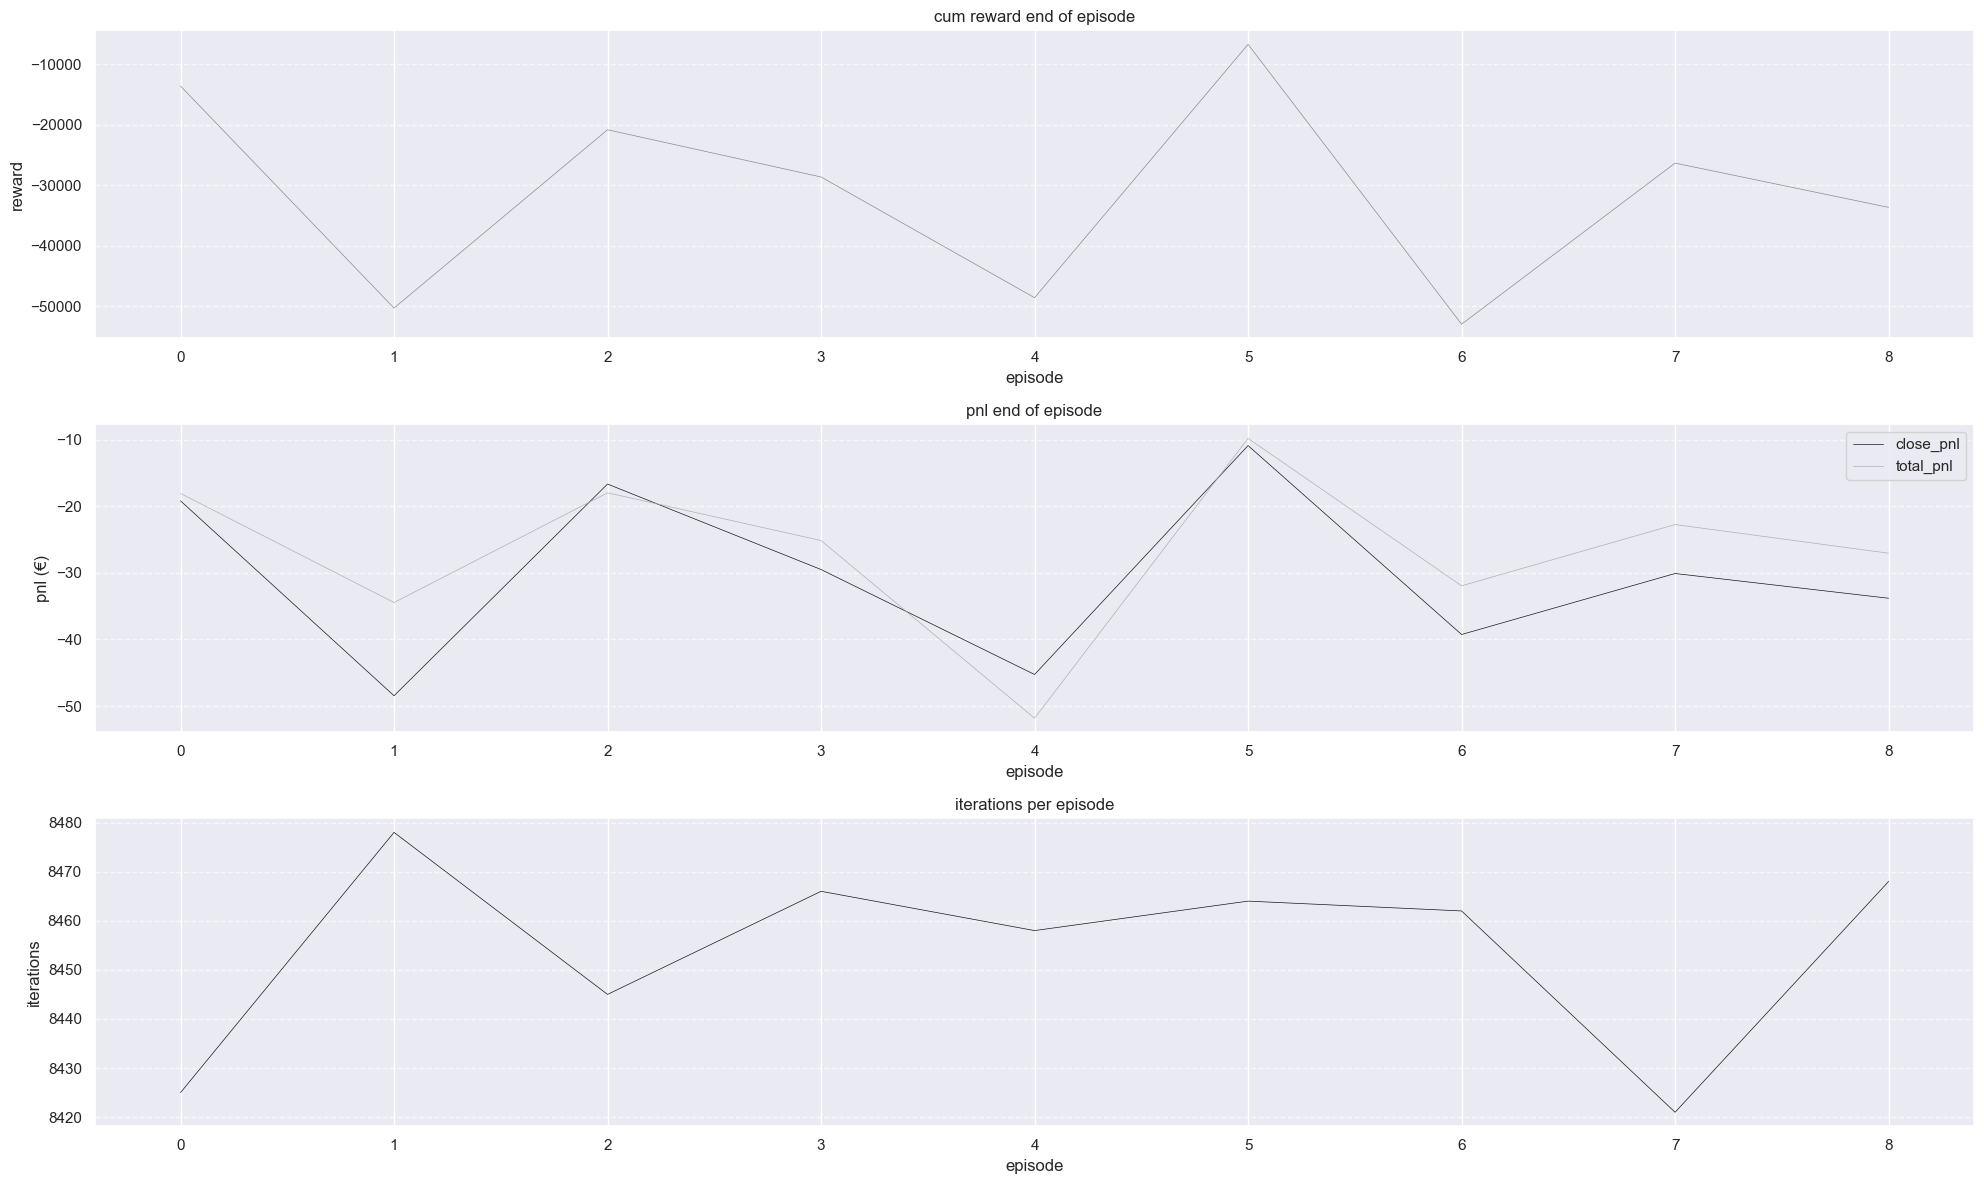

Creating new normalize training: True model X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
PPO : {'policy': 'MlpPolicy', 'env': <stable_baselines3.common.vec_env.vec_normalize.VecNormalize object at 0x000001F28A68ED40>, 'verbose': 1, 'learning_rate': 0.01, 'seed': 28220, 'gamma': 0.85, 'batch_size': 1024, 'n_epochs': 150, 'tensorboard_log': None, 'device': 'auto', 'vf_coef': 0.5, 'ent_coef': 0.0, 'clip_range': 0.2, 'gae_lambda': 0.95, 'policy_kwargs': None}
Using cuda device
Creating new normalize training: True model X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
EvalCallback 668-> eval_freq: 23760.0   n_eval_episodes: 1
EvalCallback-> eval_freq: 23760.0   n_eval_episodes: 1
market_making_backtest_env AlphaAvellanedaStoikov_PPO_continuous reset received
PYTHON: reset start backtest
start_backtest AlphaAvellanedaStoikov_PPO_continuous launching jar...
start_backtest AlphaAvellanedaStoikov_PPO_continuous waiting (backtest_i

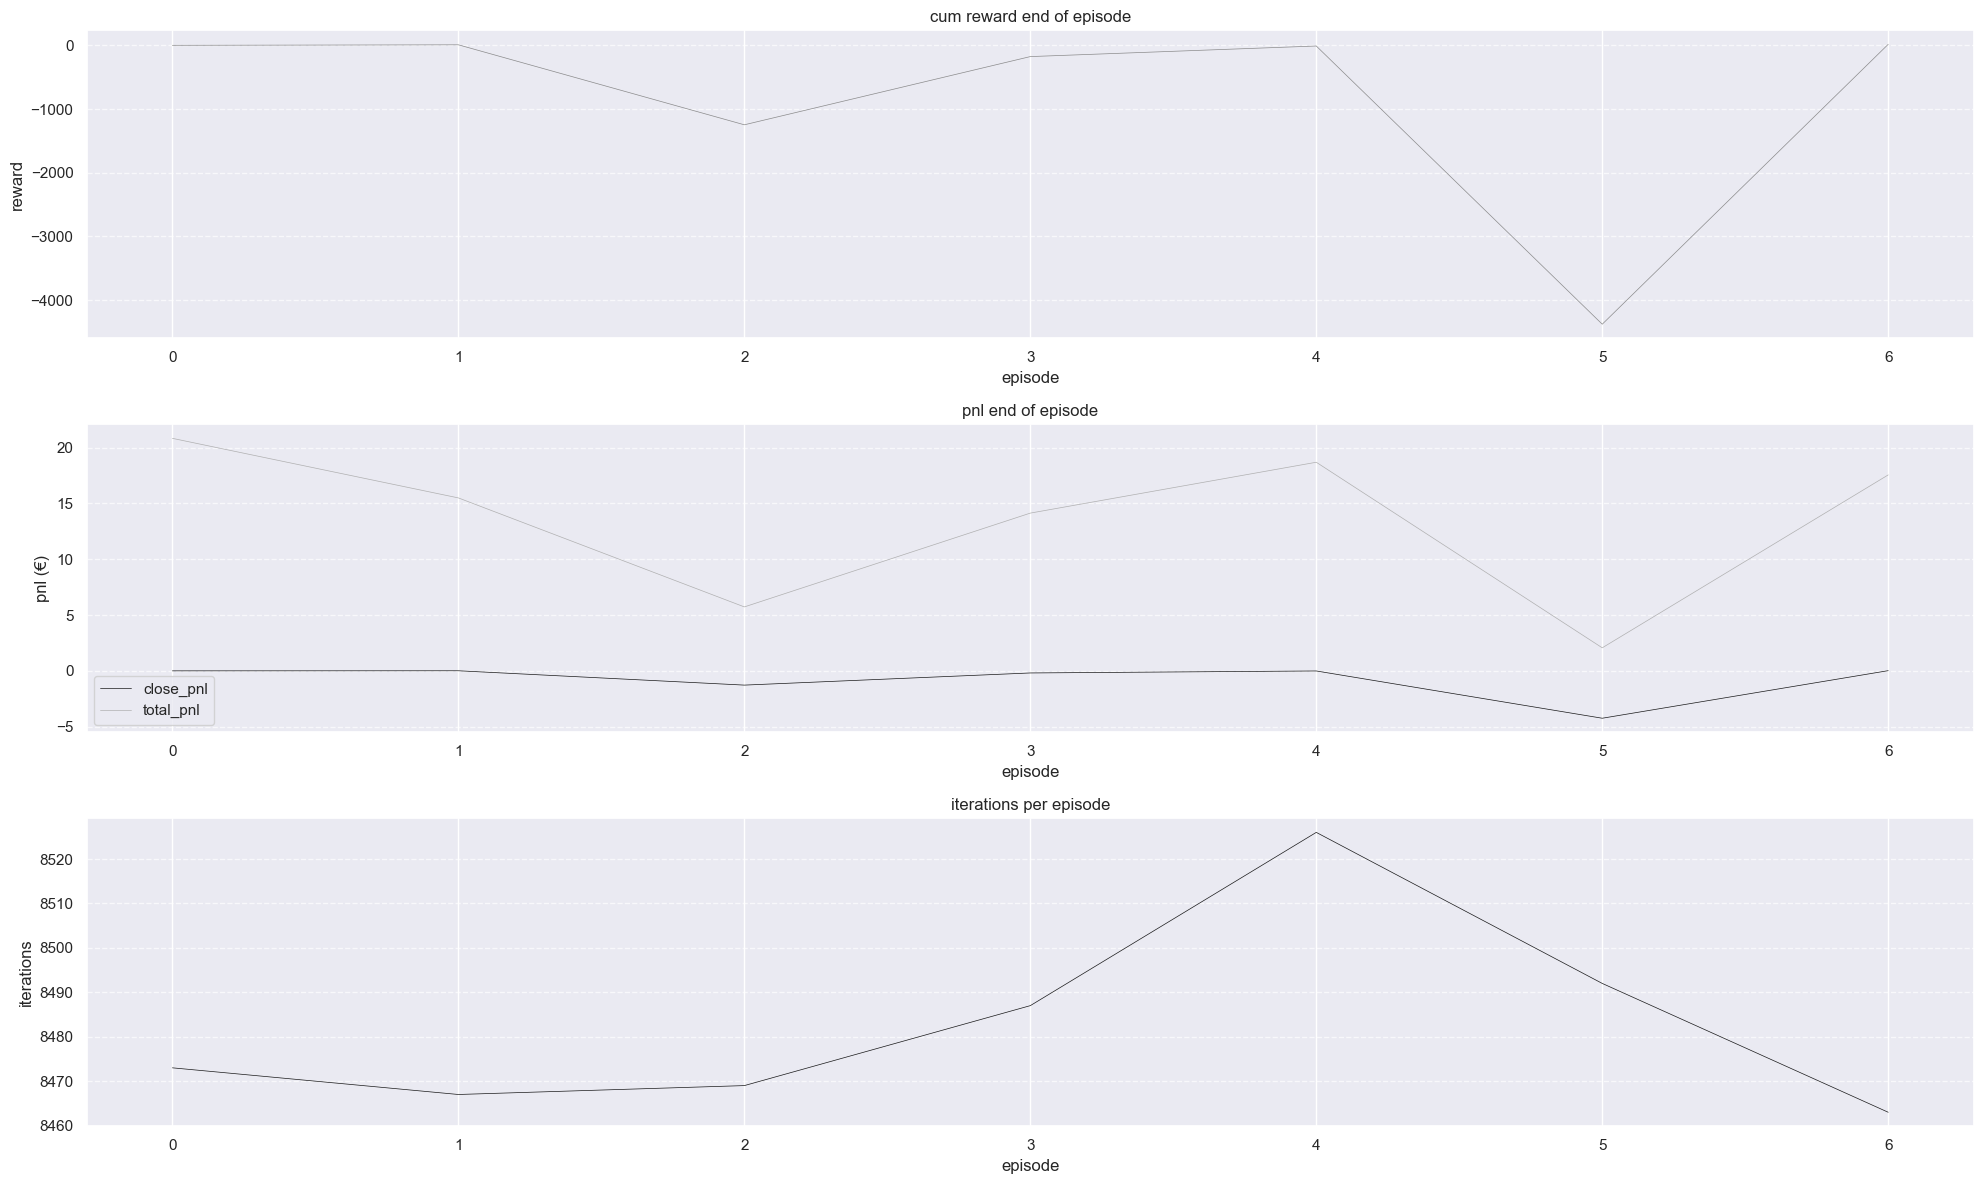

Creating new normalize training: True model X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
PPO : {'policy': 'MlpPolicy', 'env': <stable_baselines3.common.vec_env.vec_normalize.VecNormalize object at 0x000001F28A295C90>, 'verbose': 1, 'learning_rate': 0.01, 'seed': 28220, 'gamma': 0.85, 'batch_size': 1024, 'n_epochs': 150, 'tensorboard_log': None, 'device': 'auto', 'vf_coef': 0.5, 'ent_coef': 0.0, 'clip_range': 0.2, 'gae_lambda': 0.95, 'policy_kwargs': None}
Using cuda device
Creating new normalize training: True model X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
EvalCallback 669-> eval_freq: 23760.0   n_eval_episodes: 1
EvalCallback-> eval_freq: 23760.0   n_eval_episodes: 1
market_making_backtest_env AlphaAvellanedaStoikov_PPO_discrete reset received
PYTHON: reset start backtest
start_backtest AlphaAvellanedaStoikov_PPO_discrete launching jar...
start_backtest AlphaAvellanedaStoikov_PPO_discrete waiting (backtest_is_ready) s

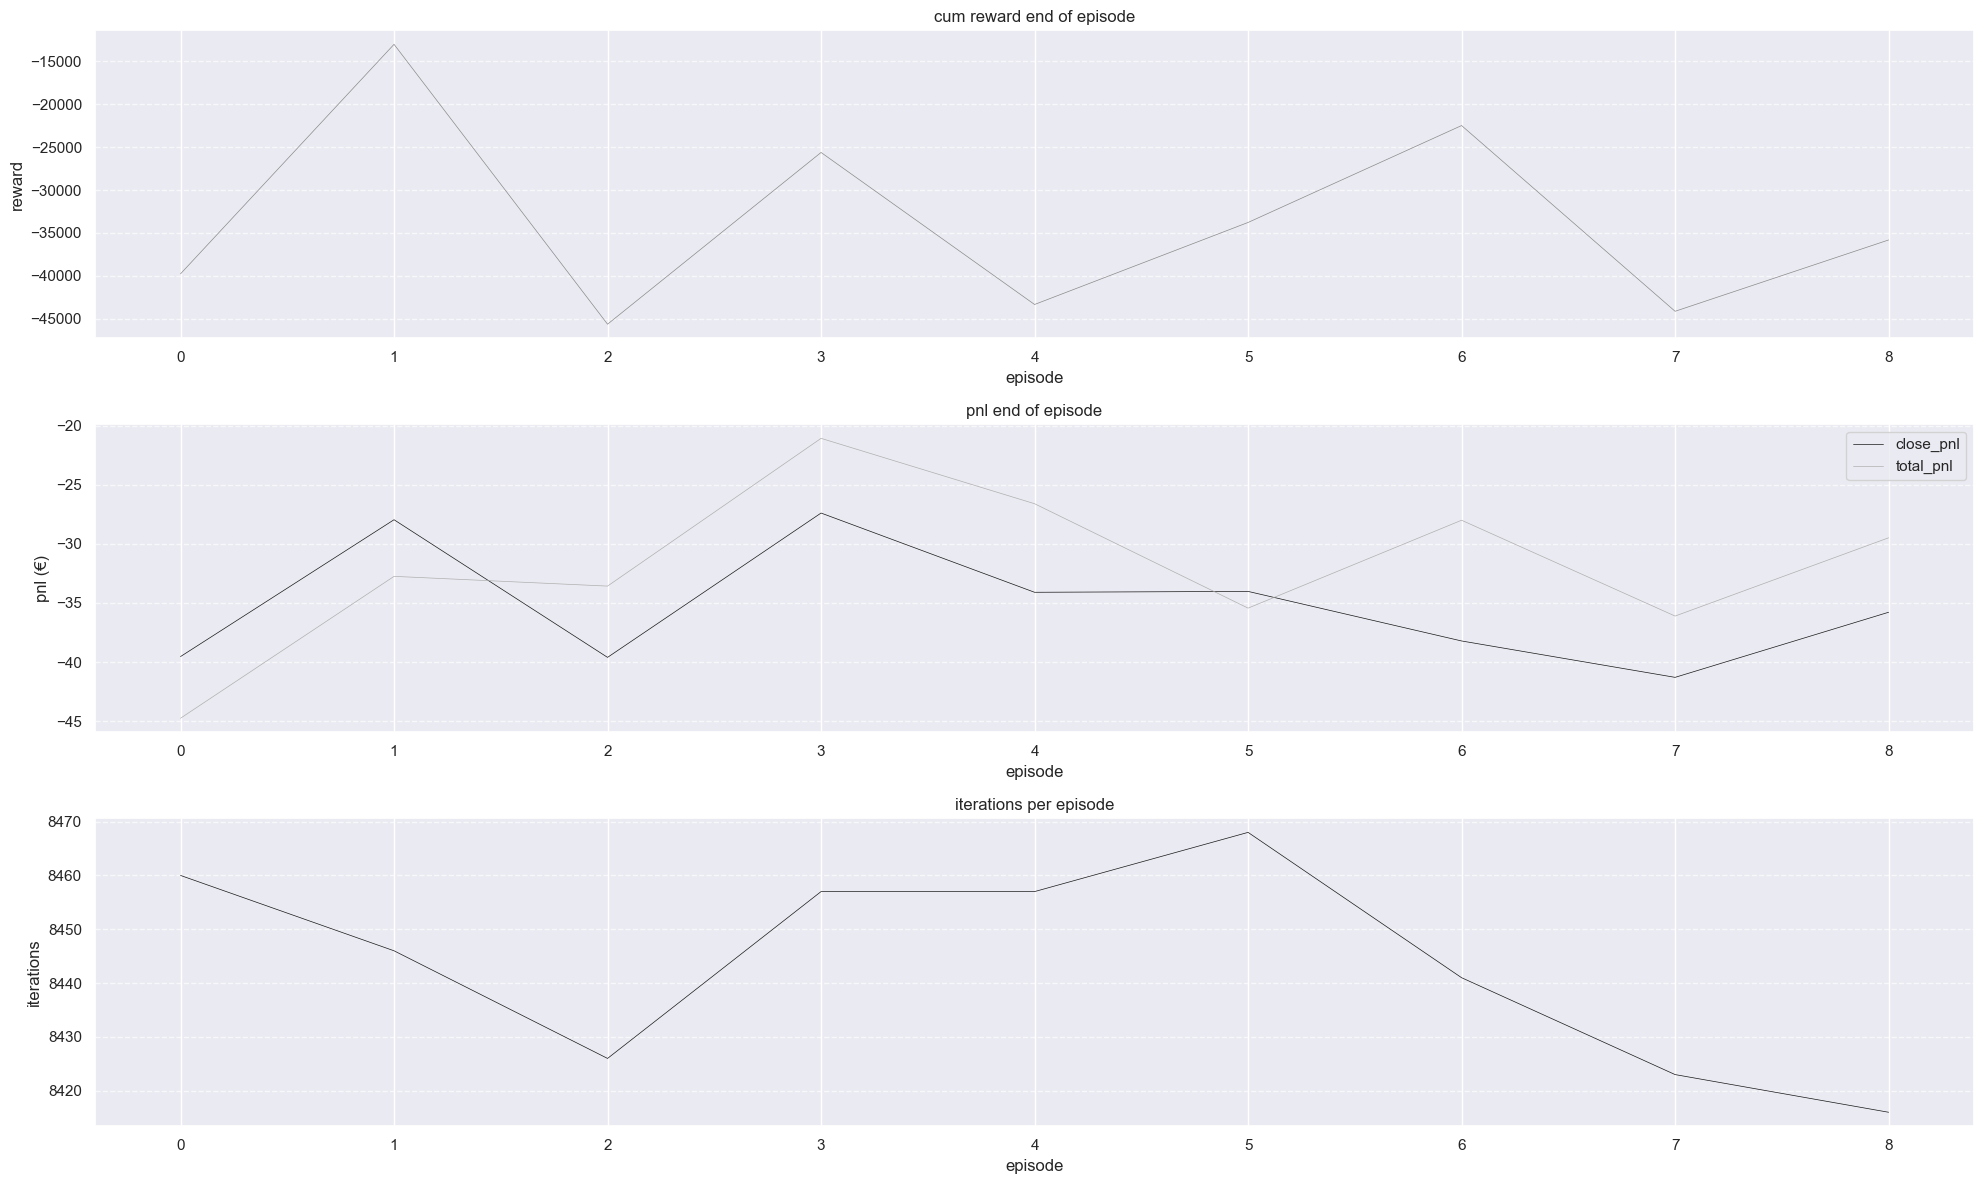

Finished backtest with 1 launchers
Creating new normalize training: True model X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
train_freq[-12] update the model: 1440 step
target_update_interval update the model: 2880 step
DQN : {'policy': 'MlpPolicy', 'env': <stable_baselines3.common.vec_env.vec_normalize.VecNormalize object at 0x000001F2AED625F0>, 'verbose': 1, 'learning_rate': 0.01, 'buffer_size': 100000, 'seed': 28220, 'gamma': 0.85, 'exploration_initial_eps': 1.0, 'exploration_final_eps': 0.2, 'batch_size': 1024, 'tensorboard_log': None, 'train_freq': (1440, 'step'), 'target_update_interval': 2880, 'device': 'auto', 'policy_kwargs': None}
Using cuda device
Creating new normalize training: True model X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
EvalCallback 670-> eval_freq: 23760.0   n_eval_episodes: 1
EvalCallback-> eval_freq: 23760.0   n_eval_episodes: 1
market_making_backtest_env AlphaConstantSpread_DQN_discrete reset receive

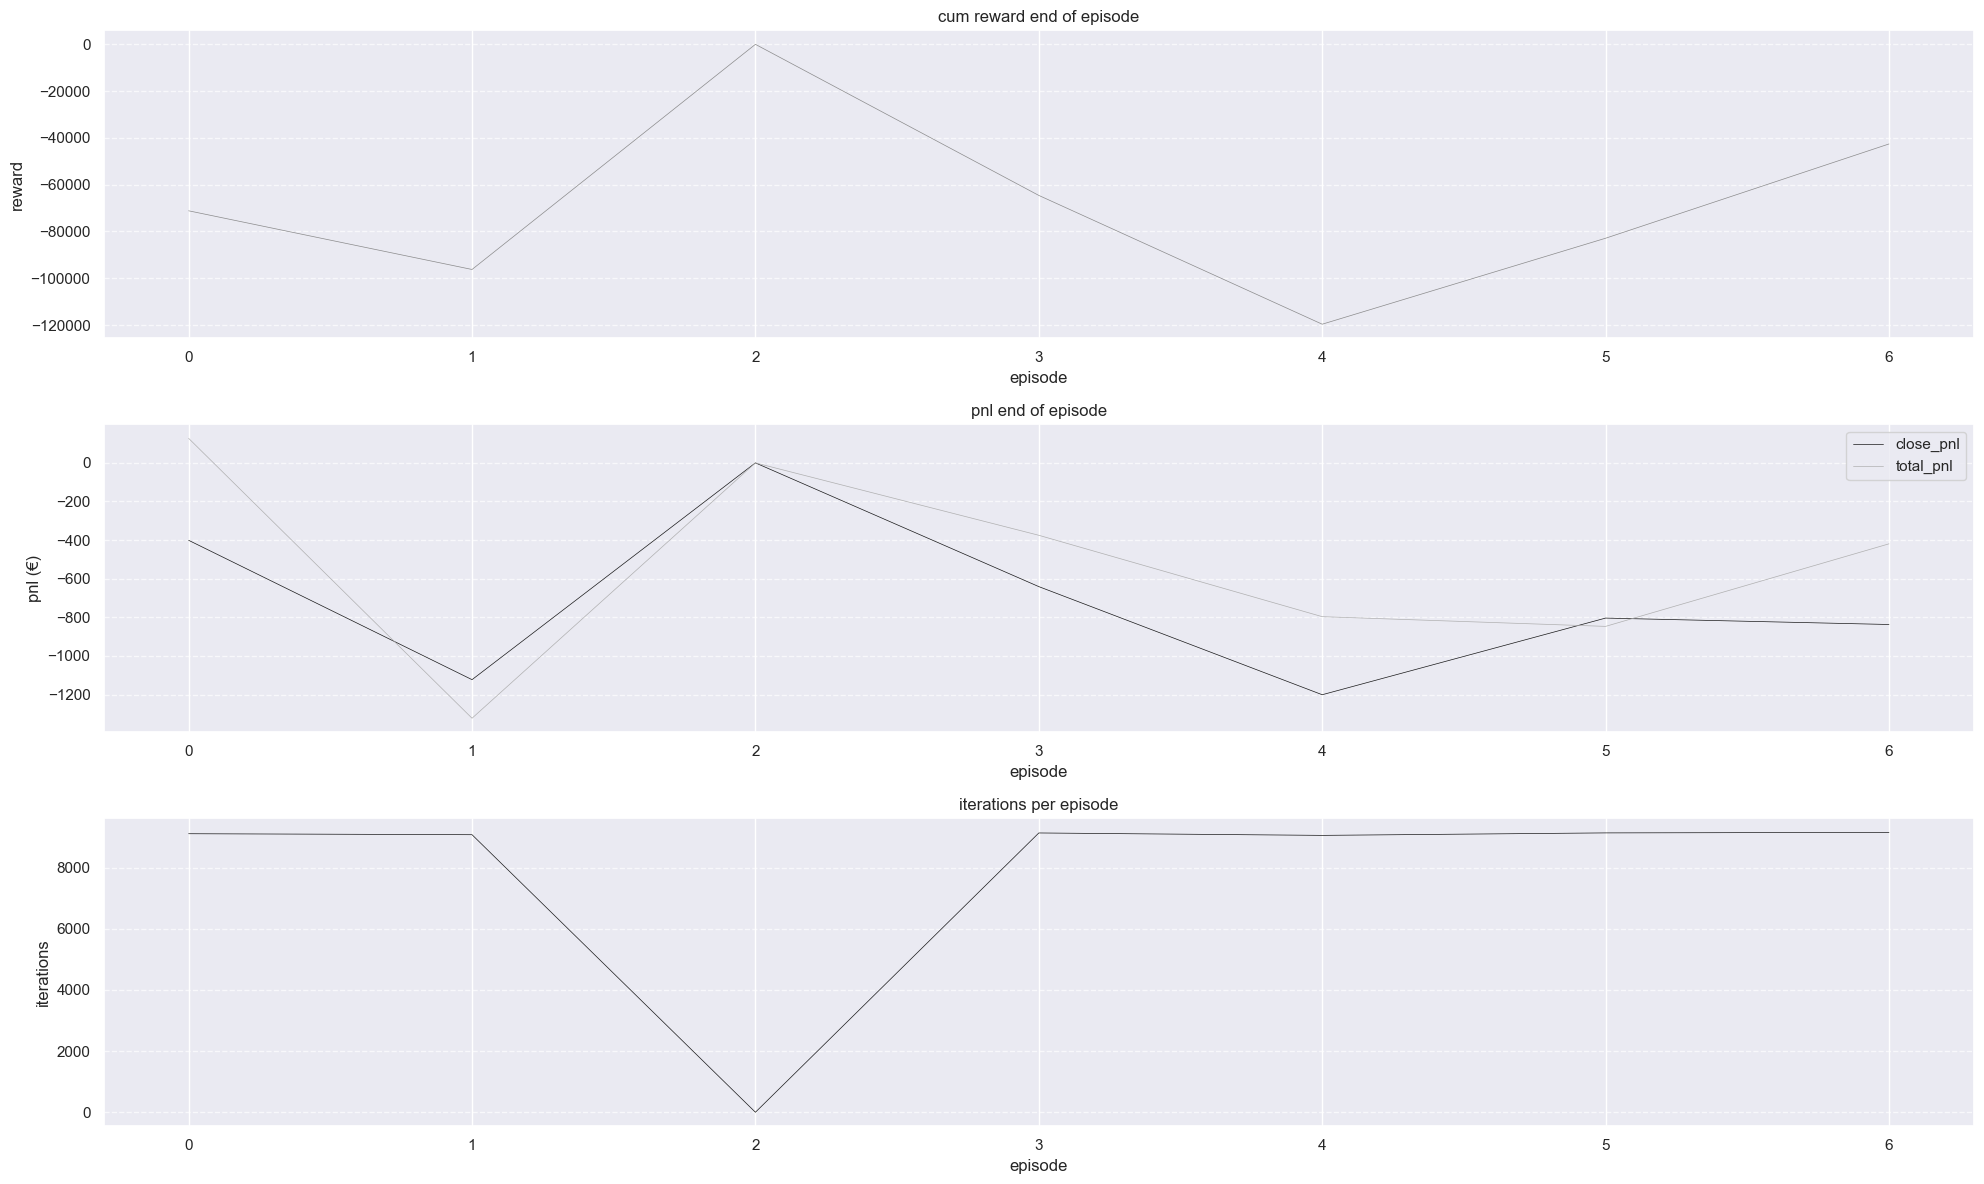

Creating new normalize training: True model X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
PPO : {'policy': 'MlpPolicy', 'env': <stable_baselines3.common.vec_env.vec_normalize.VecNormalize object at 0x000001F4C98EE0E0>, 'verbose': 1, 'learning_rate': 0.01, 'seed': 28220, 'gamma': 0.85, 'batch_size': 1024, 'n_epochs': 150, 'tensorboard_log': None, 'device': 'auto', 'vf_coef': 0.5, 'ent_coef': 0.0, 'clip_range': 0.2, 'gae_lambda': 0.95, 'policy_kwargs': None}
Using cuda device
Creating new normalize training: True model X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
EvalCallback 671-> eval_freq: 23760.0   n_eval_episodes: 1
EvalCallback-> eval_freq: 23760.0   n_eval_episodes: 1
market_making_backtest_env AlphaConstantSpread_PPO_discrete reset received
PYTHON: reset start backtest
start_backtest AlphaConstantSpread_PPO_discrete launching jar...
start_backtest AlphaConstantSpread_PPO_discrete waiting (backtest_is_ready) starting jar... 

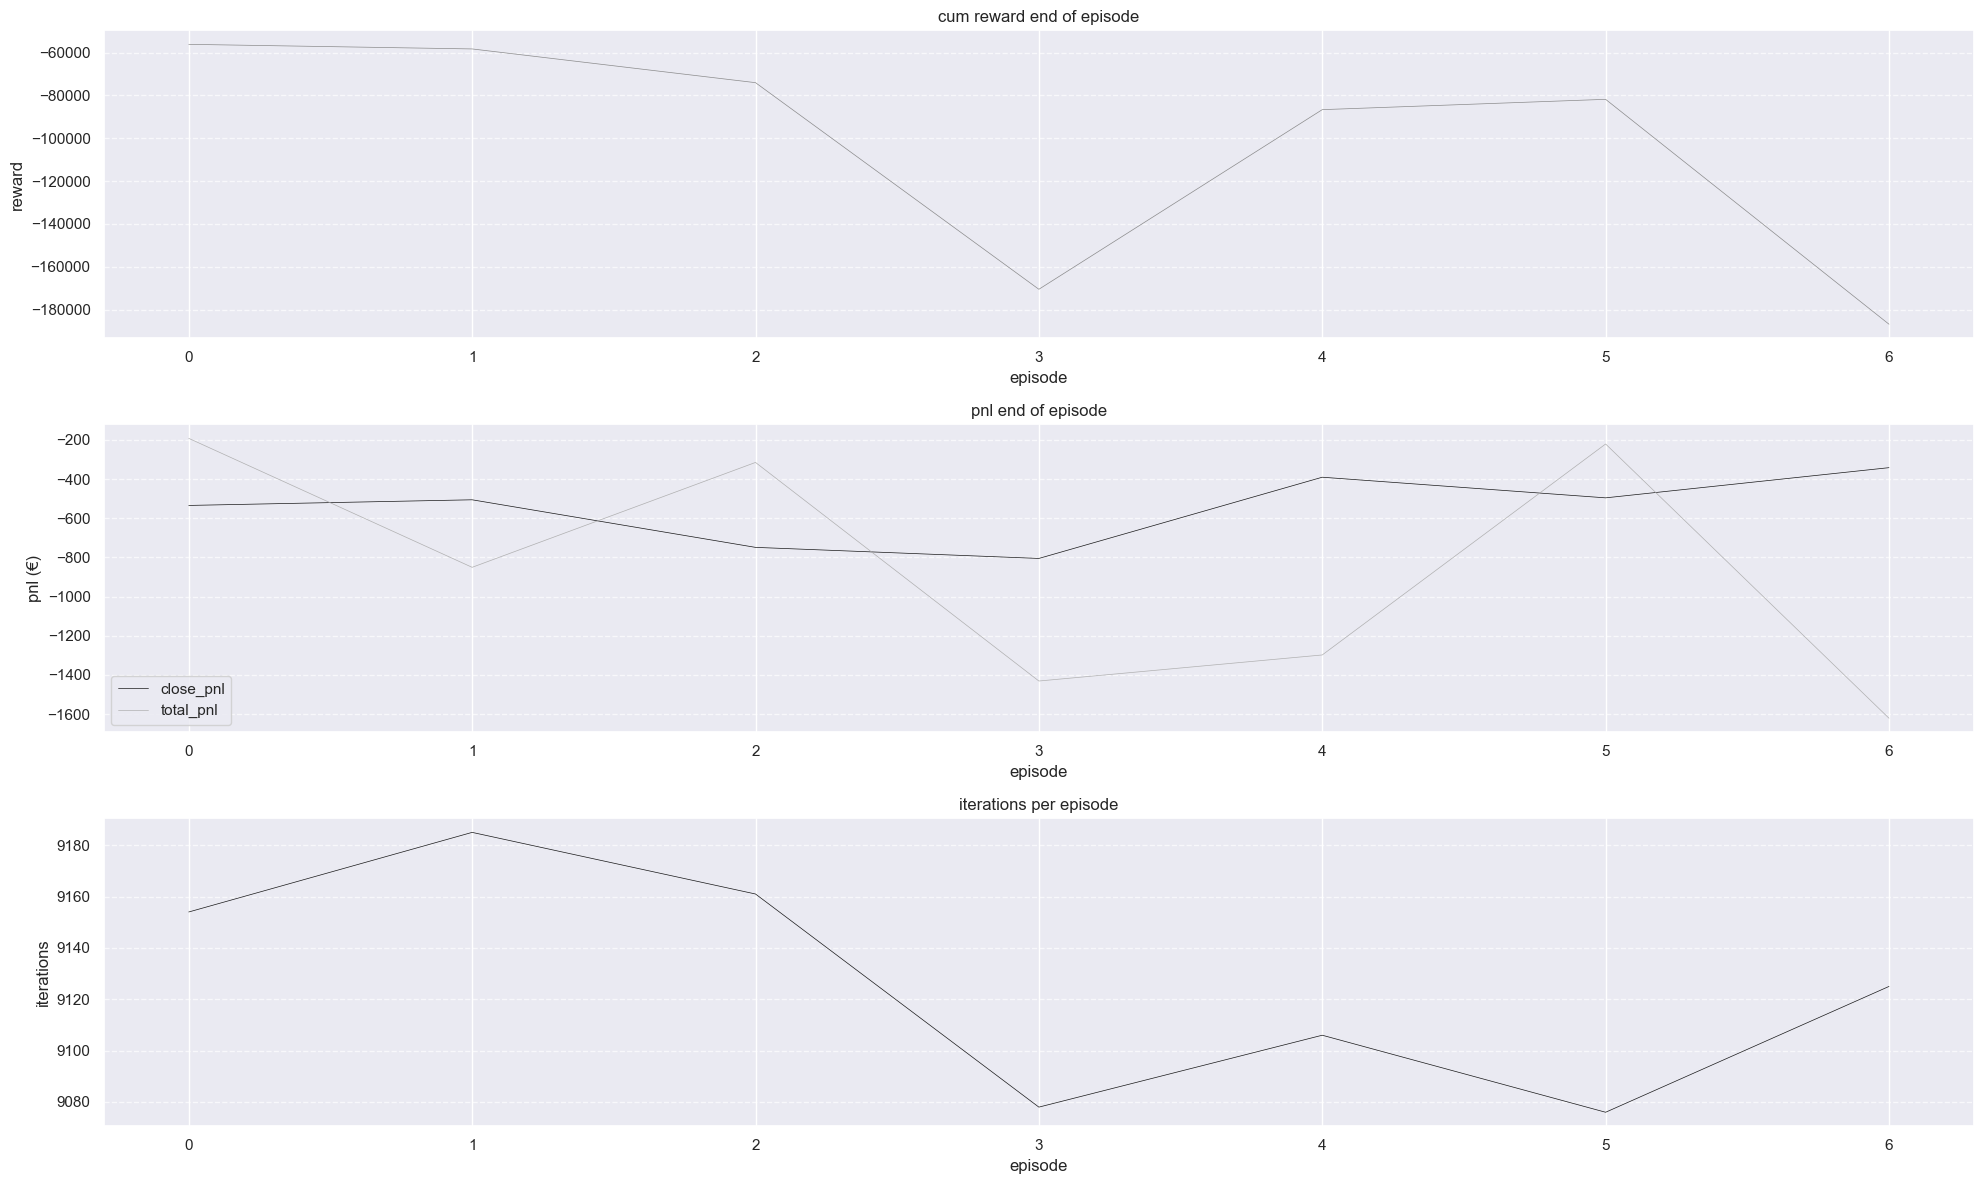

Creating new normalize training: True model X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
PPO : {'policy': 'MlpPolicy', 'env': <stable_baselines3.common.vec_env.vec_normalize.VecNormalize object at 0x000001F4D89038E0>, 'verbose': 1, 'learning_rate': 0.01, 'seed': 28220, 'gamma': 0.85, 'batch_size': 1024, 'n_epochs': 150, 'tensorboard_log': None, 'device': 'auto', 'vf_coef': 0.5, 'ent_coef': 0.0, 'clip_range': 0.2, 'gae_lambda': 0.95, 'policy_kwargs': None}
Using cuda device
Creating new normalize training: True model X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
EvalCallback 672-> eval_freq: 23760.0   n_eval_episodes: 1
EvalCallback-> eval_freq: 23760.0   n_eval_episodes: 1
market_making_backtest_env AlphaConstantSpread_PPO_continuous reset received
PYTHON: reset start backtest
start_backtest AlphaConstantSpread_PPO_continuous launching jar...
start_backtest AlphaConstantSpread_PPO_continuous waiting (backtest_is_ready) starti

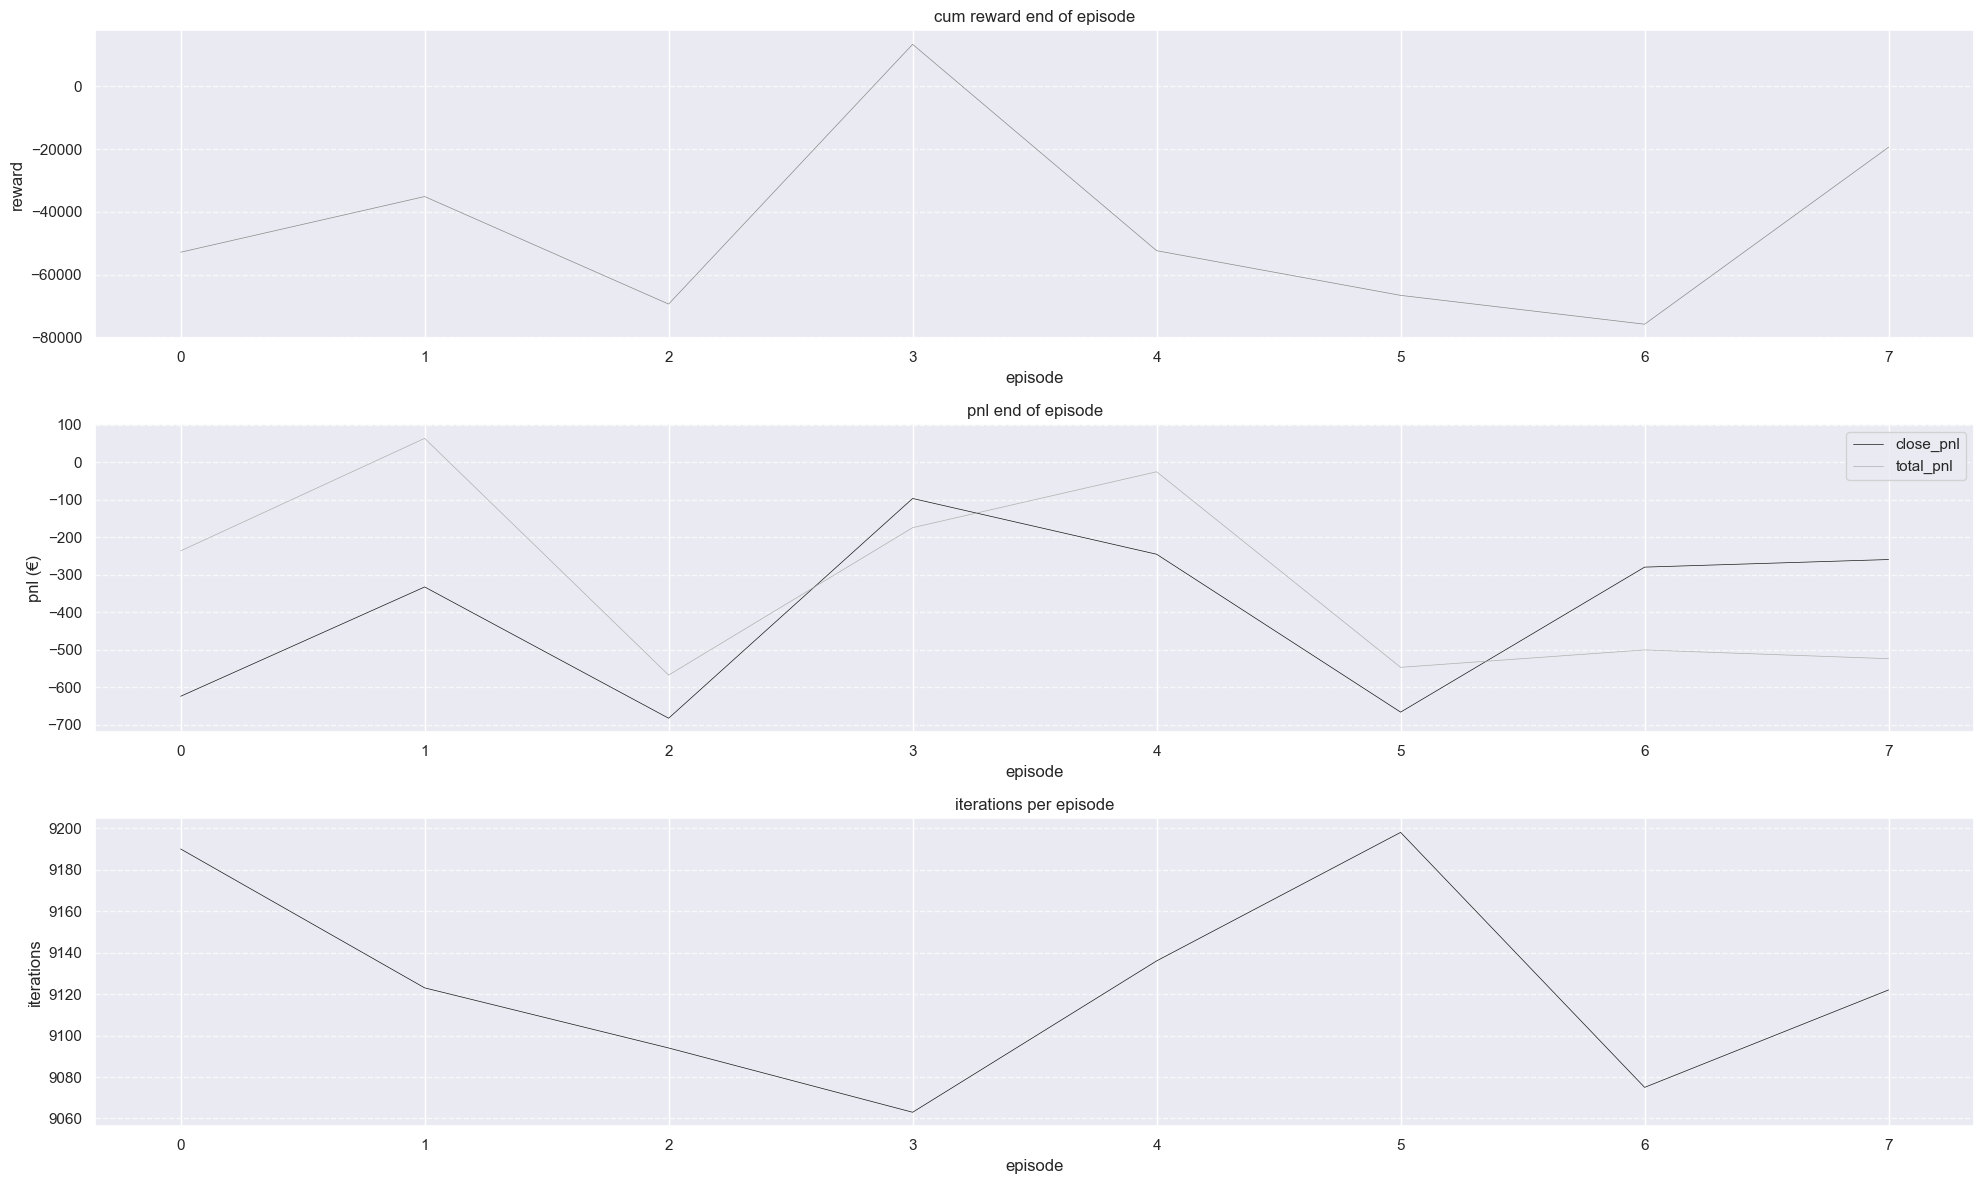

train of 10 iterations 6 algorithms finished in 174.71 minutes


In [22]:
start=time.time()

rl_early_stopping_patience=3
rl_early_stopping_min_patience = 0
rl_iterations_train=10
rl_simultaneous_algos_train=1
rl_early_stopping_score = InfoStepKey.totalPnl

if DEBUG:
    print("DEBUG")
    rl_early_stopping_min_patience=0
    rl_iterations_train=5
    rl_simultaneous_algos_train=1


if TRAINING:
    print(rf"TRAINING {len(algorithms_train_list)} algorithms")
    
    for algorithm in algorithms_train_list:        
        output_train_list=algorithm.train(
                instrument_pk=instrument_pk,
                start_date=day_train+ datetime.timedelta(hours=int(FIRST_HOUR-2)),
                end_date=day_train+ datetime.timedelta(hours=int(LAST_HOUR+2)),
                iterations=rl_iterations_train,
                simultaneous_algos=rl_simultaneous_algos_train,
                clean_initial_experience=True,
                patience = rl_early_stopping_patience,
                min_iterations = rl_early_stopping_min_patience,
                score_early_stopping=rl_early_stopping_score,
                plot_training=True
            )
        
    elapsed=time.time()-start
    print('train of %d iterations %d algorithms finished in %.2f minutes'%(rl_iterations_train,len(algorithms_train_list),elapsed/60))

        
else:
    print('using previous trained model')


## Testing <a class="anchor" id="testing"></a>

testing 29 days


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_PPO_

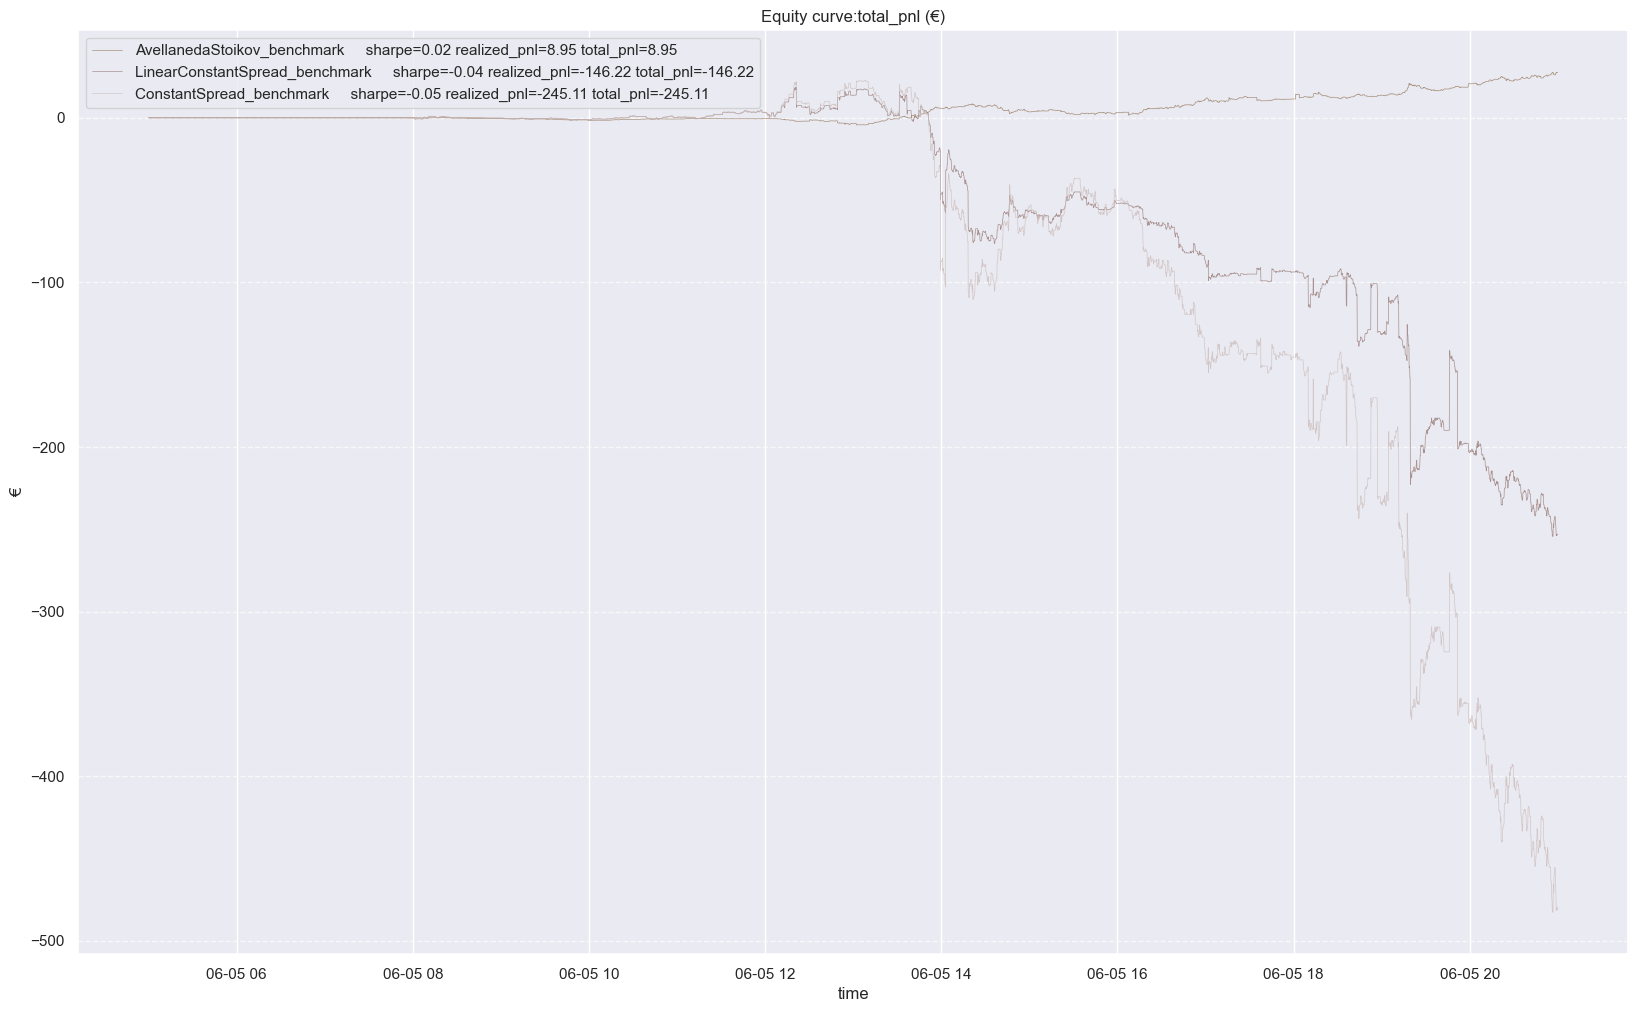

  3%|██▊                                                                             | 1/29 [03:36<1:40:51, 216.14s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...

Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_P

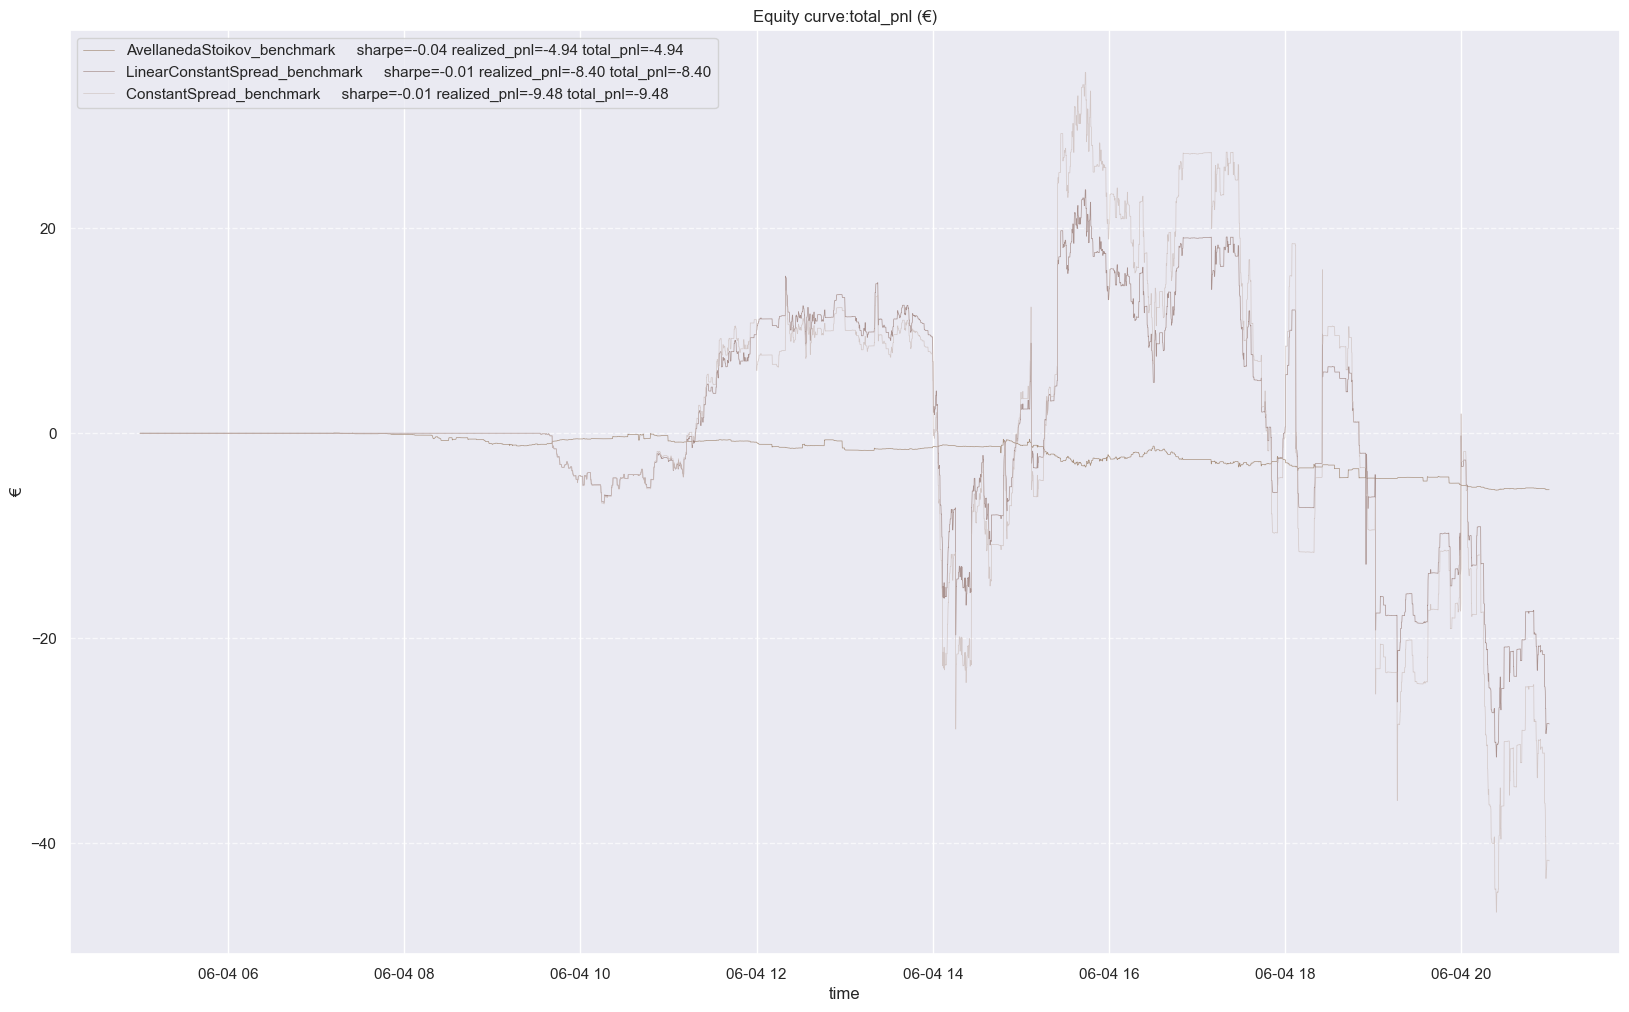

  7%|█████▌                                                                          | 2/29 [07:12<1:37:27, 216.56s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebookspwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...

Loading existing model from X:\output_models/AlphaAvellanedaStoikov_D

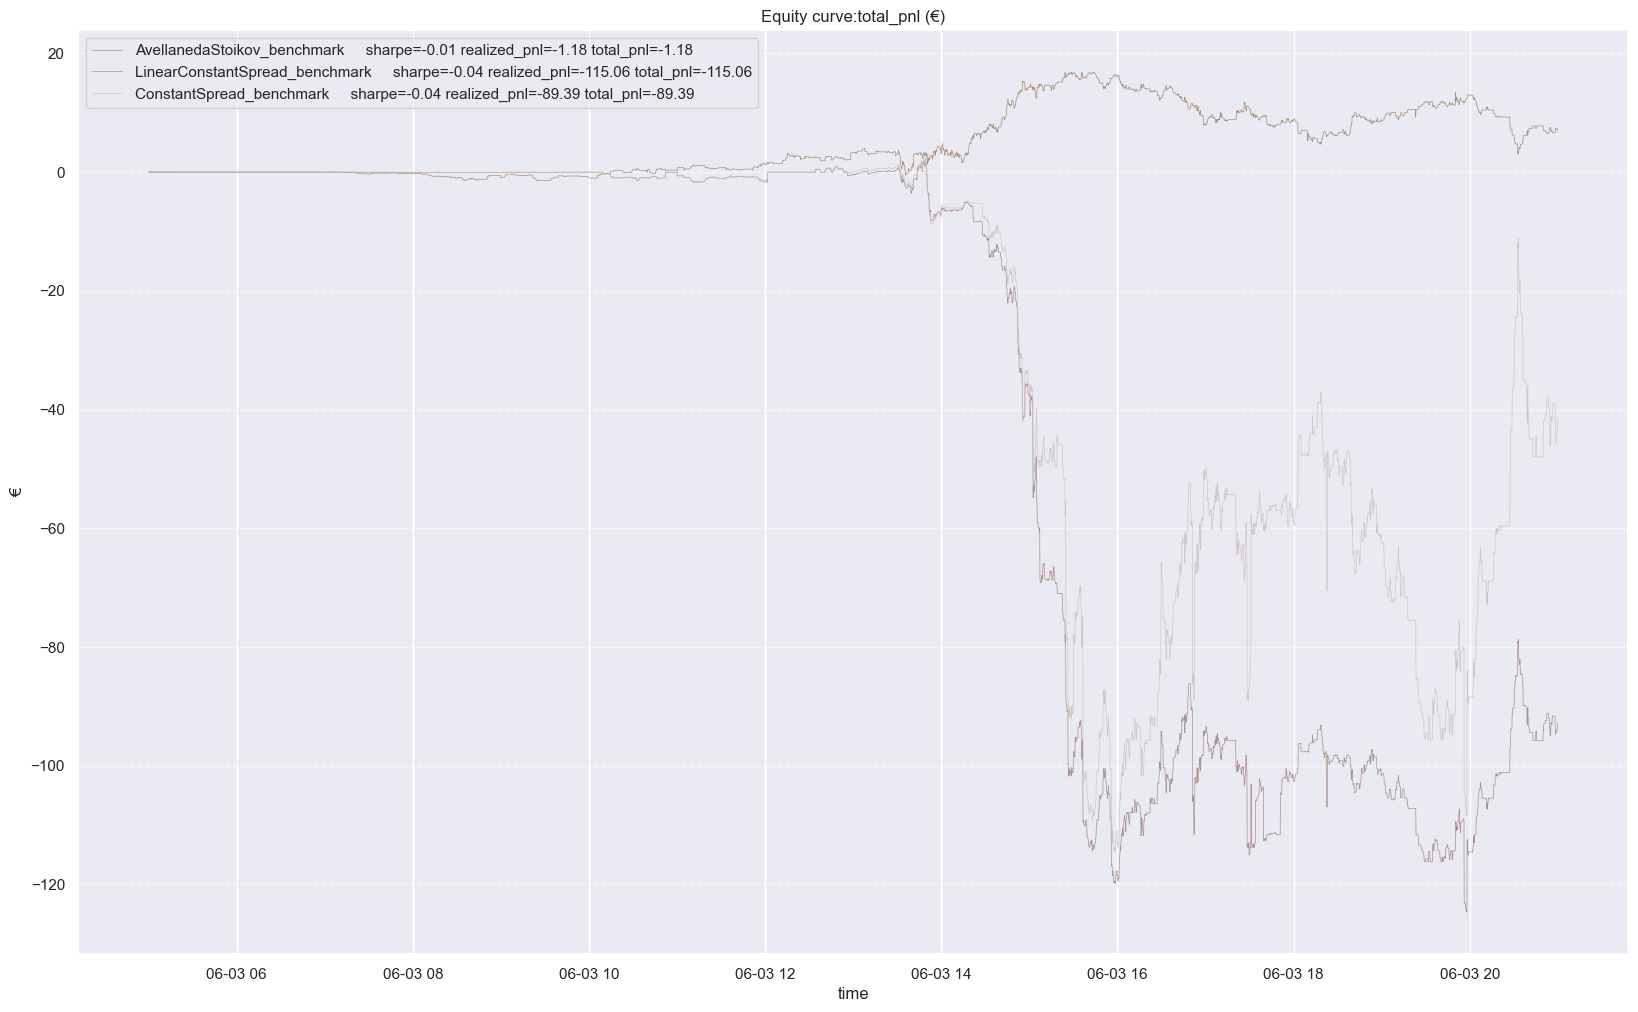

 10%|████████▎                                                                       | 3/29 [11:11<1:38:12, 226.64s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...

Loading existing model from X:\output_models/AlphaAvellanedaStoikov_P

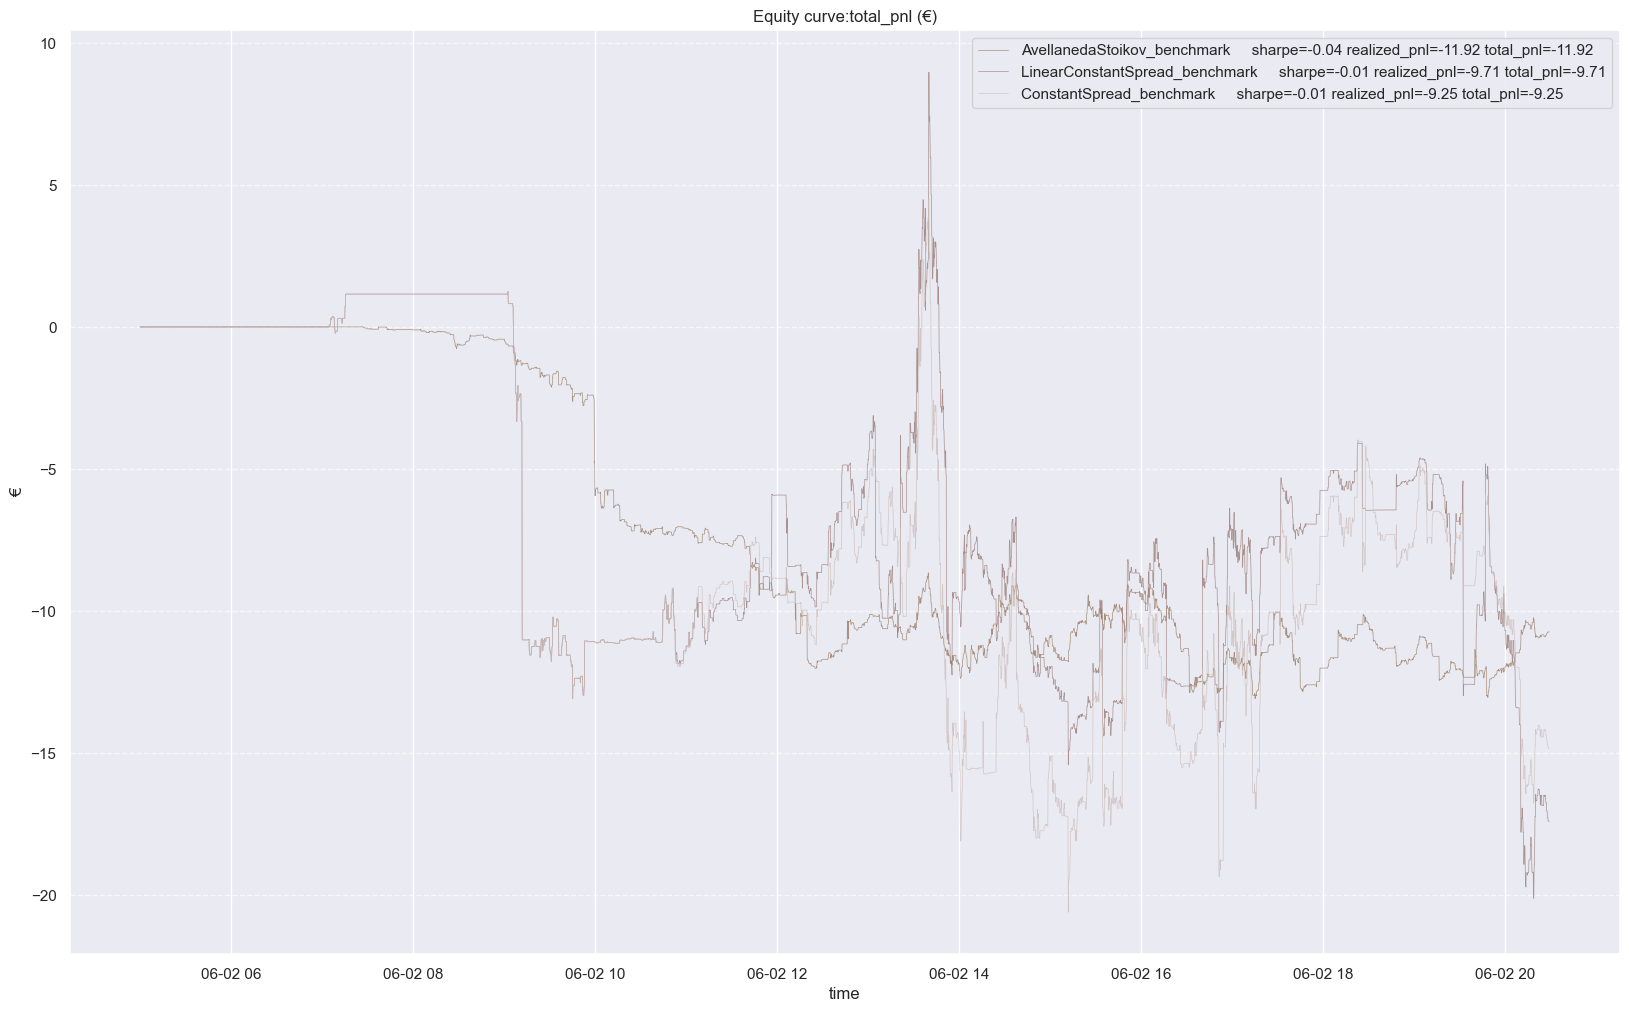

 14%|███████████                                                                     | 4/29 [15:23<1:38:31, 236.47s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_PPO_

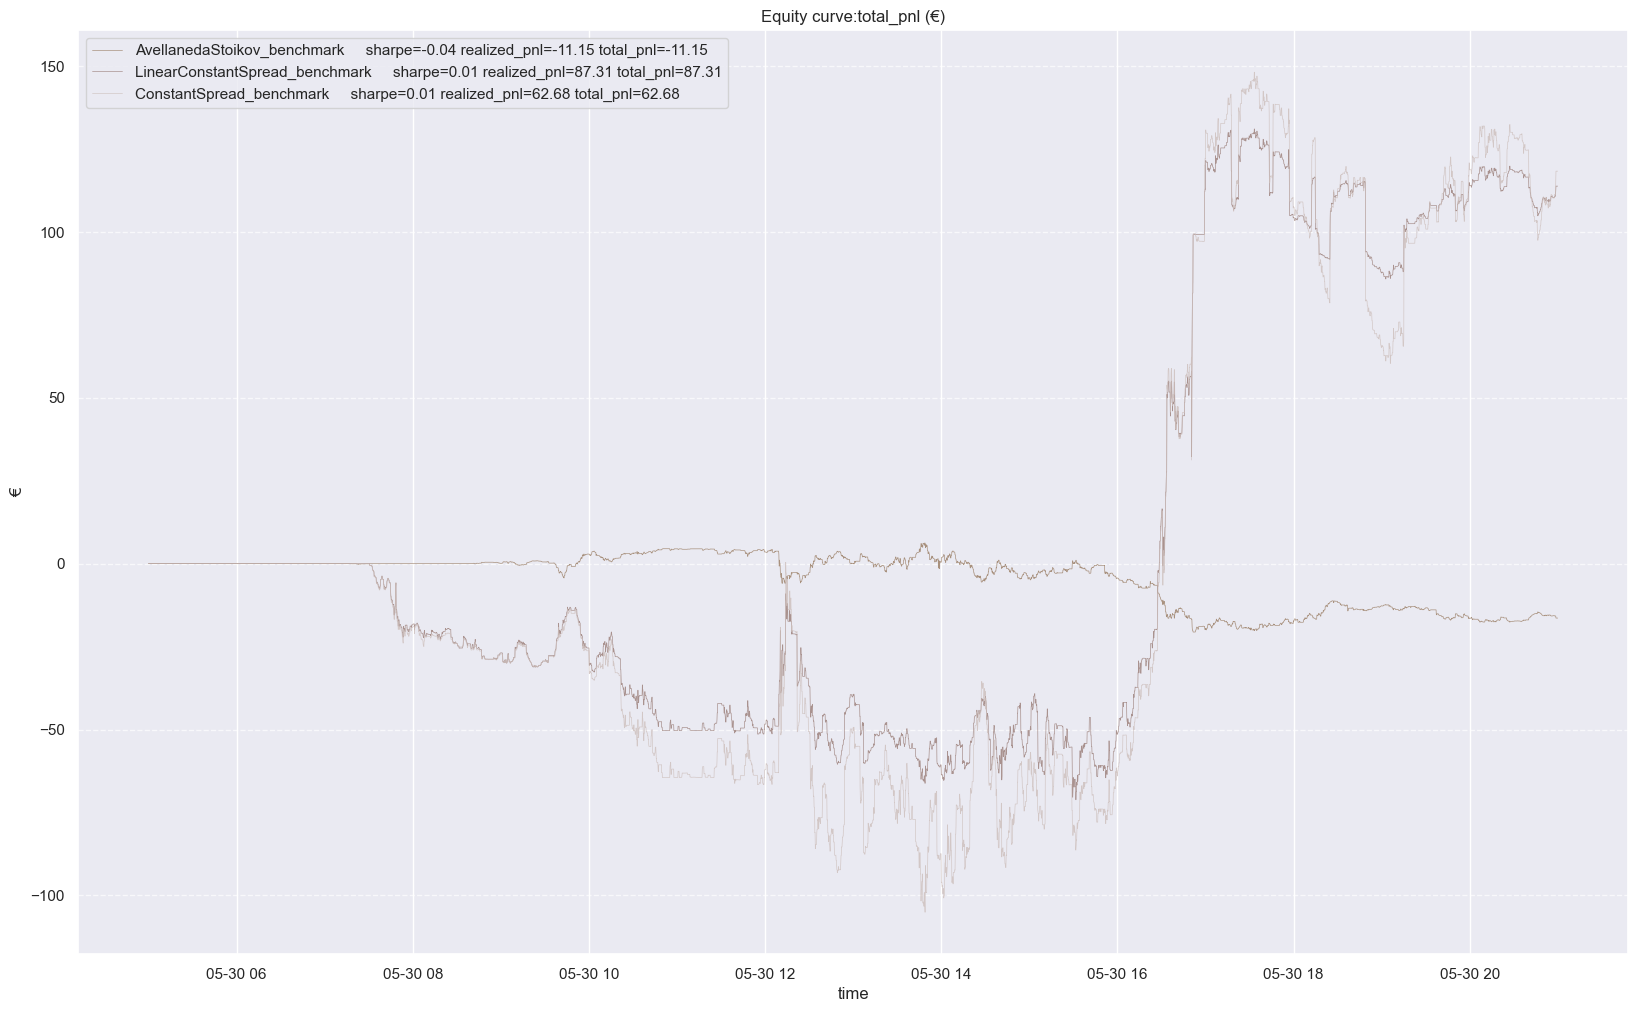

 17%|█████████████▊                                                                  | 5/29 [20:40<1:46:11, 265.48s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_PPO_

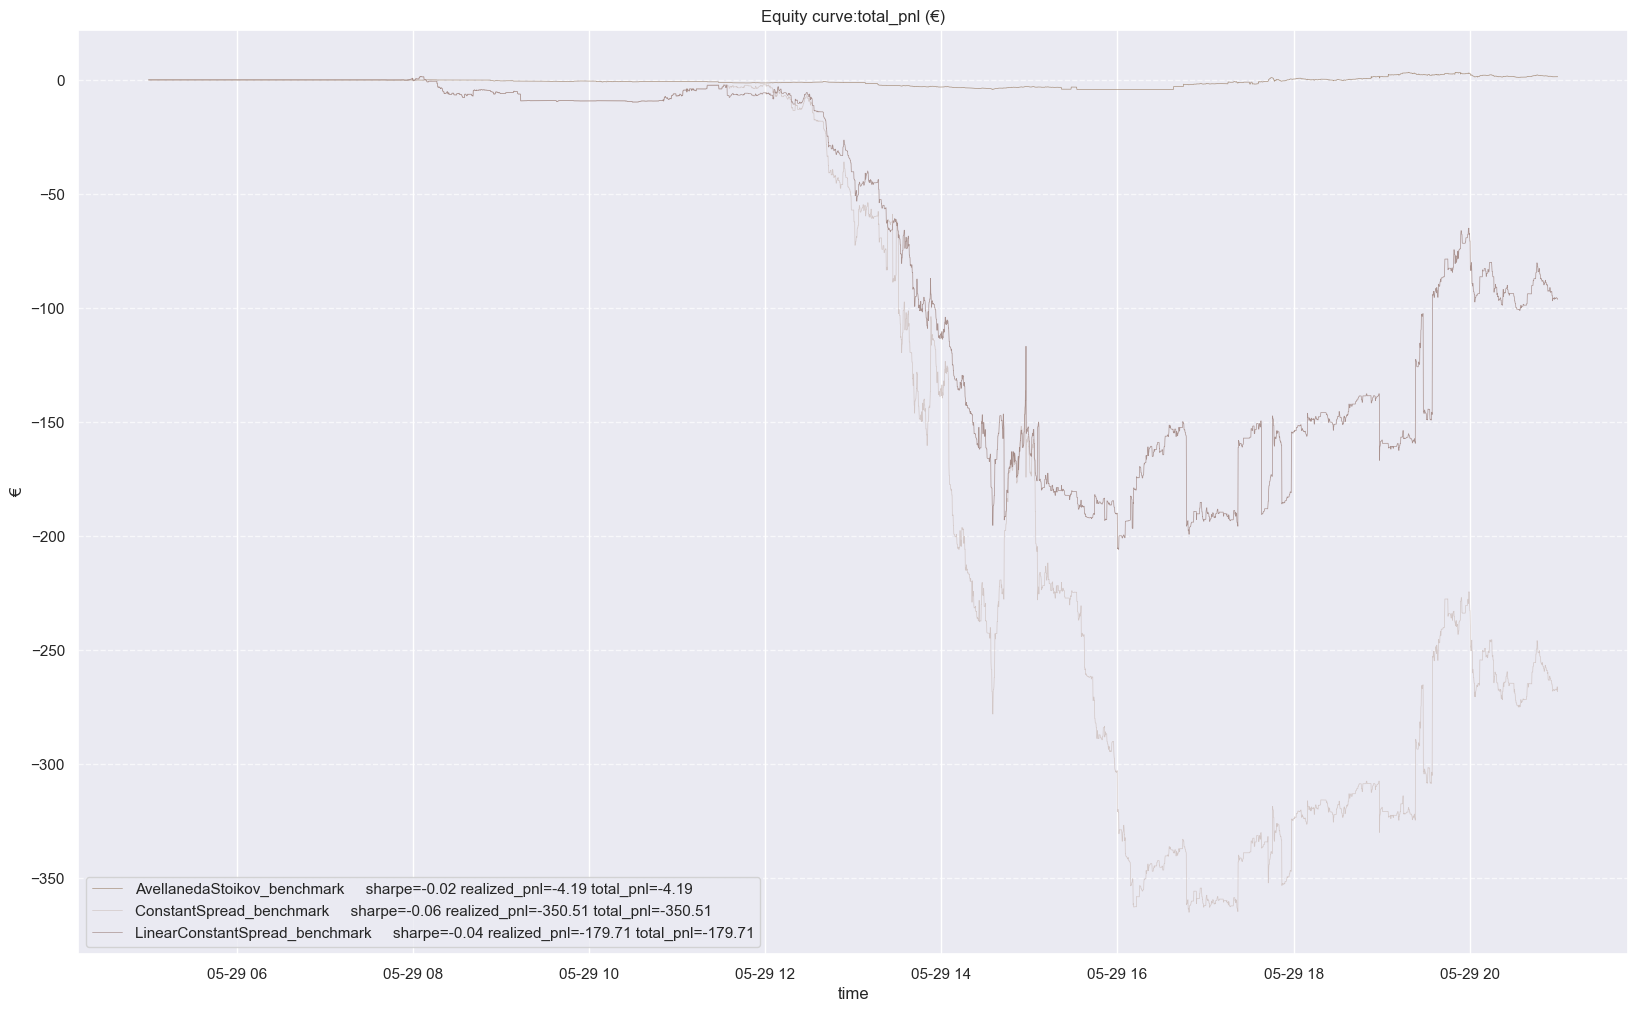

 21%|████████████████▌                                                               | 6/29 [24:29<1:37:07, 253.36s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...

Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_D

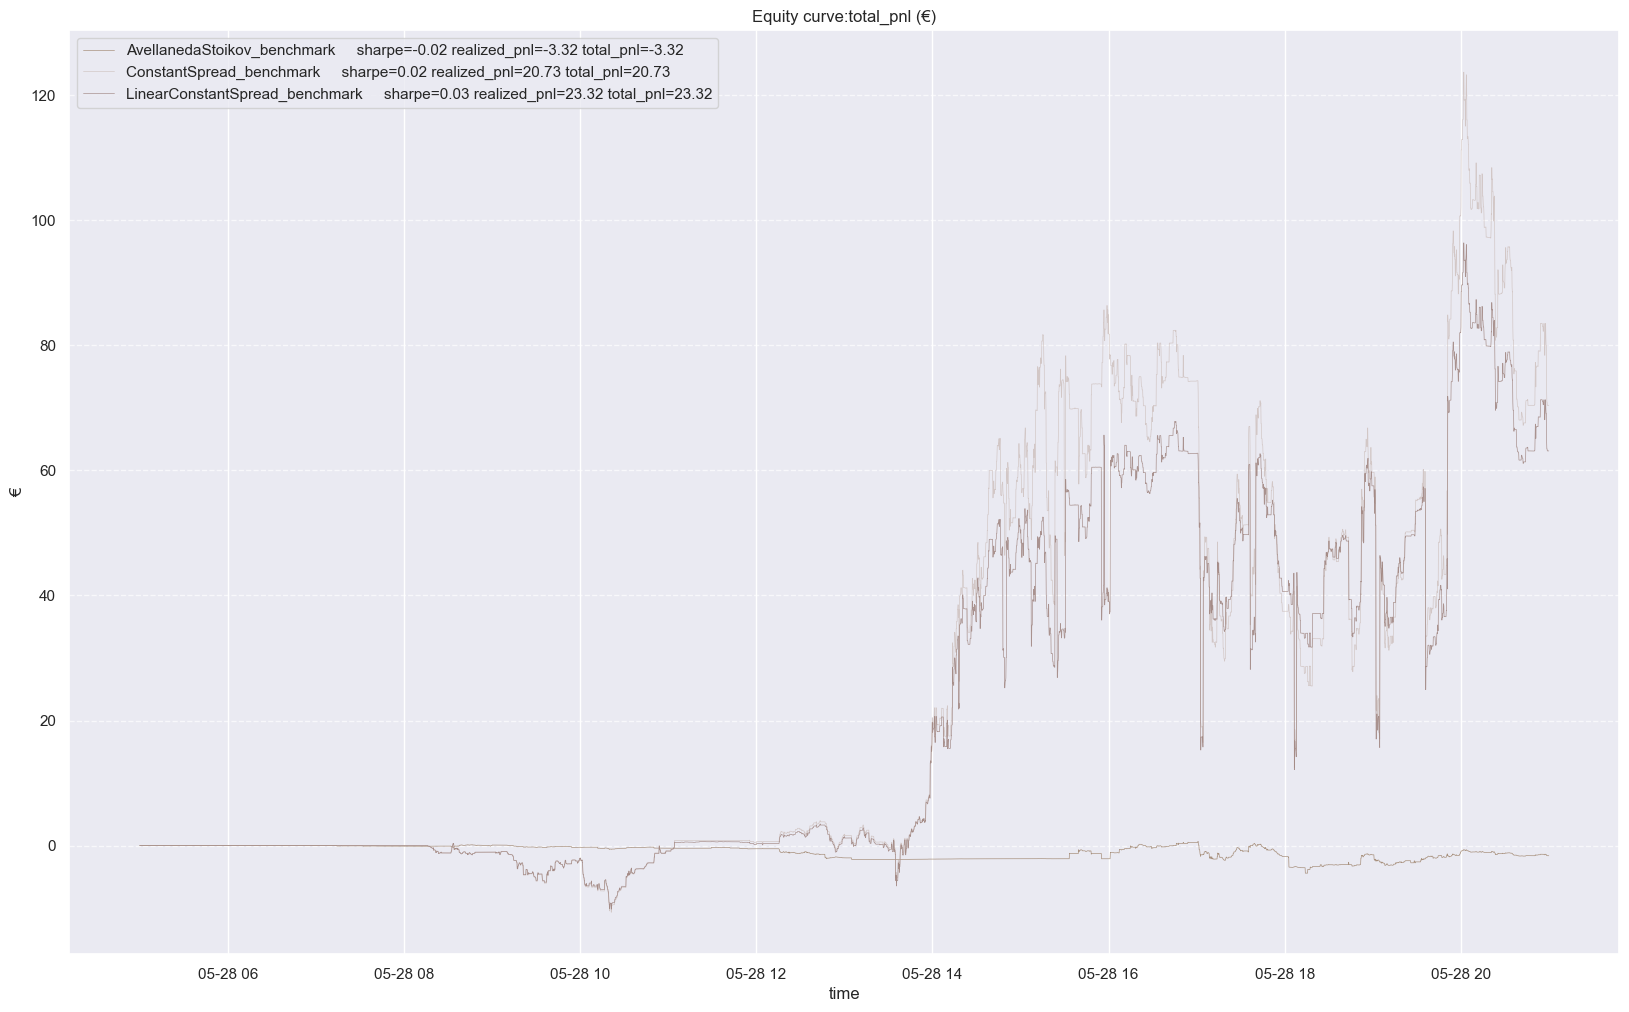

 24%|███████████████████▎                                                            | 7/29 [28:21<1:30:13, 246.09s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_DQN_

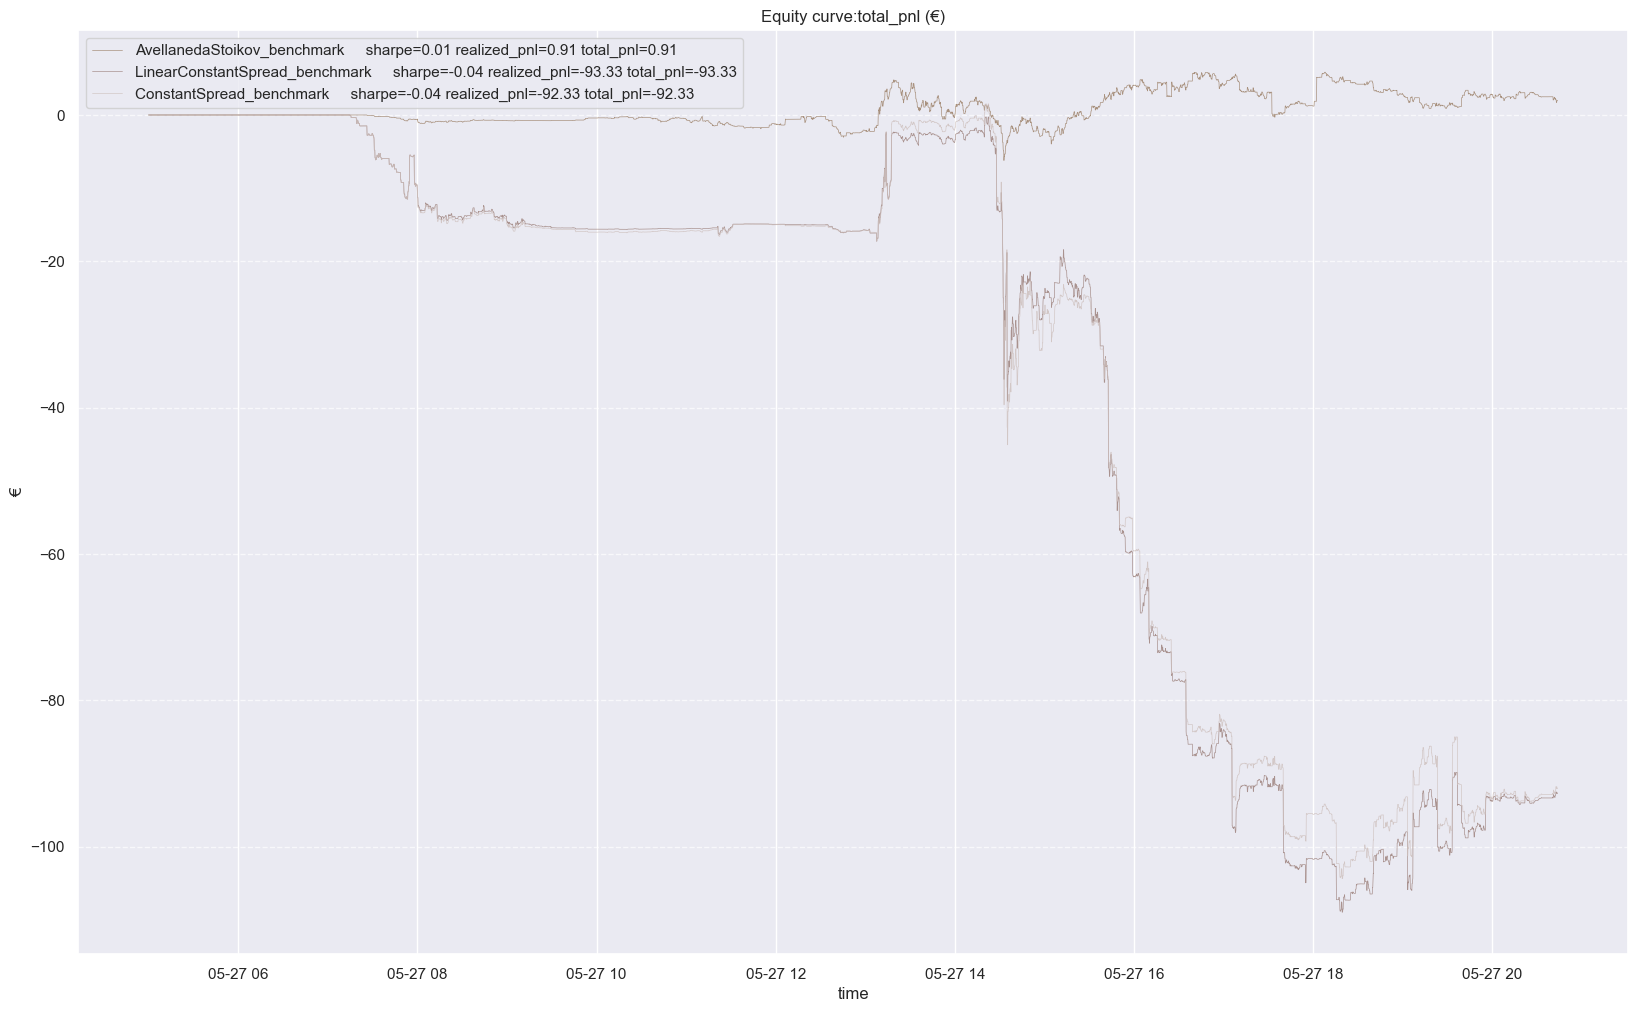

 28%|██████████████████████                                                          | 8/29 [32:01<1:23:16, 237.95s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_DQN_

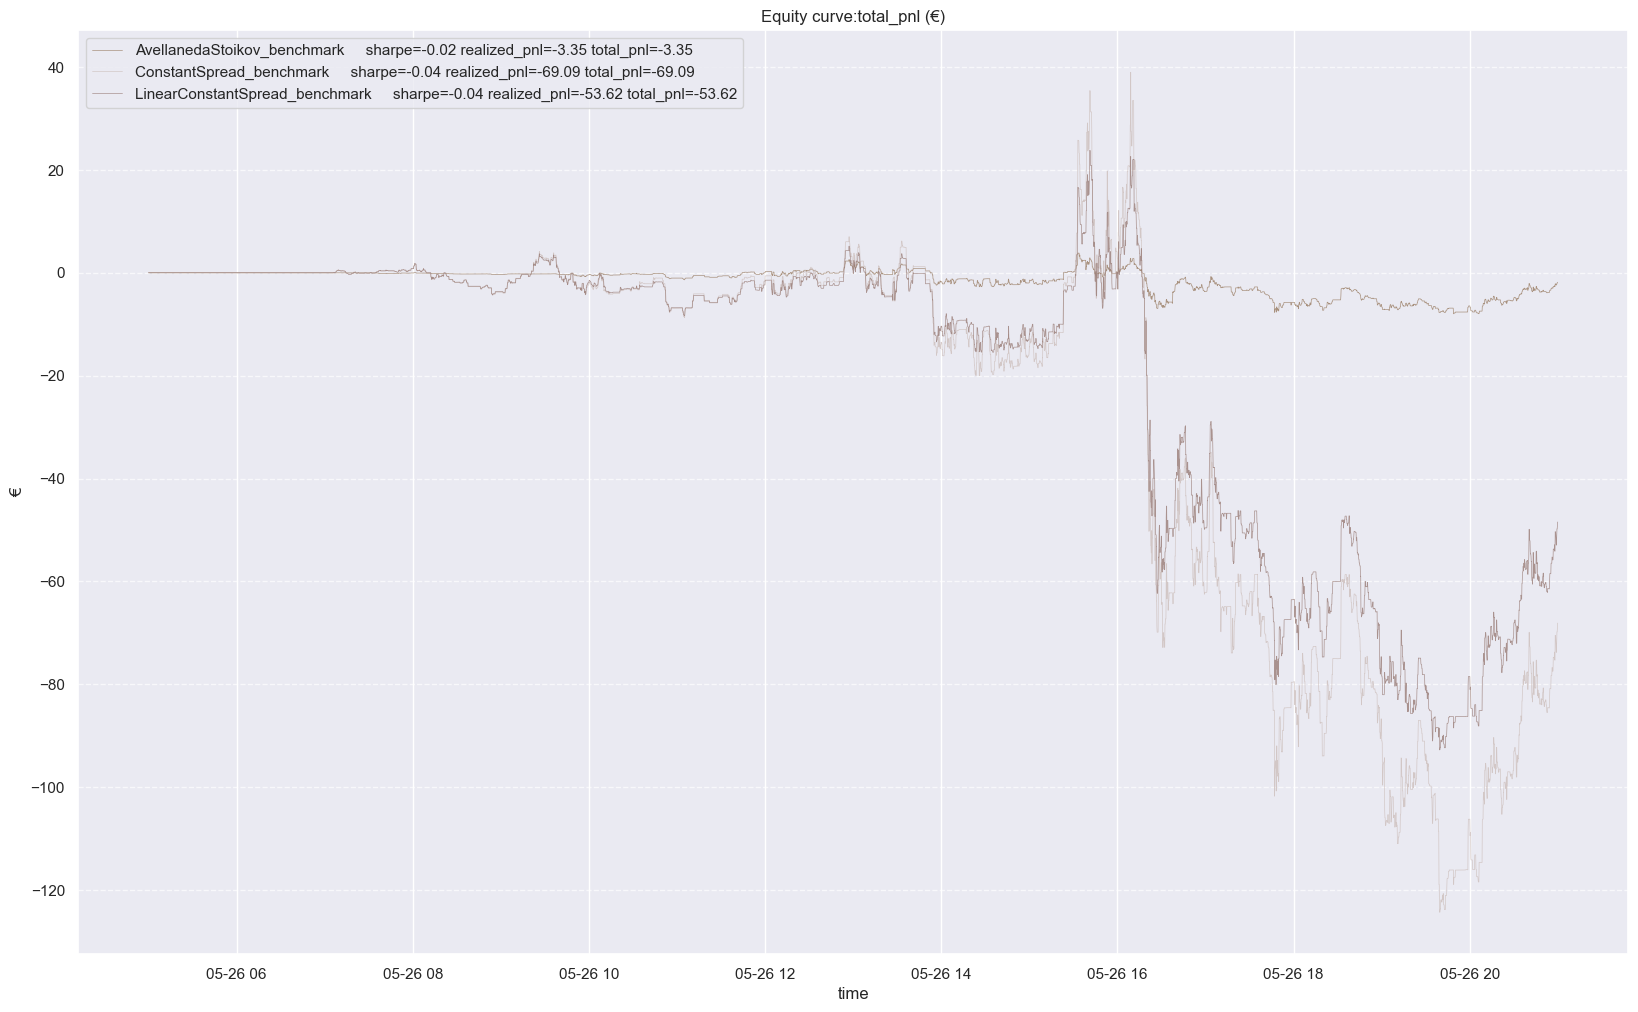

 31%|████████████████████████▊                                                       | 9/29 [35:32<1:16:31, 229.59s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_PPO_

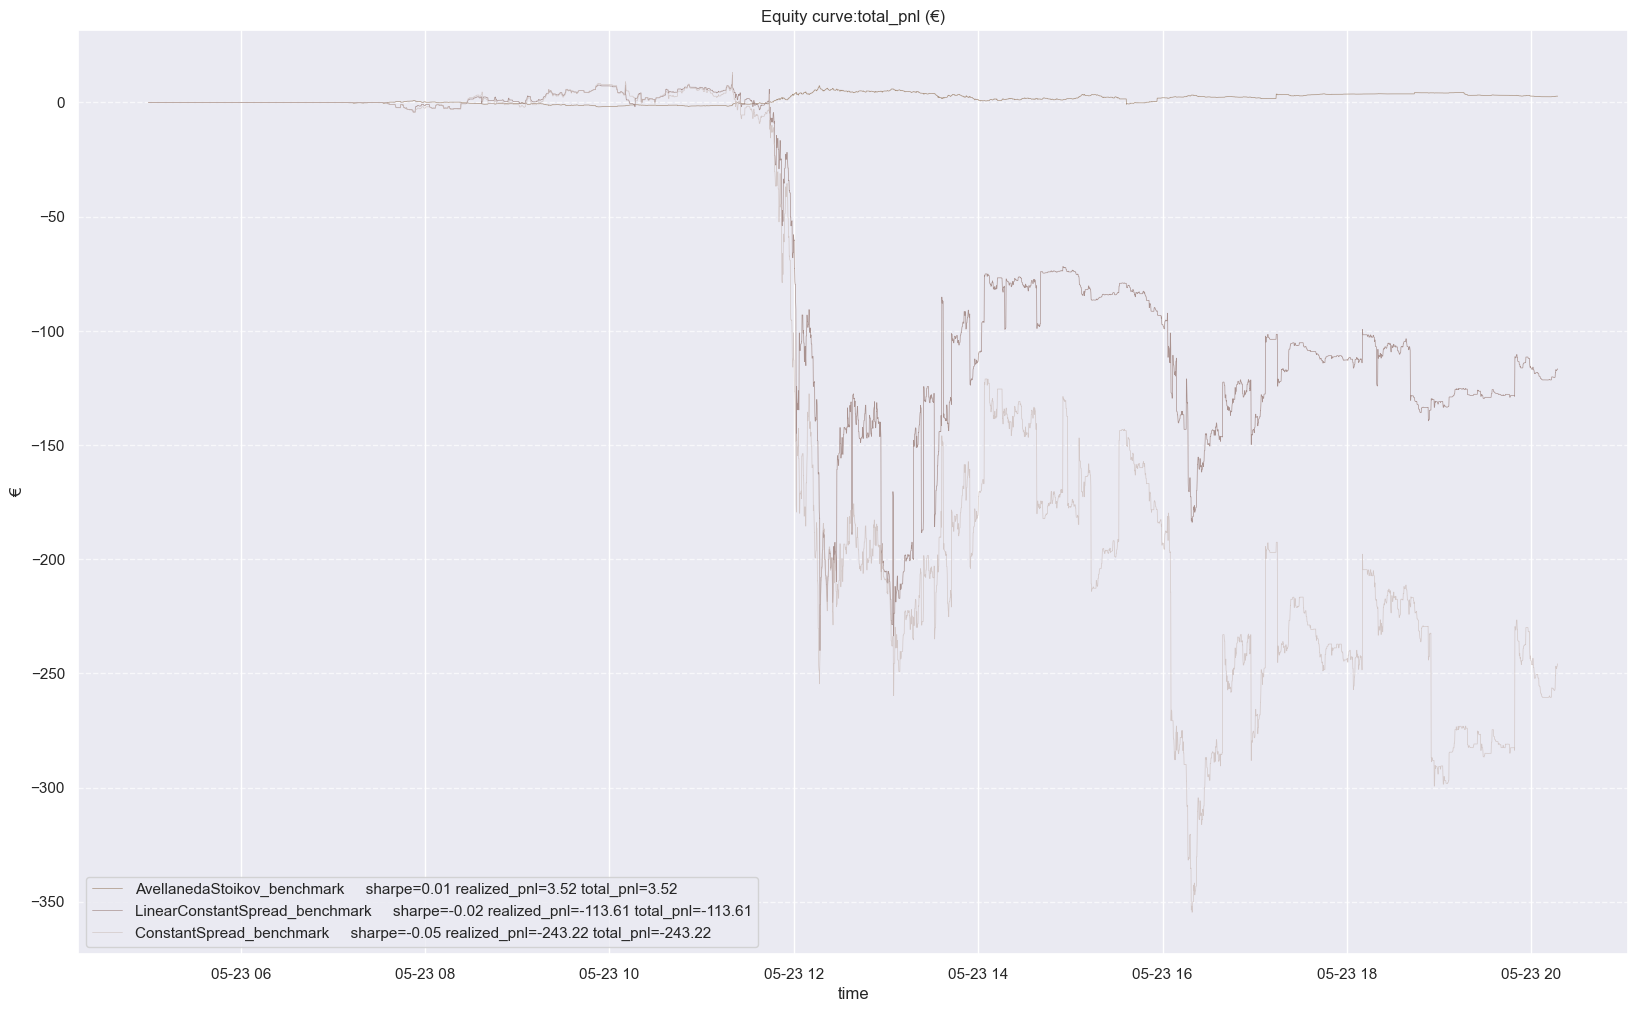

 34%|███████████████████████████▏                                                   | 10/29 [39:32<1:13:41, 232.70s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...

Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_P

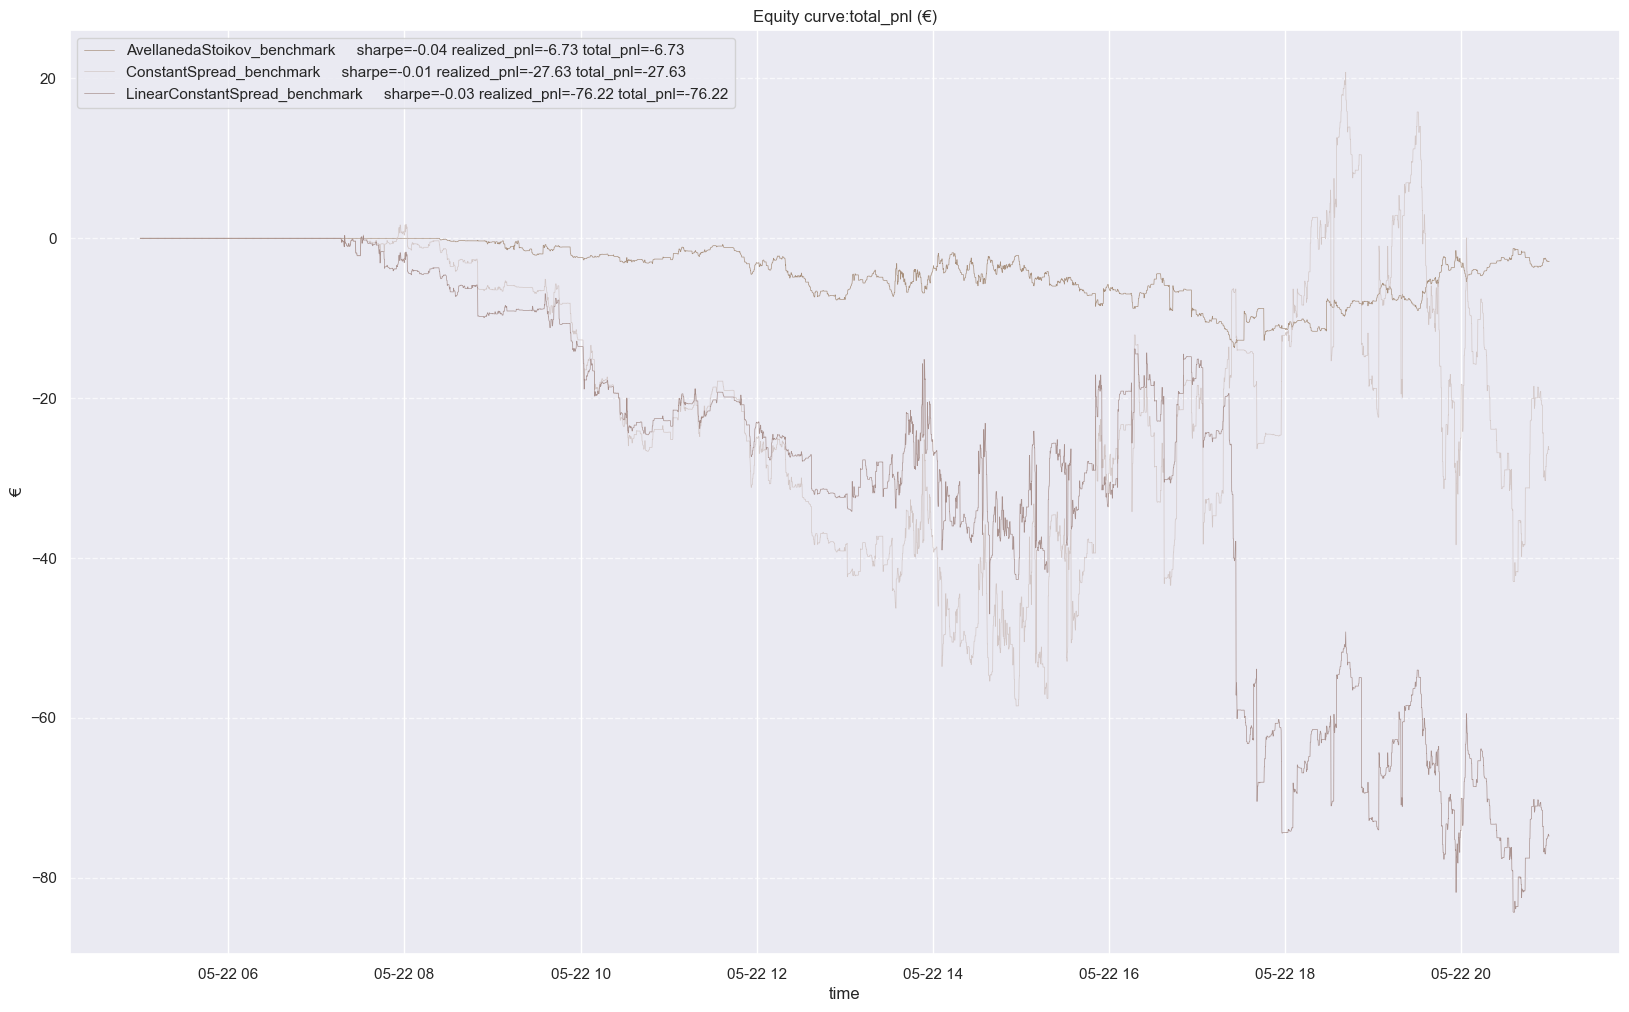

 38%|█████████████████████████████▉                                                 | 11/29 [43:32<1:10:29, 234.94s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_P

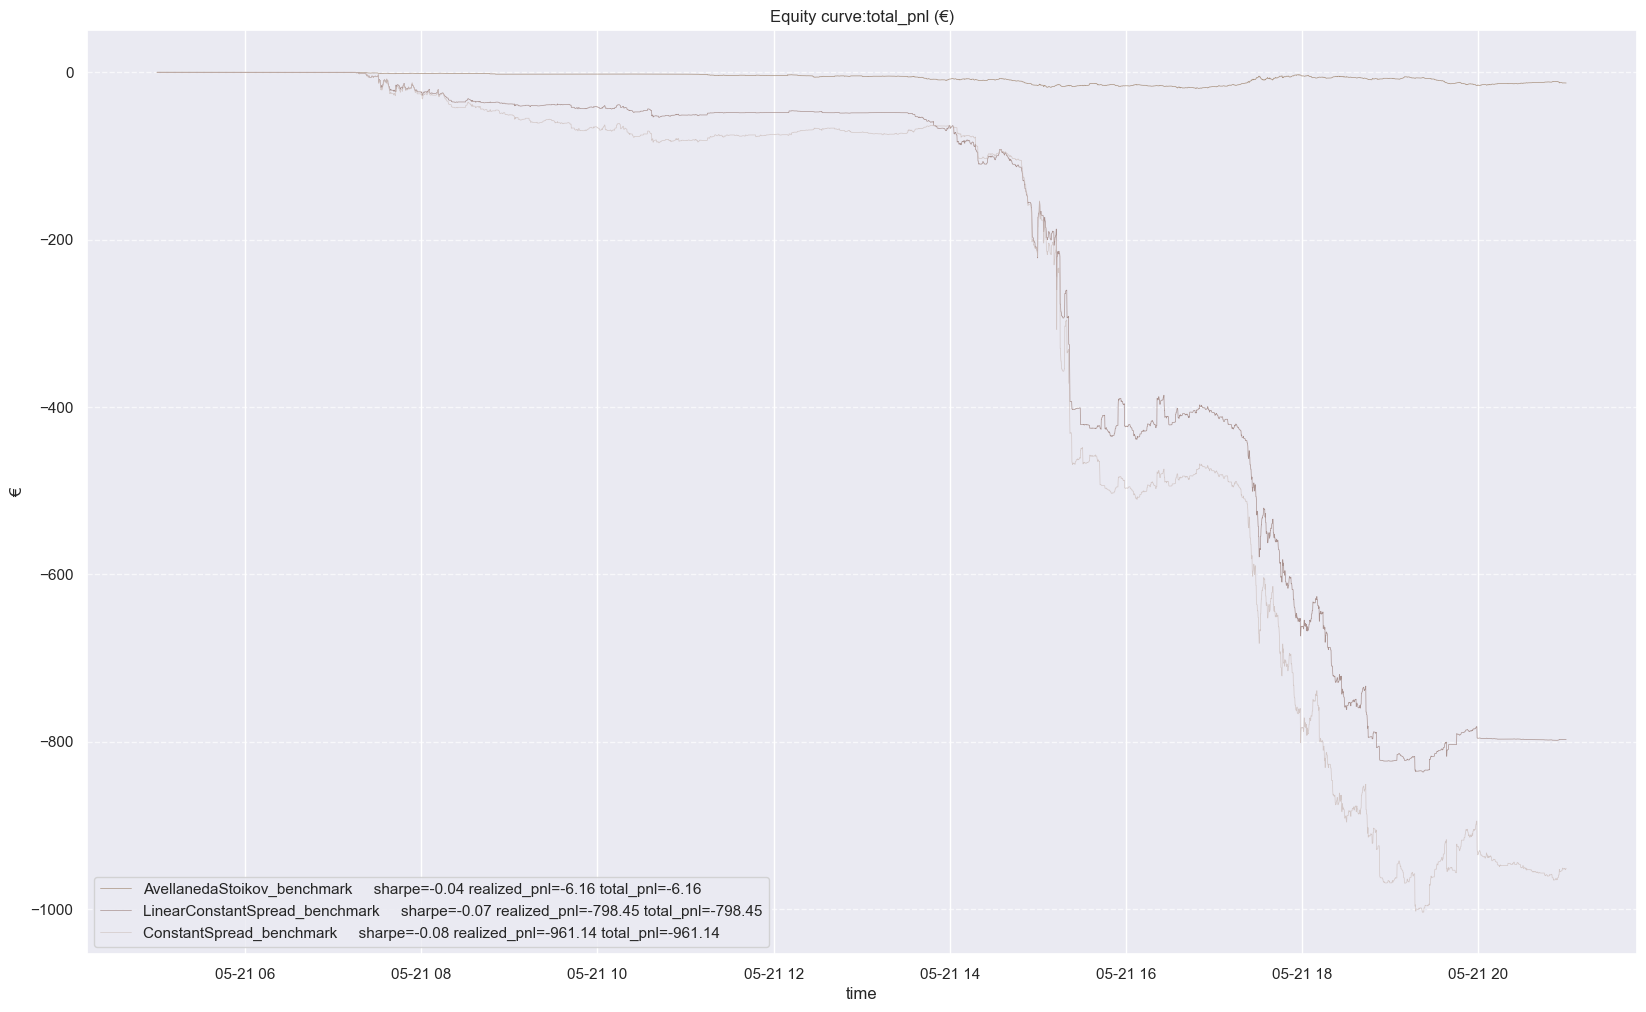

 41%|████████████████████████████████▋                                              | 12/29 [49:00<1:14:36, 263.34s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_PPO_

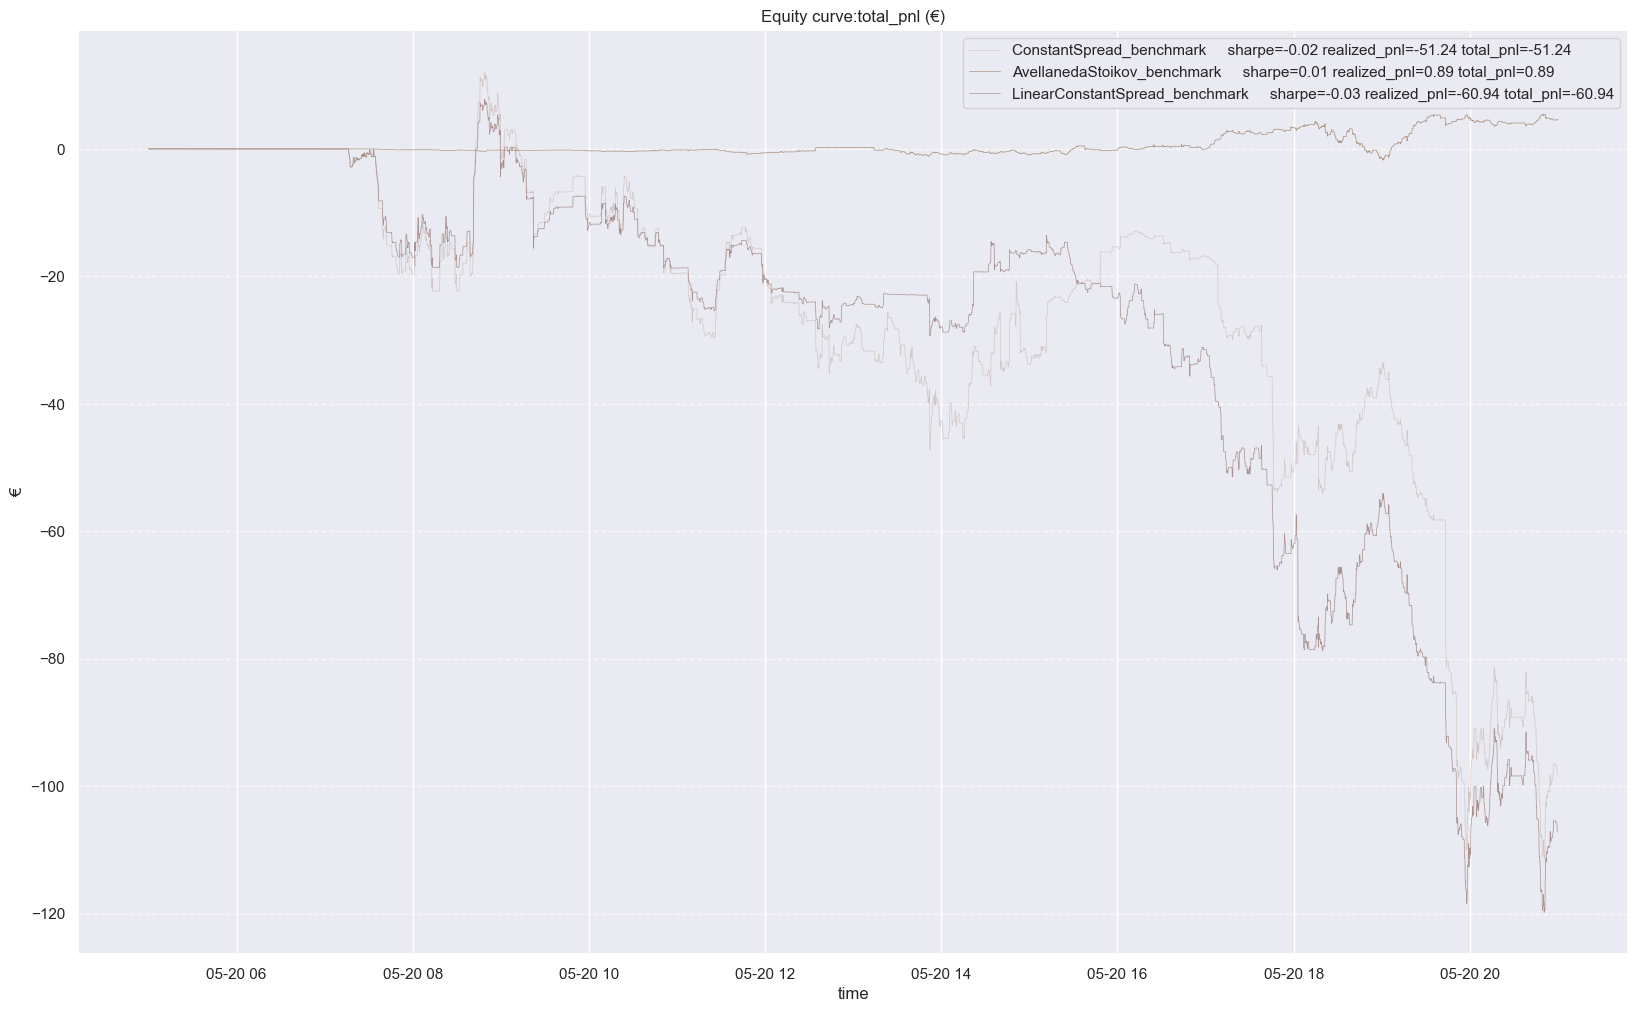

 45%|███████████████████████████████████▍                                           | 13/29 [52:39<1:06:35, 249.71s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_D

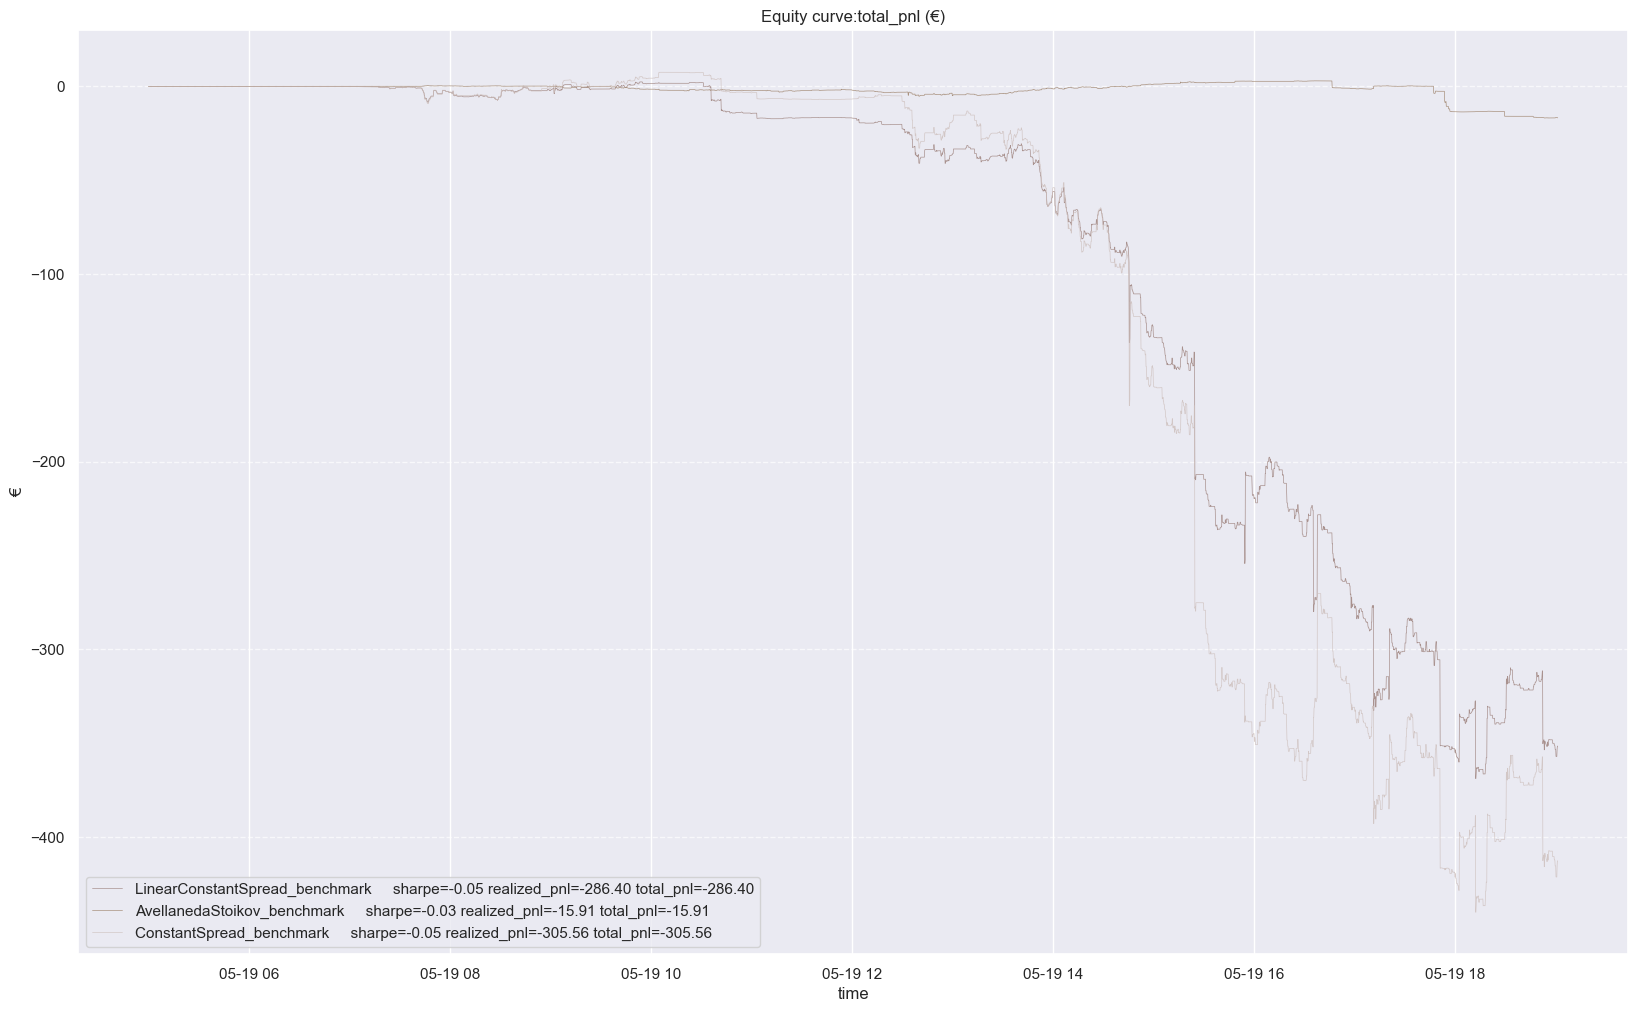

 48%|██████████████████████████████████████▏                                        | 14/29 [56:23<1:00:29, 241.95s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebookspwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...

Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_DQN_

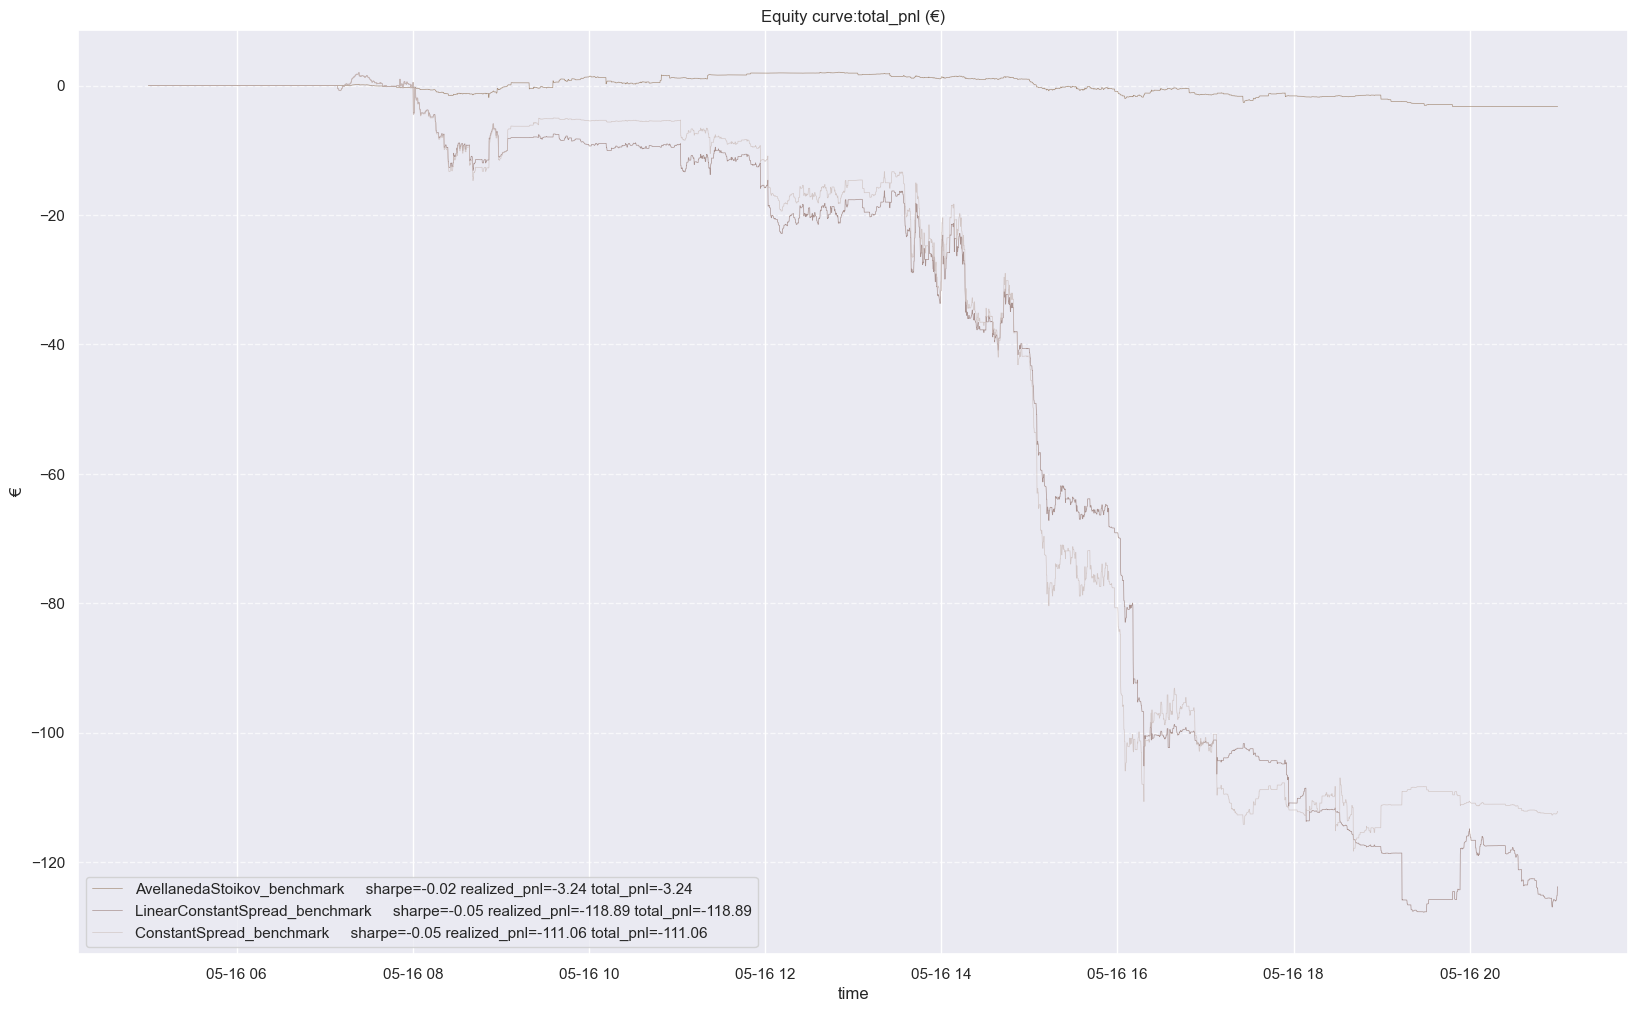

 52%|████████████████████████████████████████▊                                      | 15/29 [1:00:20<56:09, 240.66s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_P

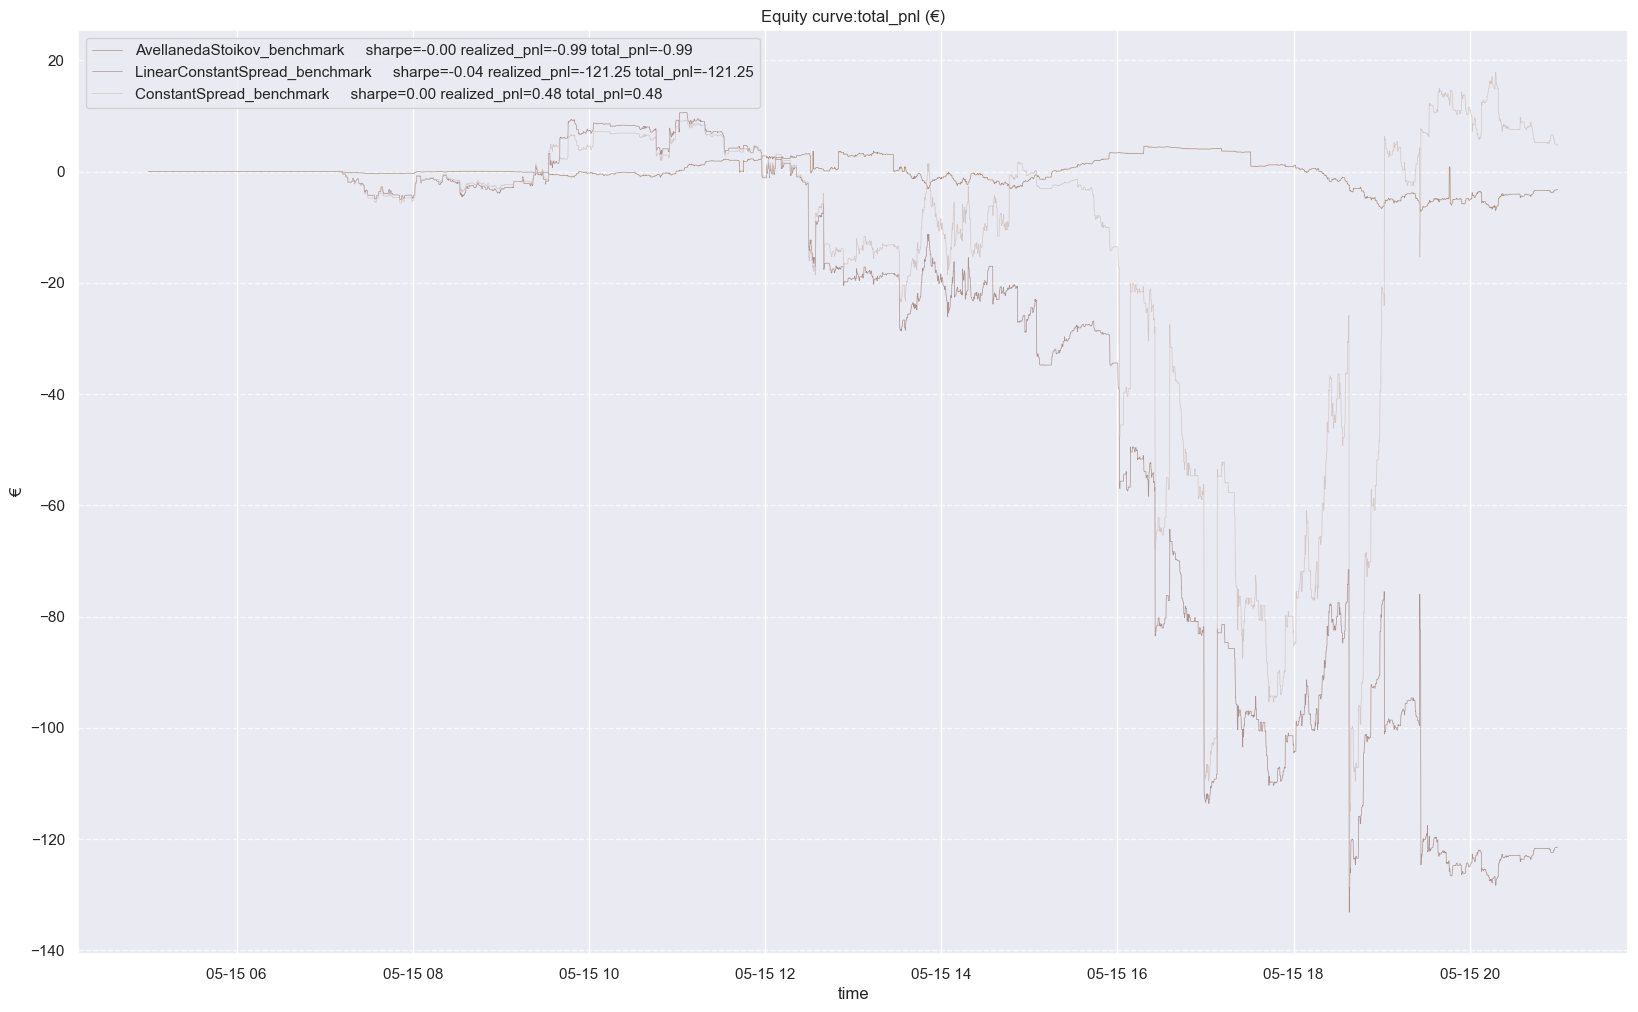

 55%|███████████████████████████████████████████▌                                   | 16/29 [1:05:19<55:55, 258.09s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_PPO_

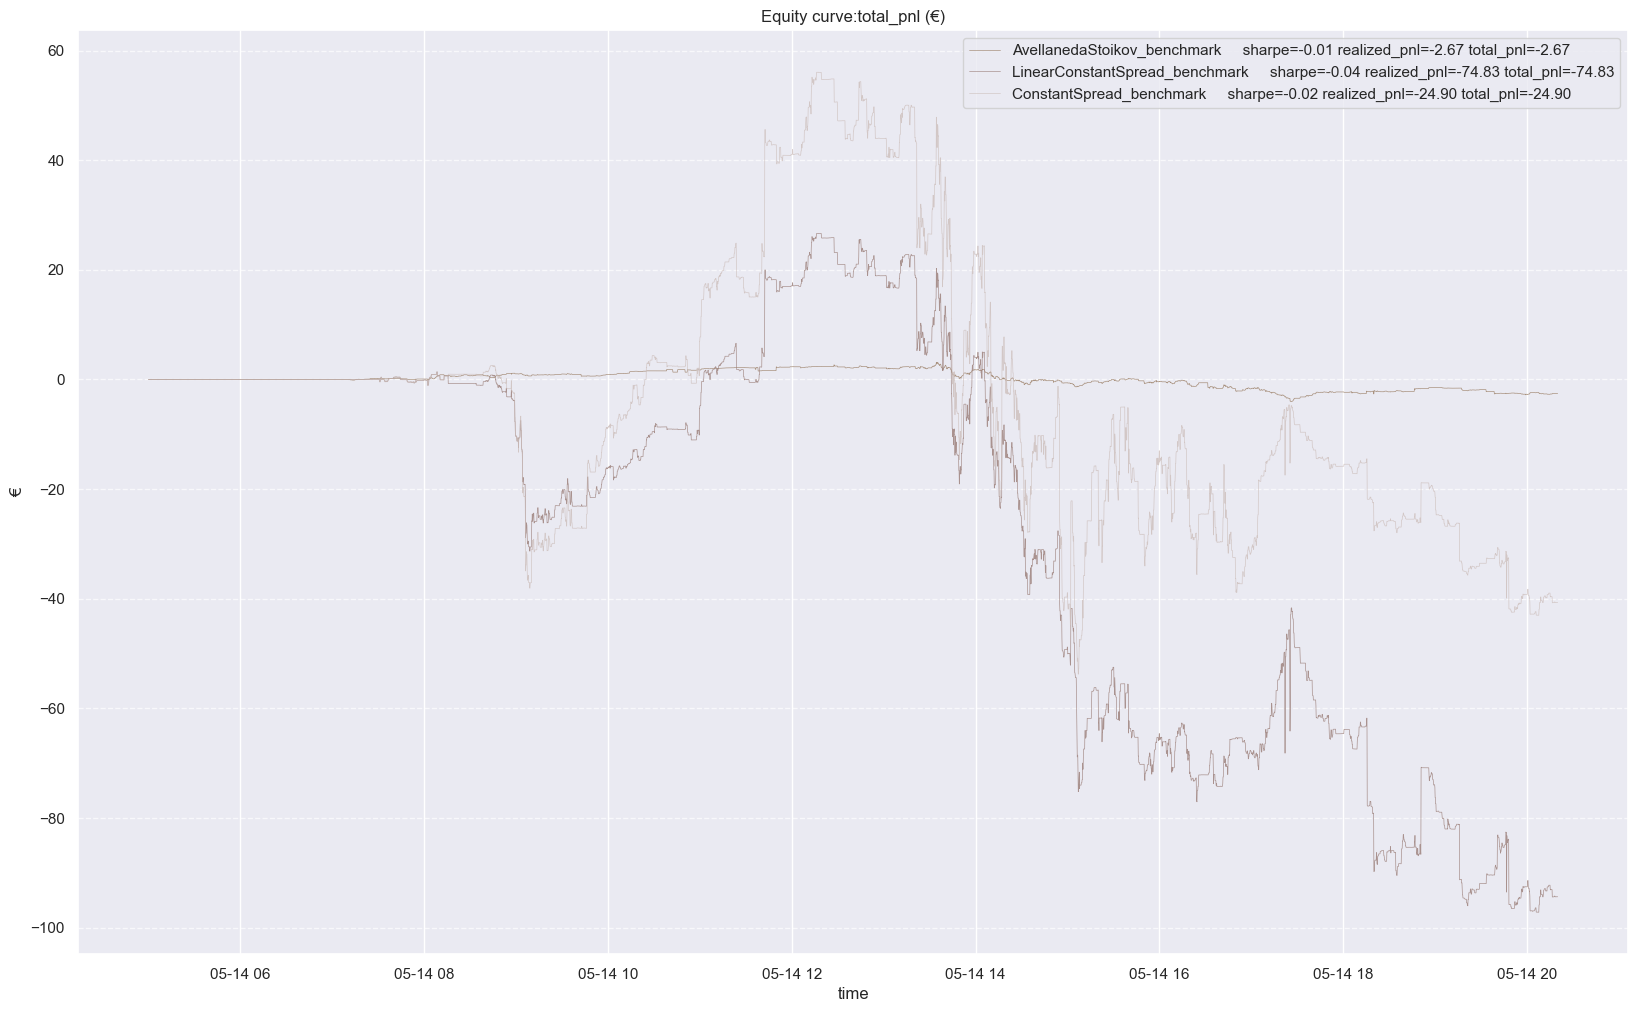

 59%|██████████████████████████████████████████████▎                                | 17/29 [1:09:12<50:06, 250.54s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebookspwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks

Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_P

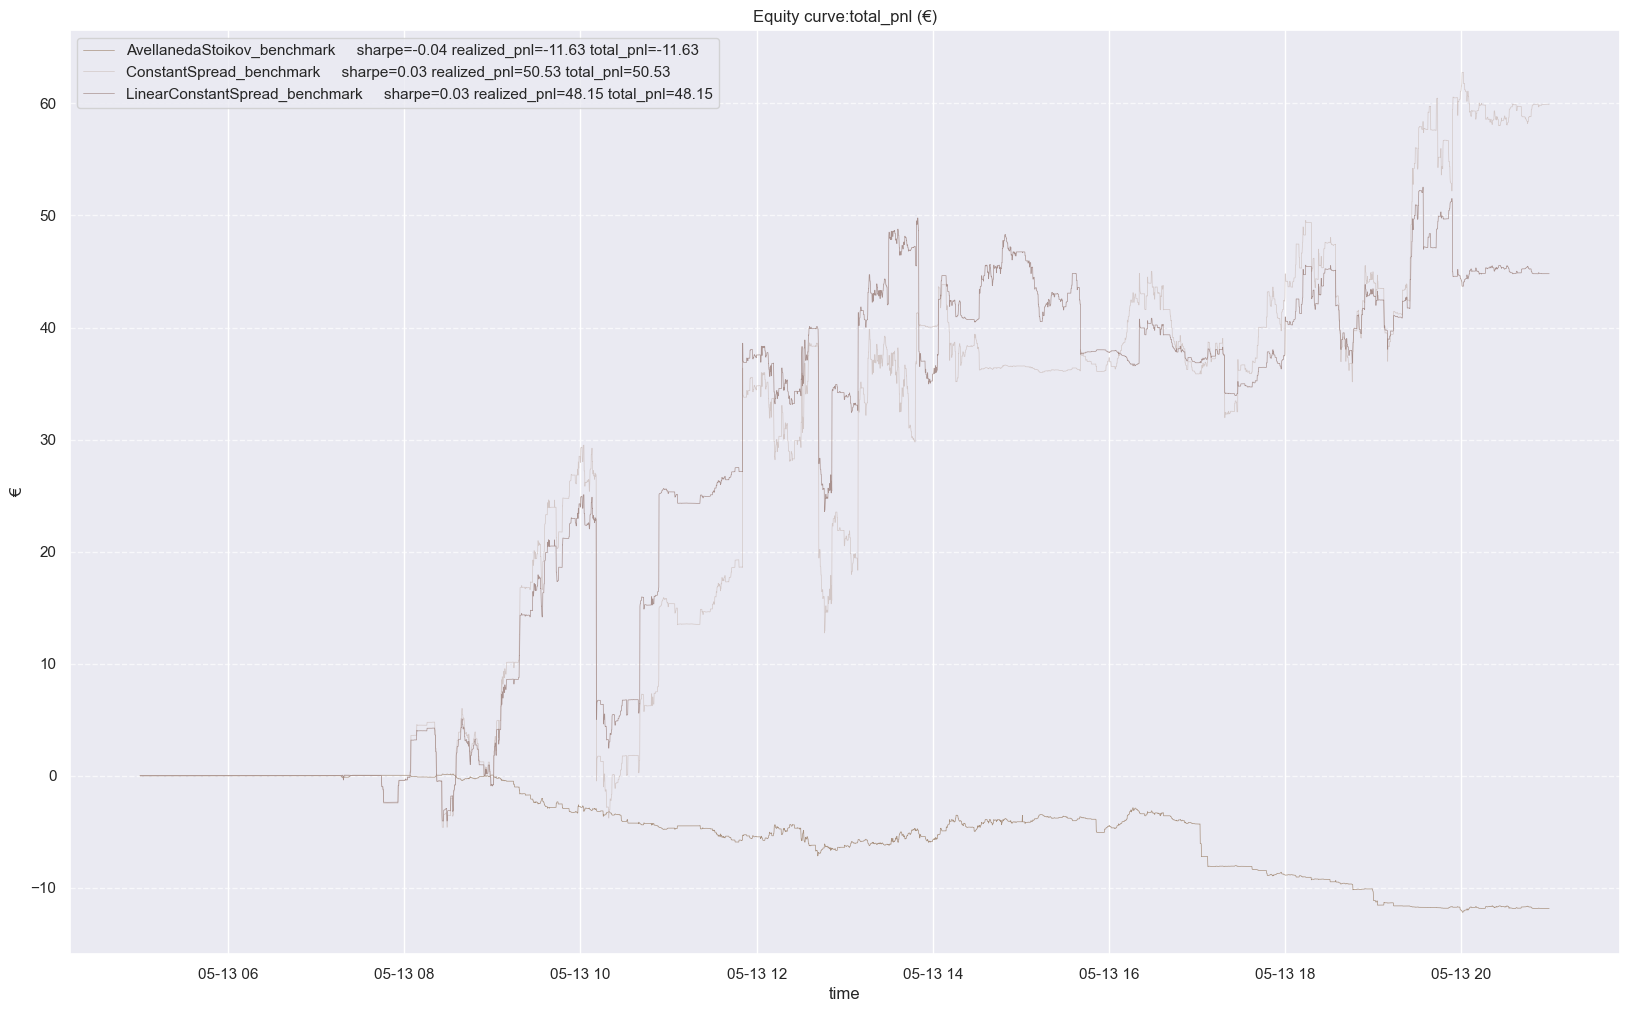

 62%|█████████████████████████████████████████████████                              | 18/29 [1:12:59<44:39, 243.63s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...

Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_PPO_

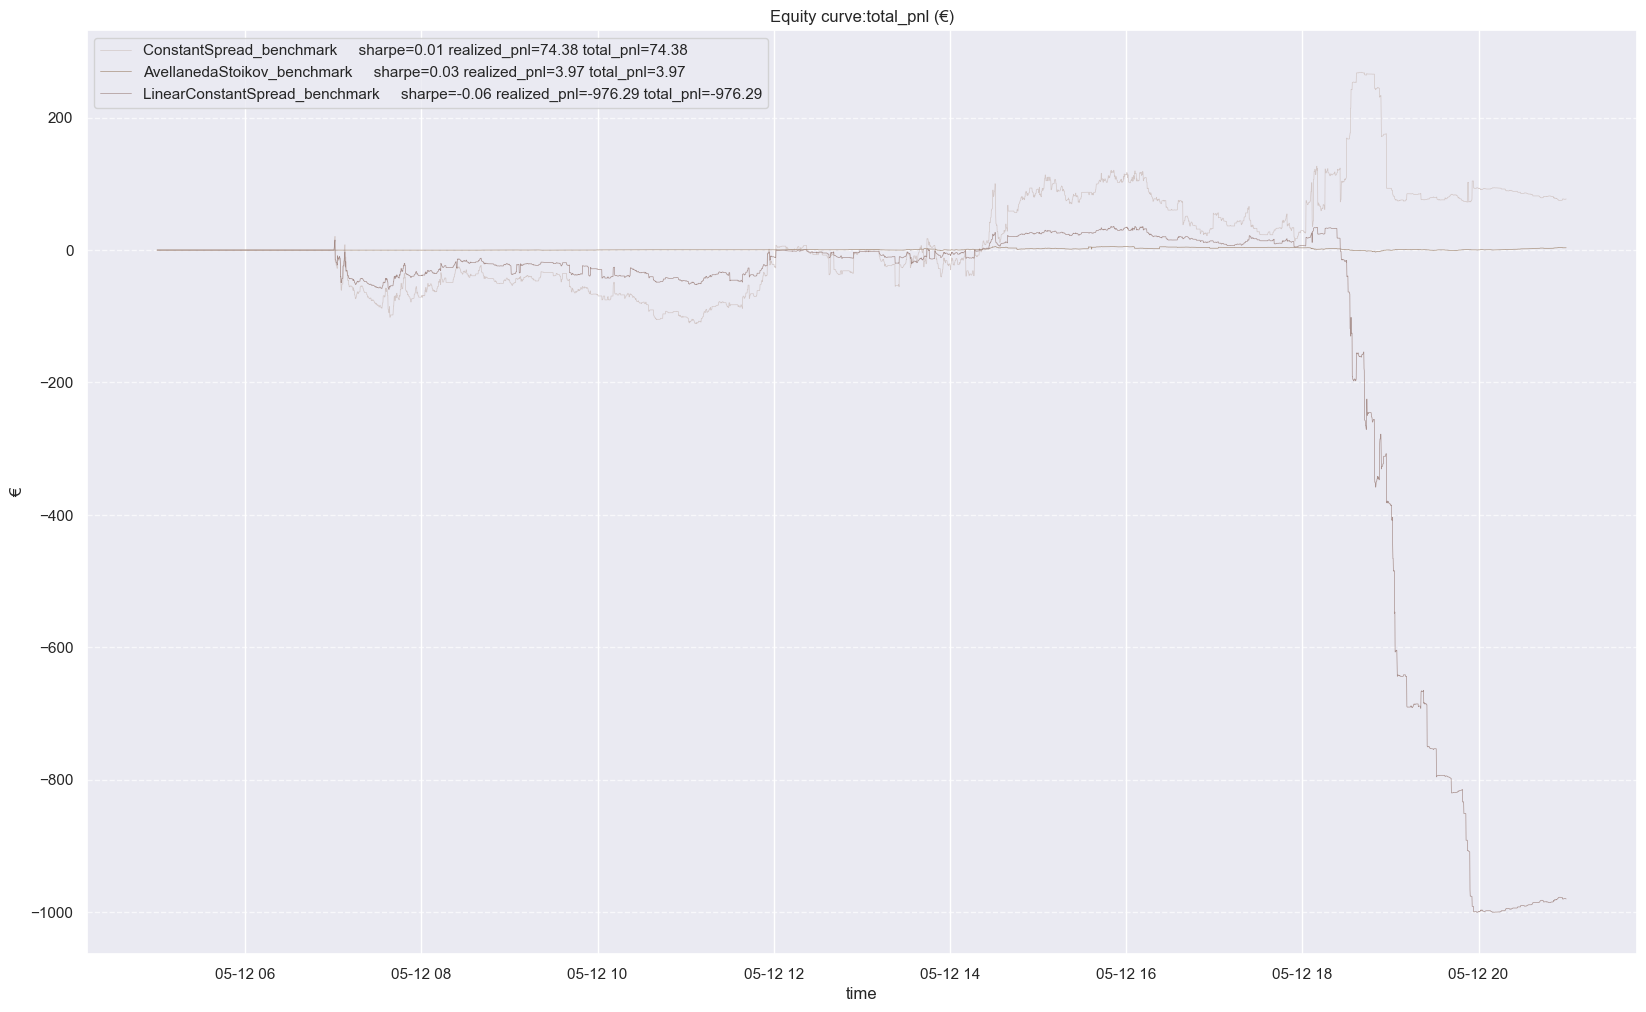

 66%|███████████████████████████████████████████████████▊                           | 19/29 [1:17:32<42:03, 252.39s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...

Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_D

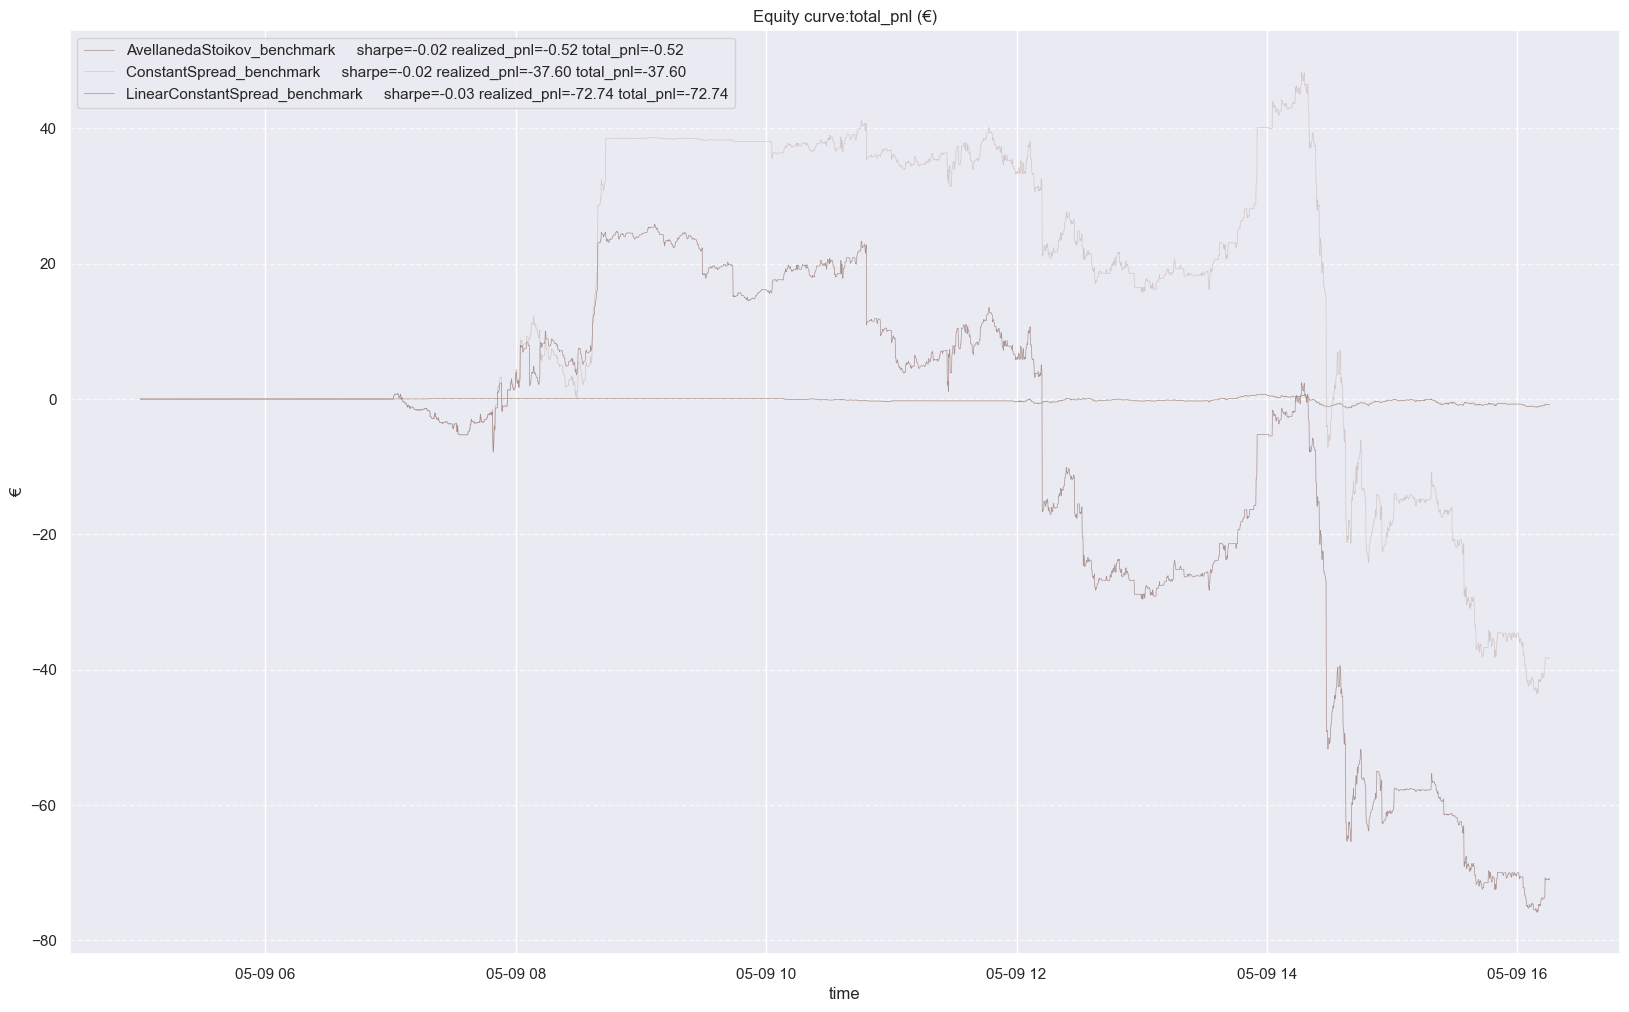

 69%|██████████████████████████████████████████████████████▍                        | 20/29 [1:21:46<37:56, 252.91s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_D

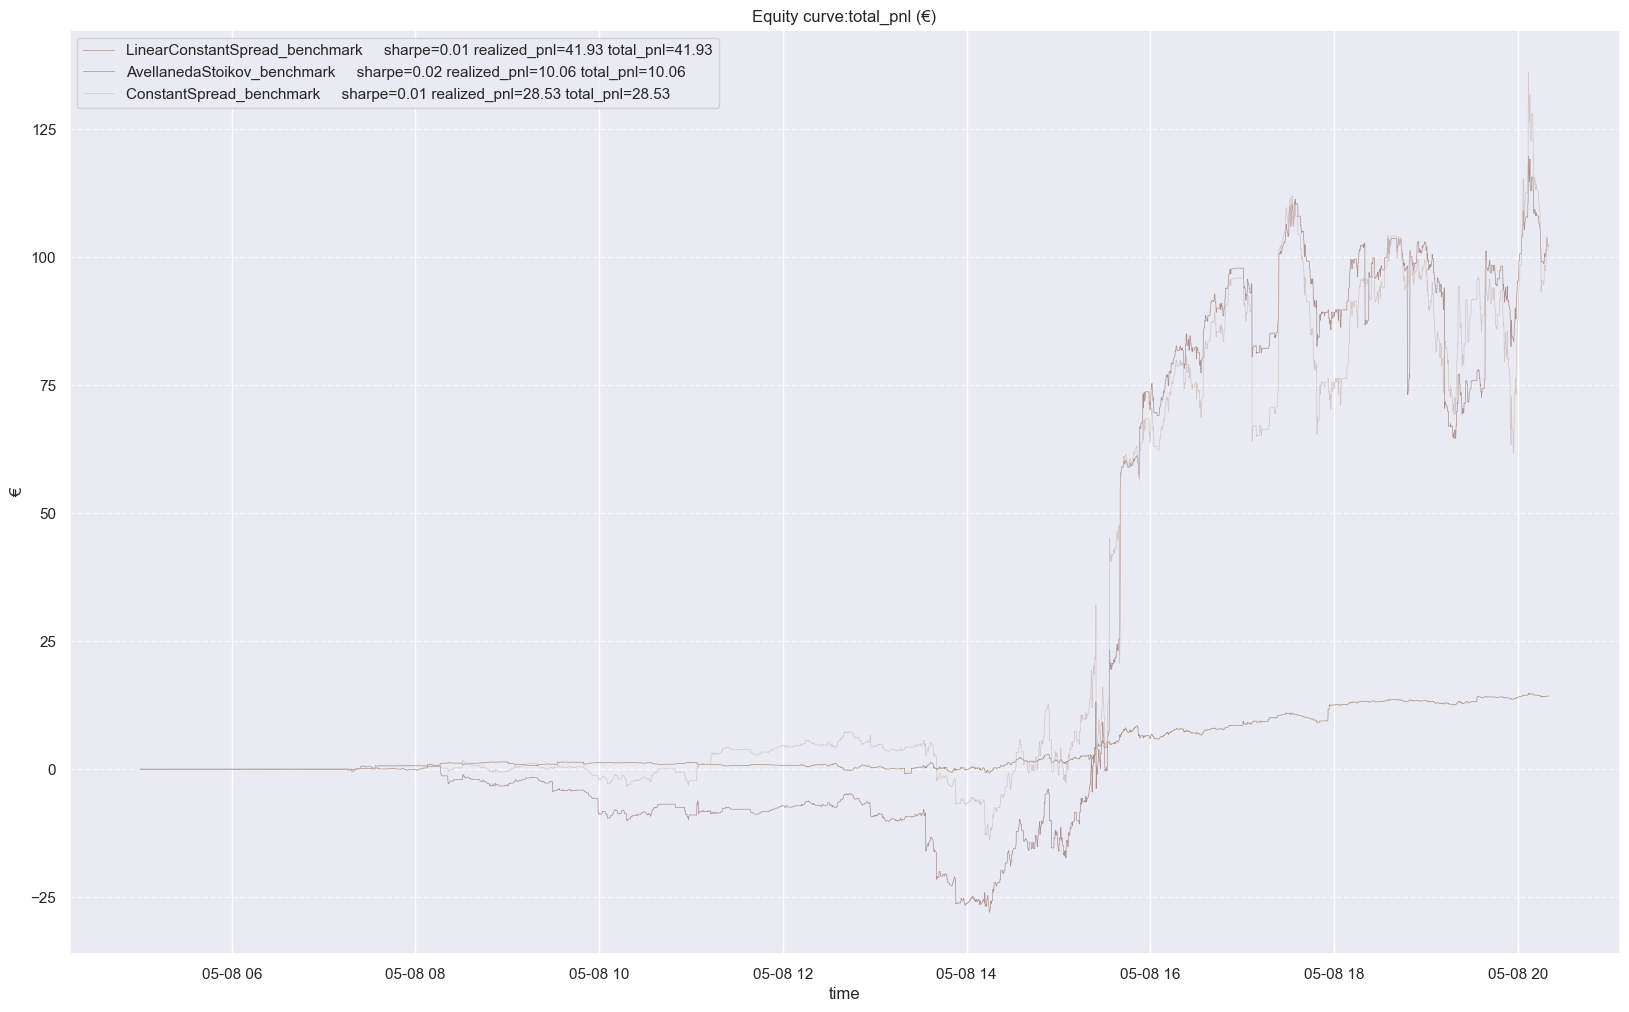

 72%|█████████████████████████████████████████████████████████▏                     | 21/29 [1:25:16<32:00, 240.03s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...

Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_PPO_

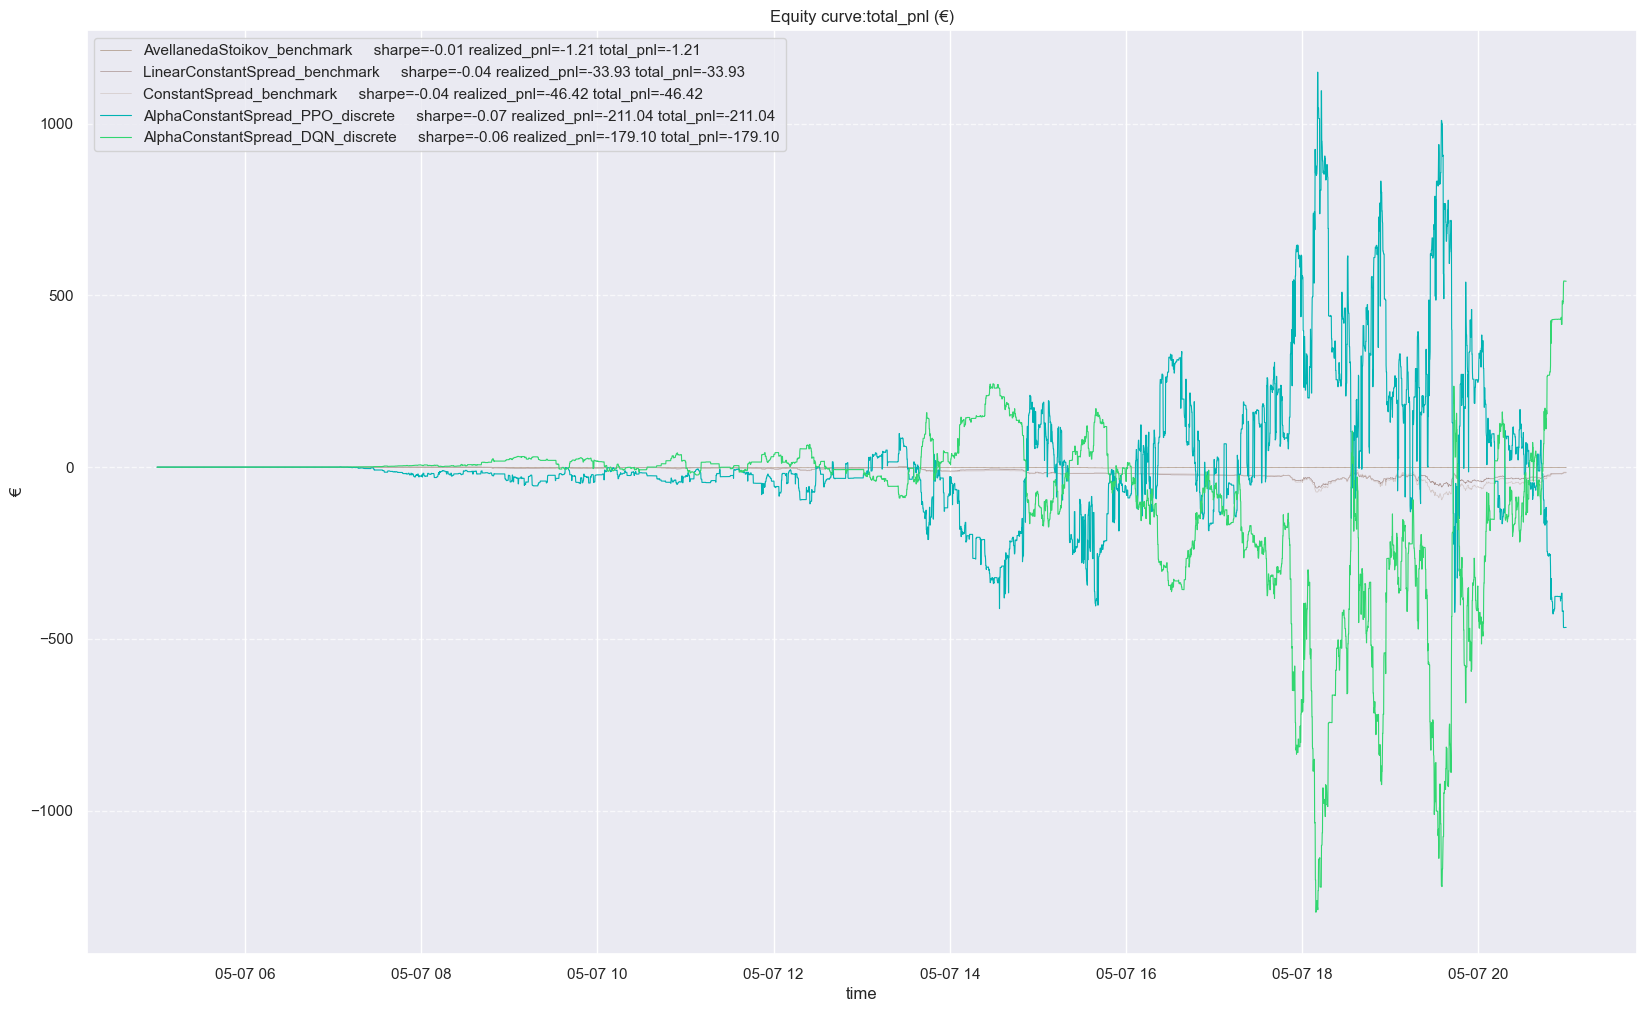

 76%|███████████████████████████████████████████████████████████▉                   | 22/29 [1:29:56<29:23, 251.87s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_PPO_

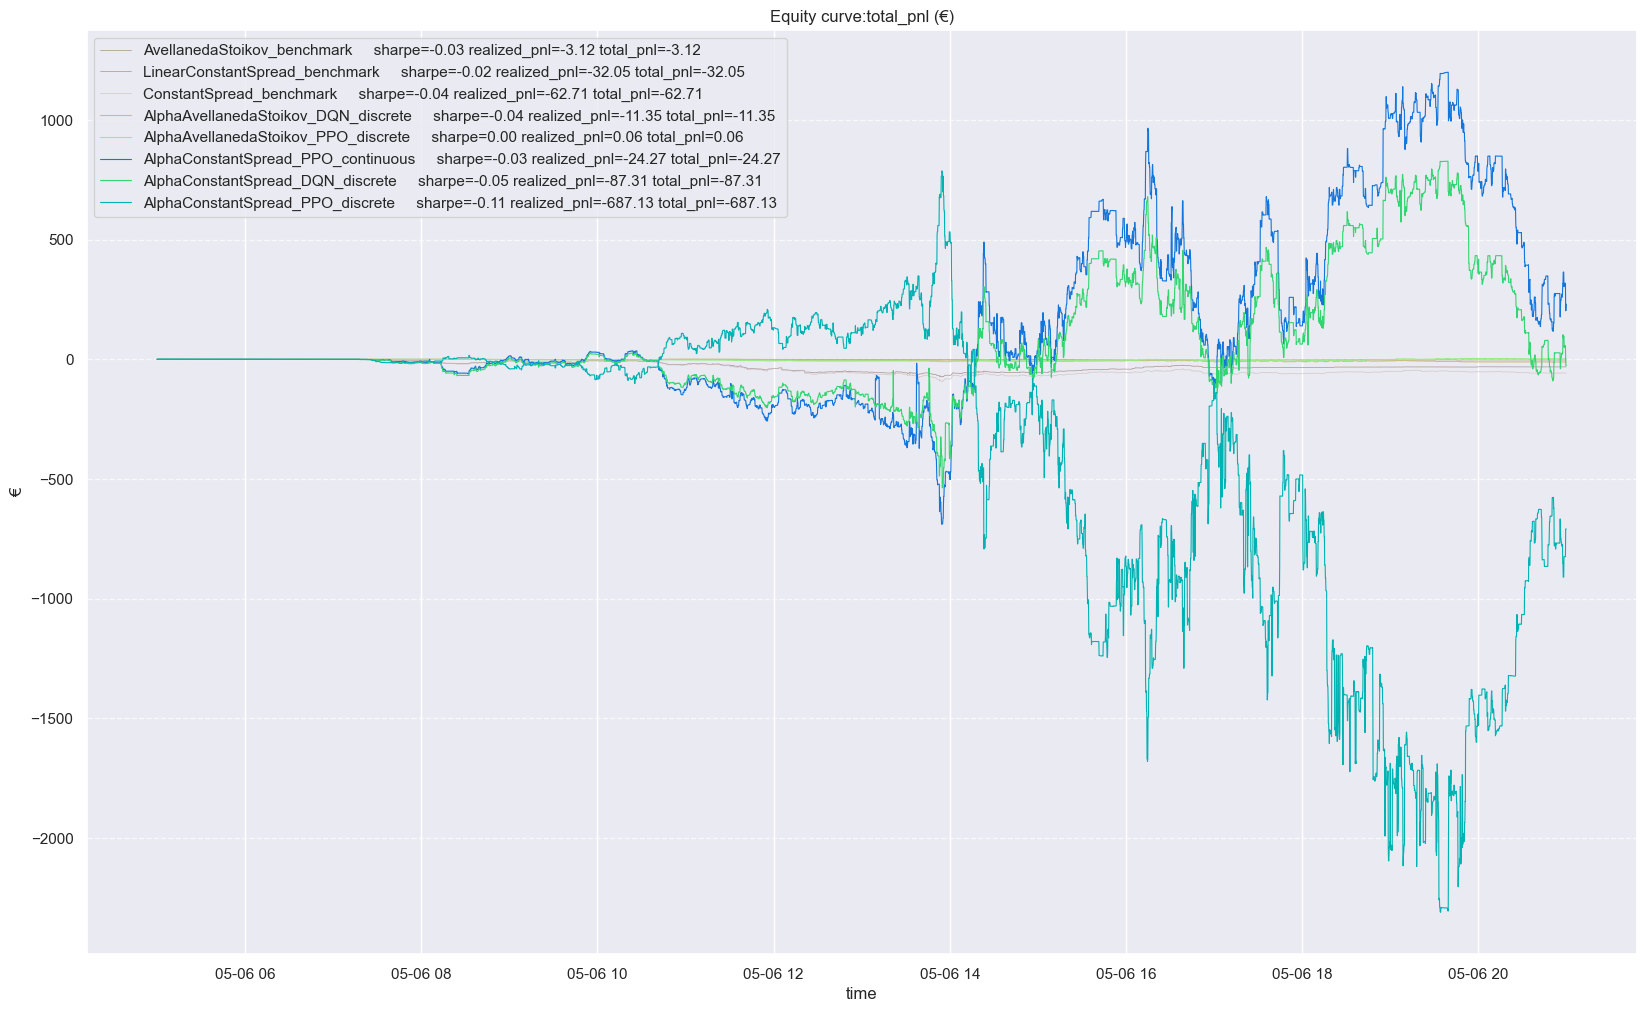

 79%|██████████████████████████████████████████████████████████████▋                | 23/29 [1:35:51<28:18, 283.01s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_P

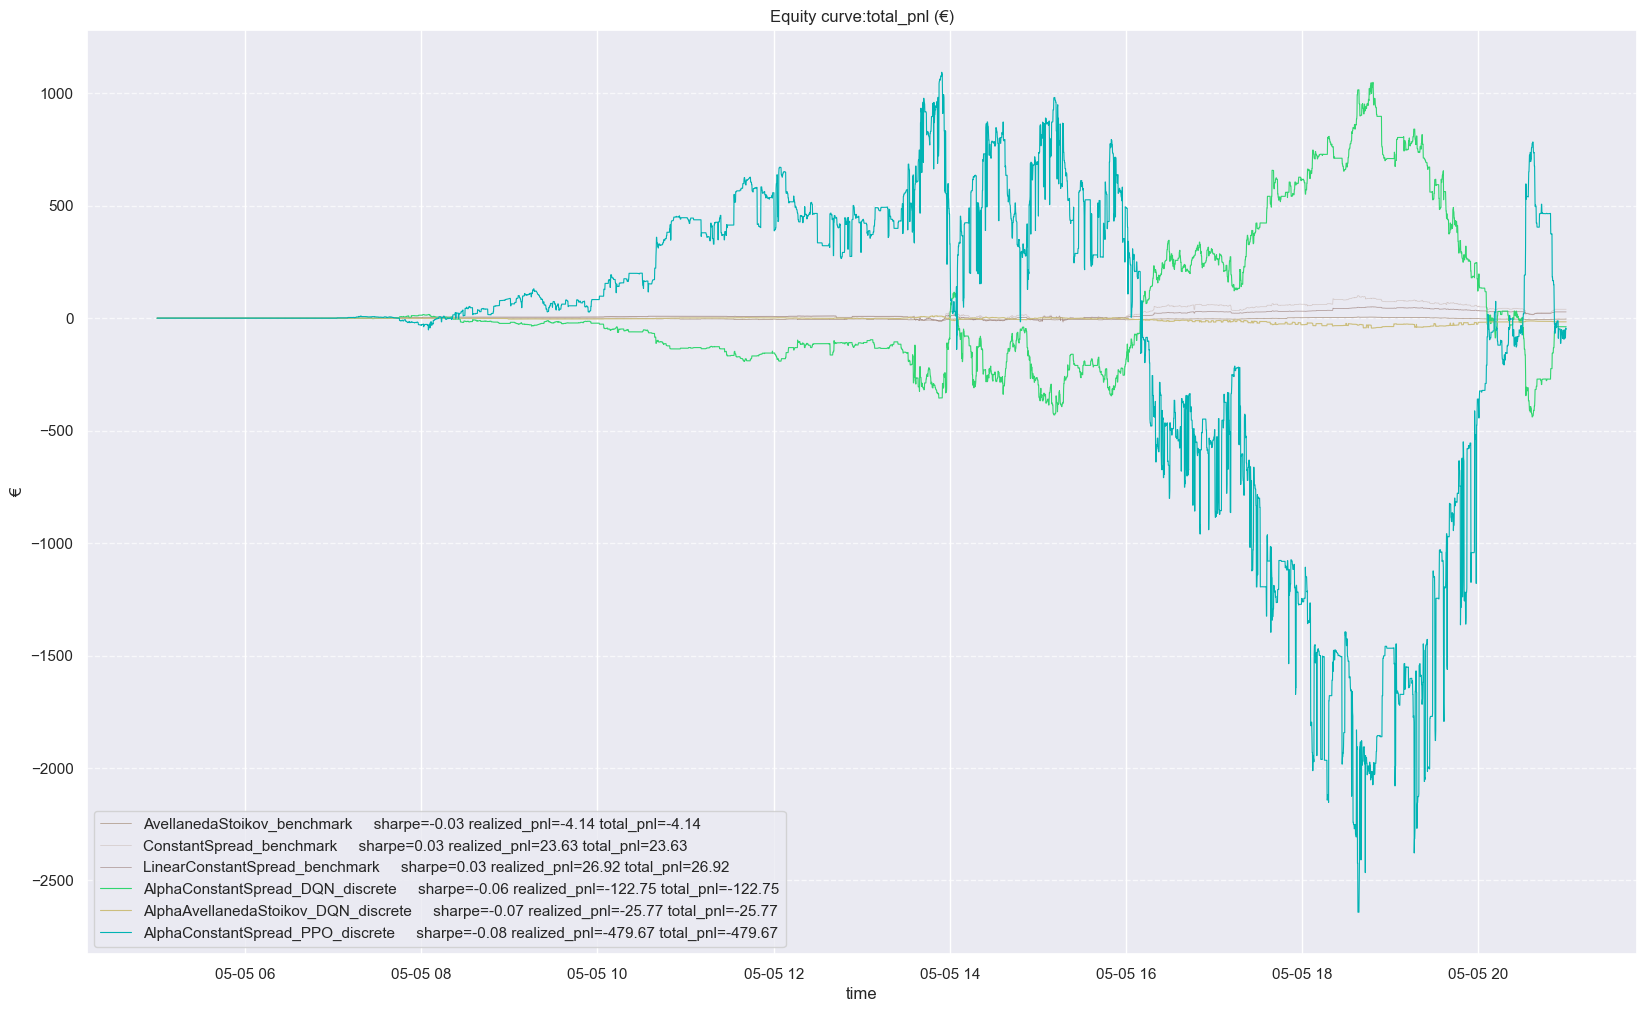

 83%|█████████████████████████████████████████████████████████████████▍             | 24/29 [1:40:52<24:01, 288.29s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_D

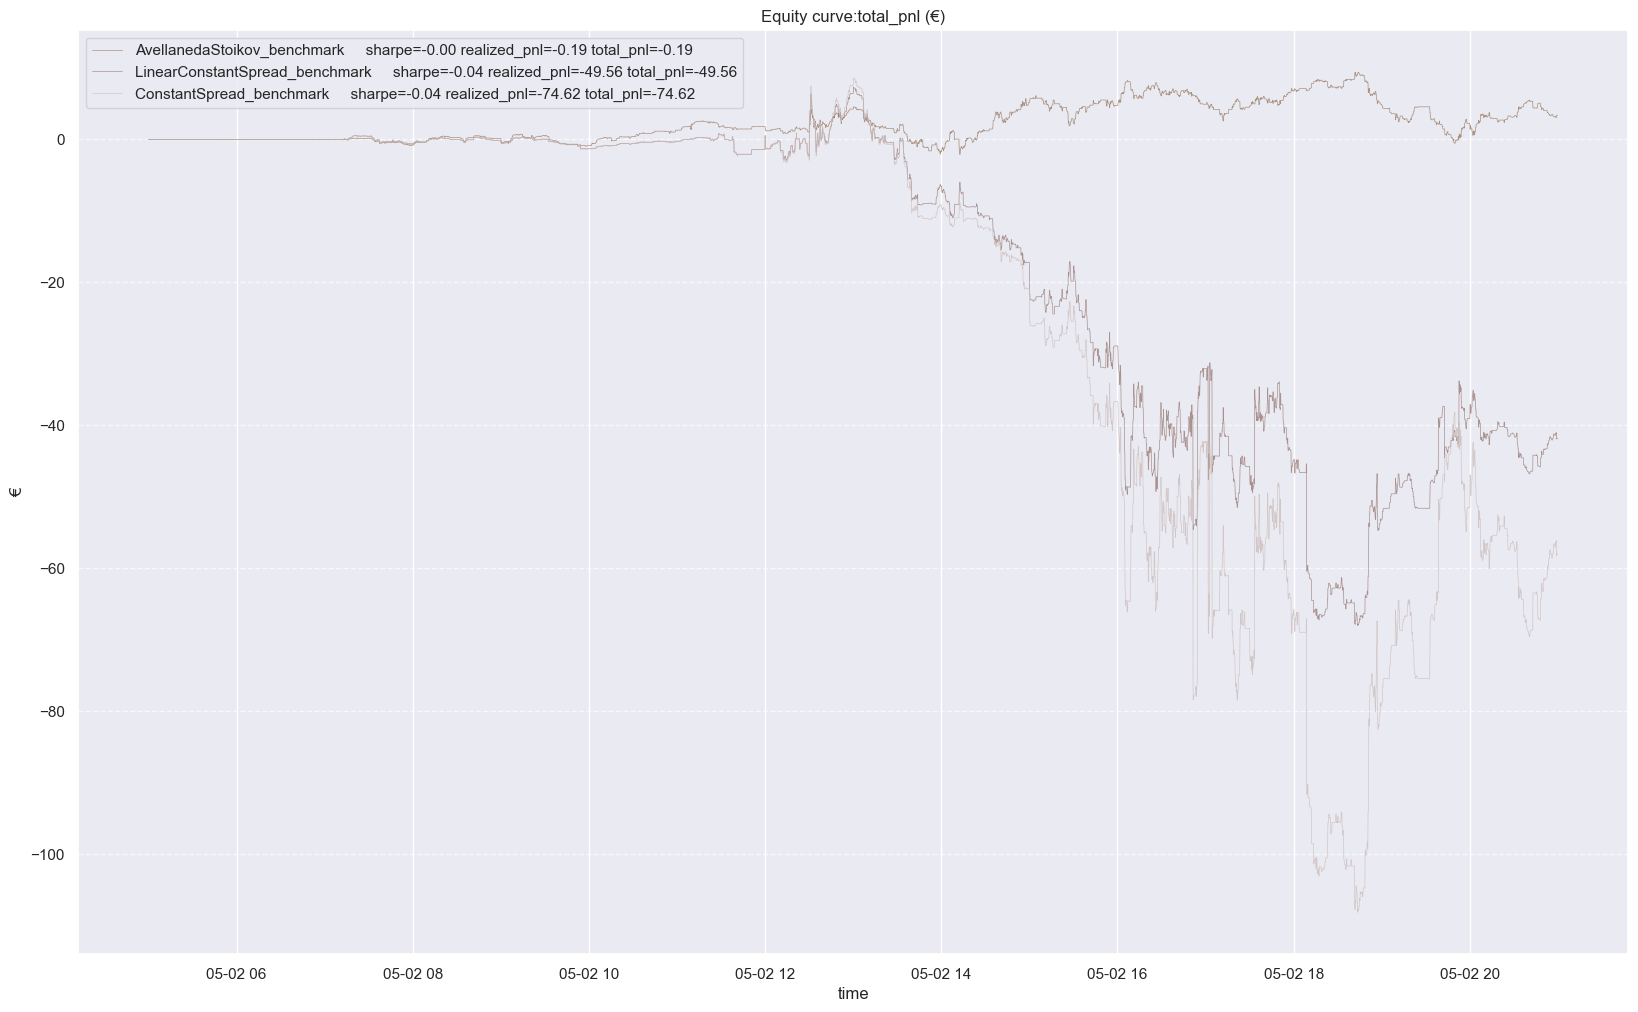

 86%|████████████████████████████████████████████████████████████████████           | 25/29 [1:44:43<18:04, 271.02s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_P

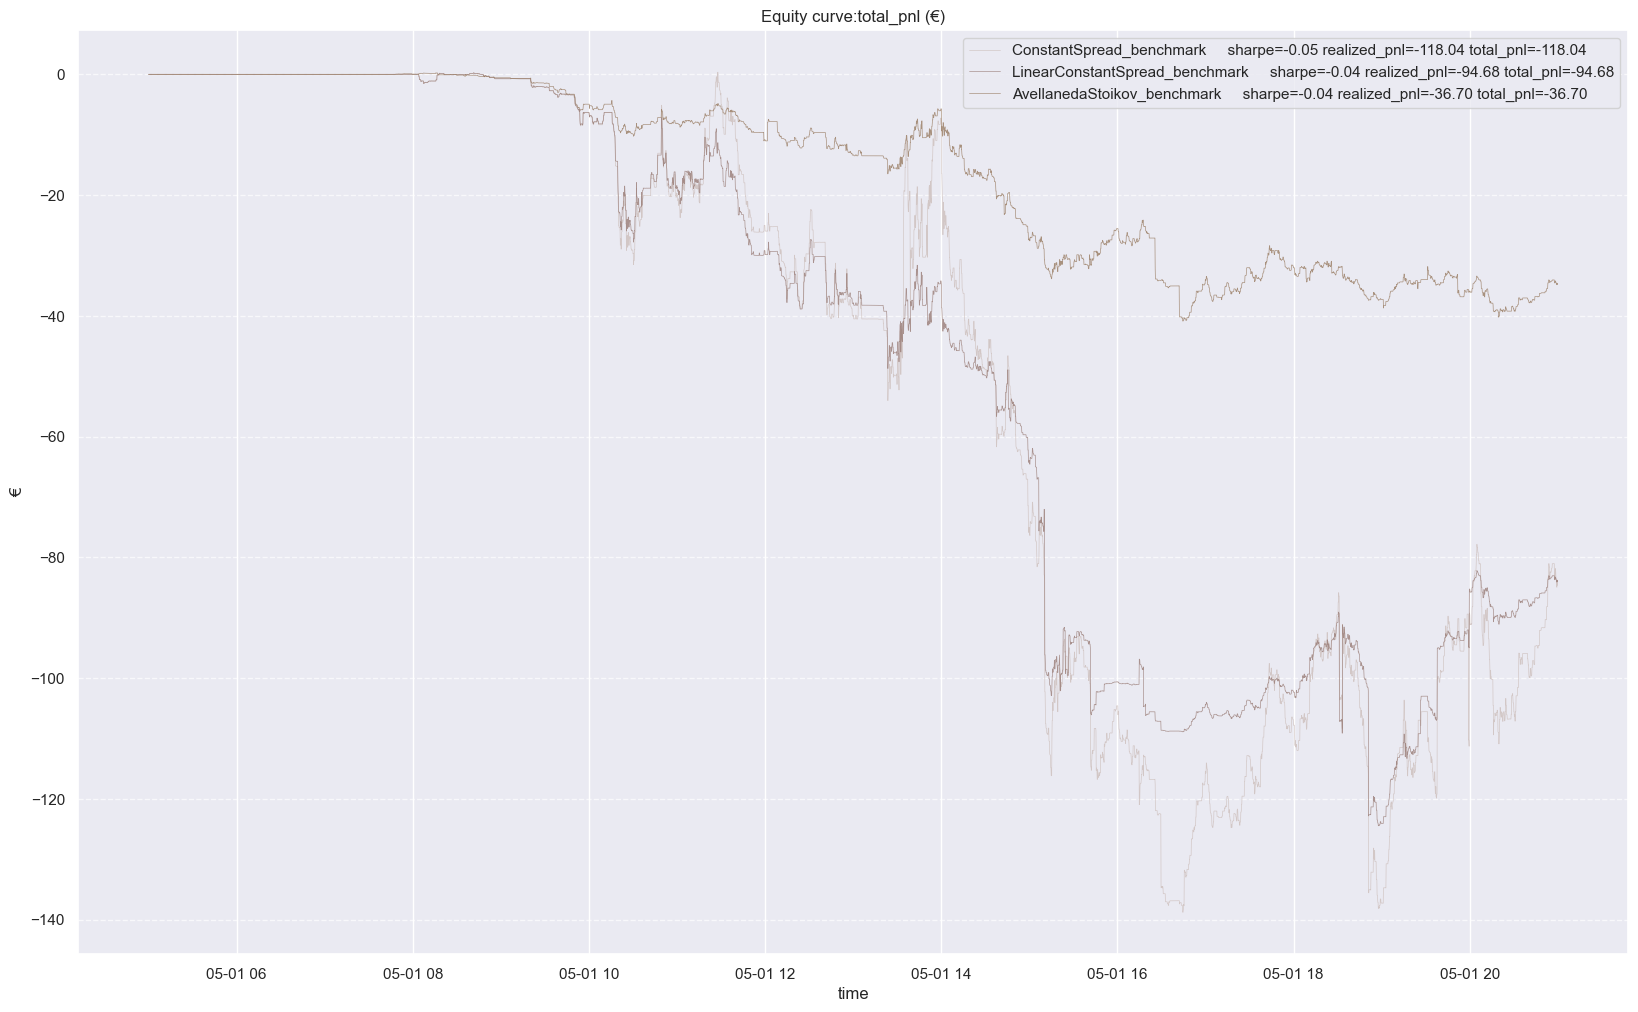

 90%|██████████████████████████████████████████████████████████████████████▊        | 26/29 [1:48:35<12:57, 259.30s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_P

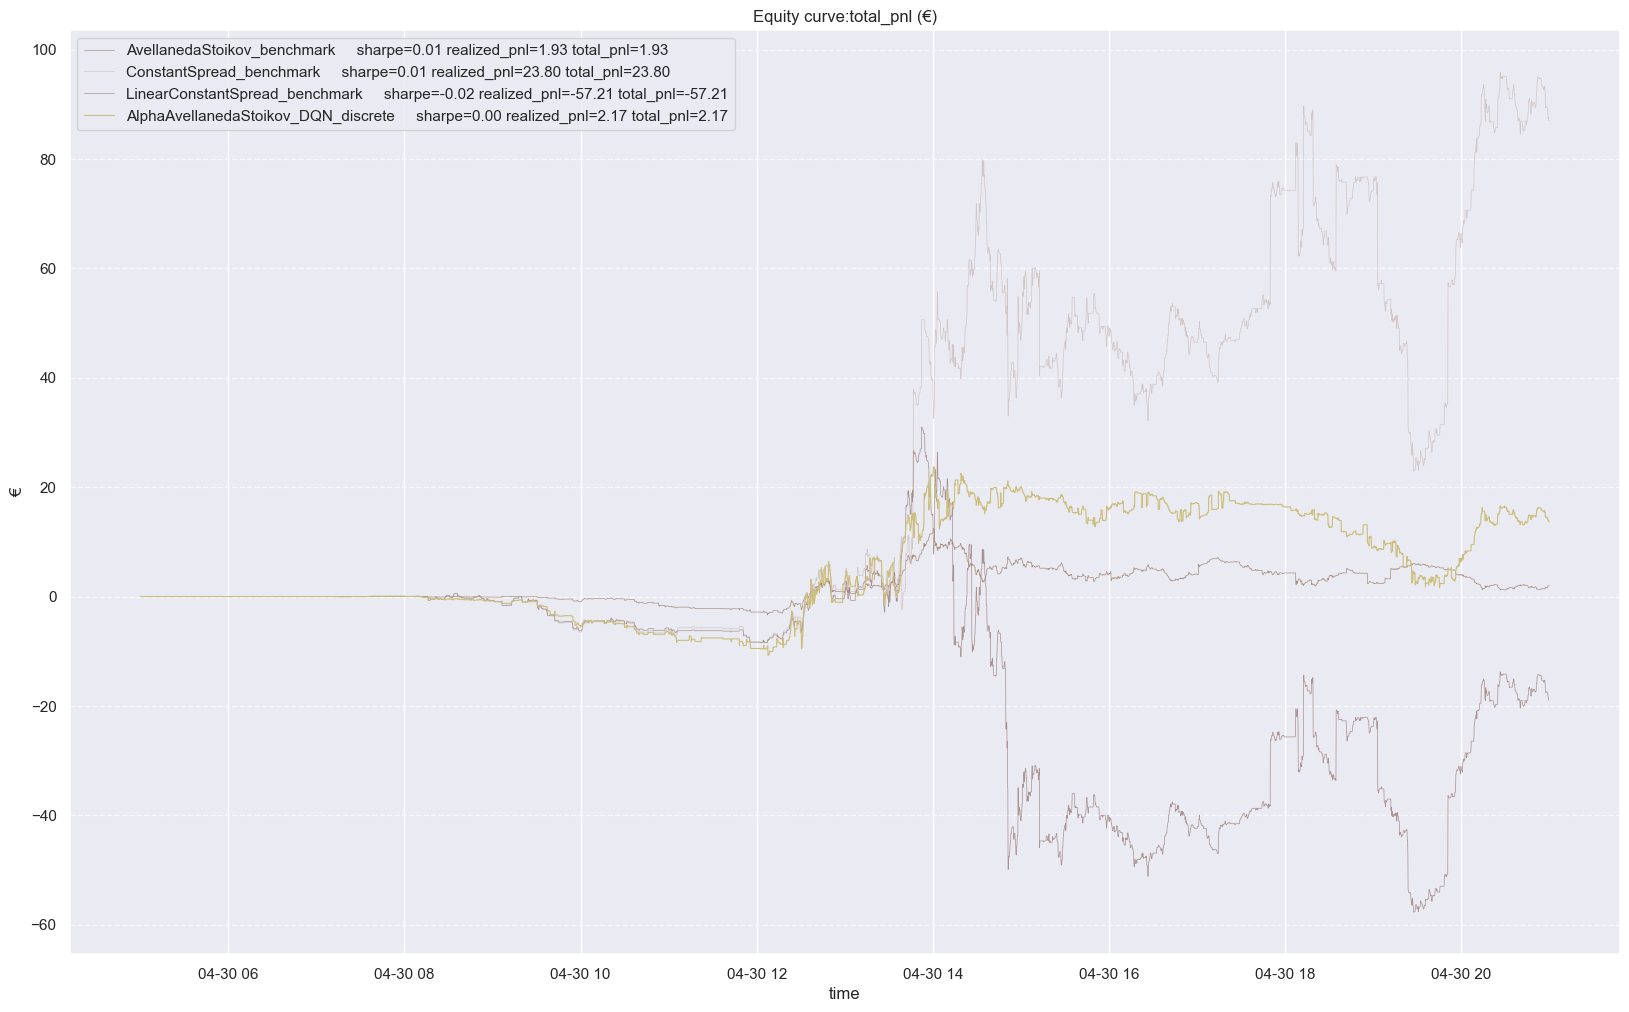

 93%|█████████████████████████████████████████████████████████████████████████▌     | 27/29 [1:53:21<08:54, 267.47s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaConstantSpread_PPO_

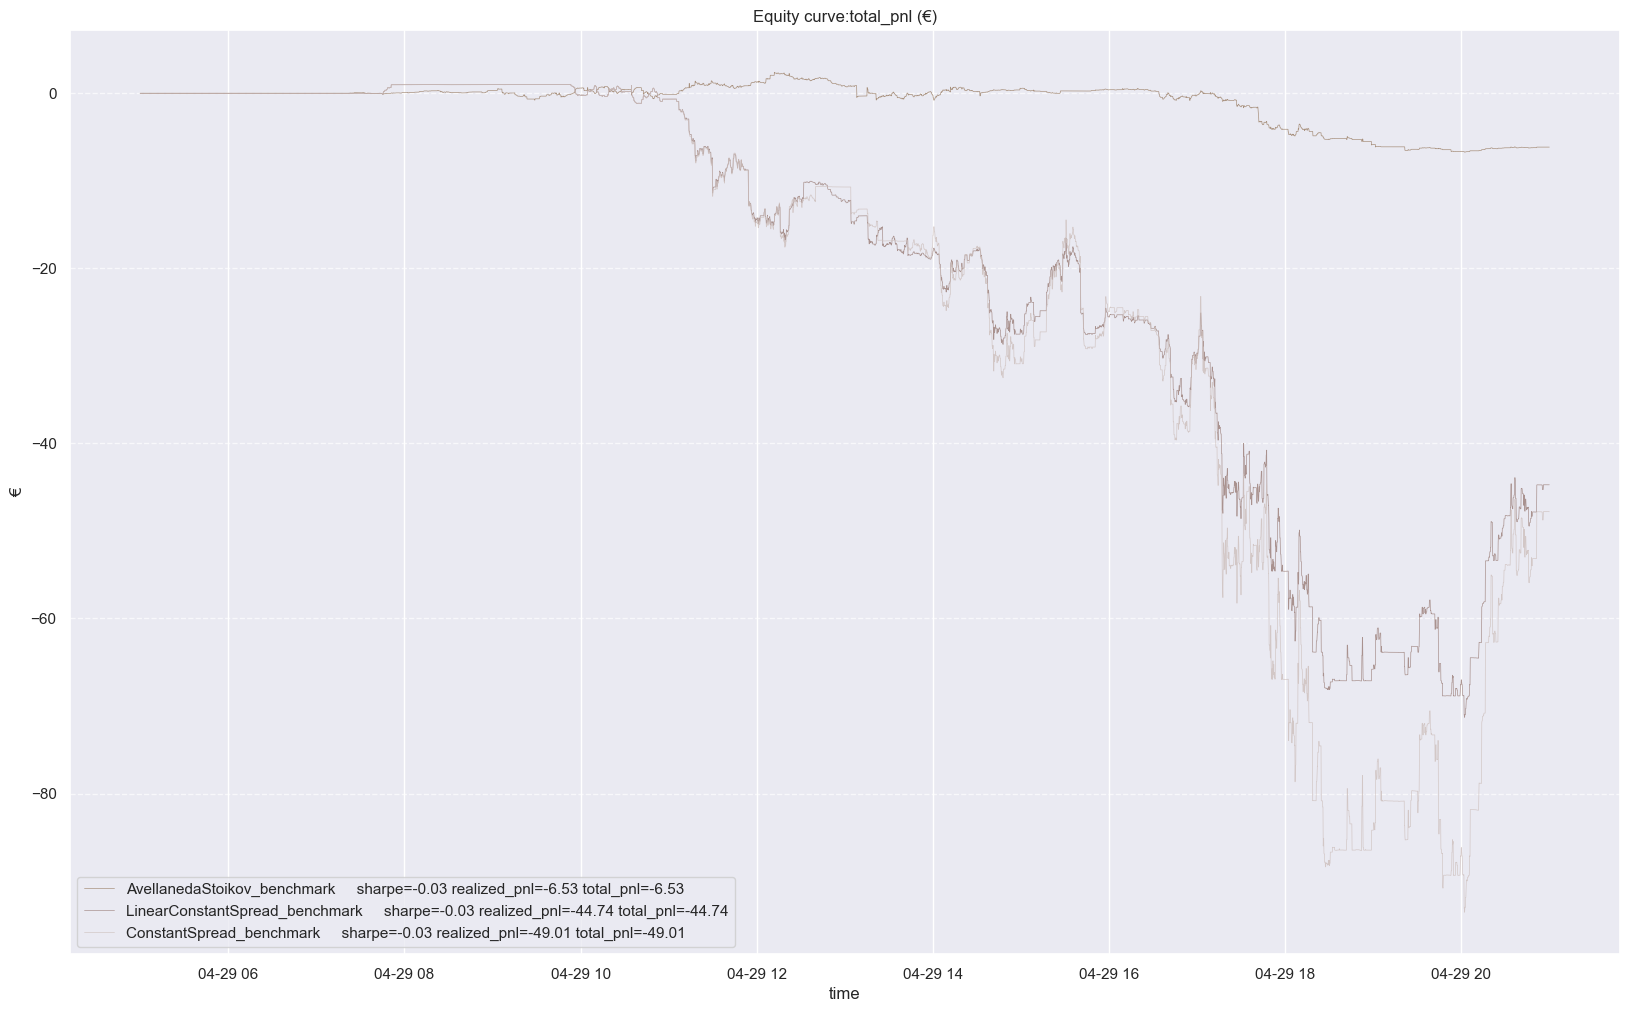

 97%|████████████████████████████████████████████████████████████████████████████▎  | 28/29 [1:57:12<04:16, 256.41s/it]

pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
pwd=E:\javif\Coding\Python\market_making_fw\python_lambda\notebooks
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_DQN_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaConstantSpread_PPO_discrete/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_PPO_continuous/normalizer_model.pkl...
Loading normalize training: False model from X:\output_models/AlphaAvellanedaStoikov_DQN_discrete/normalizer_model.pkl...
Loading existing model from X:\output_models/AlphaAvellanedaStoikov_P

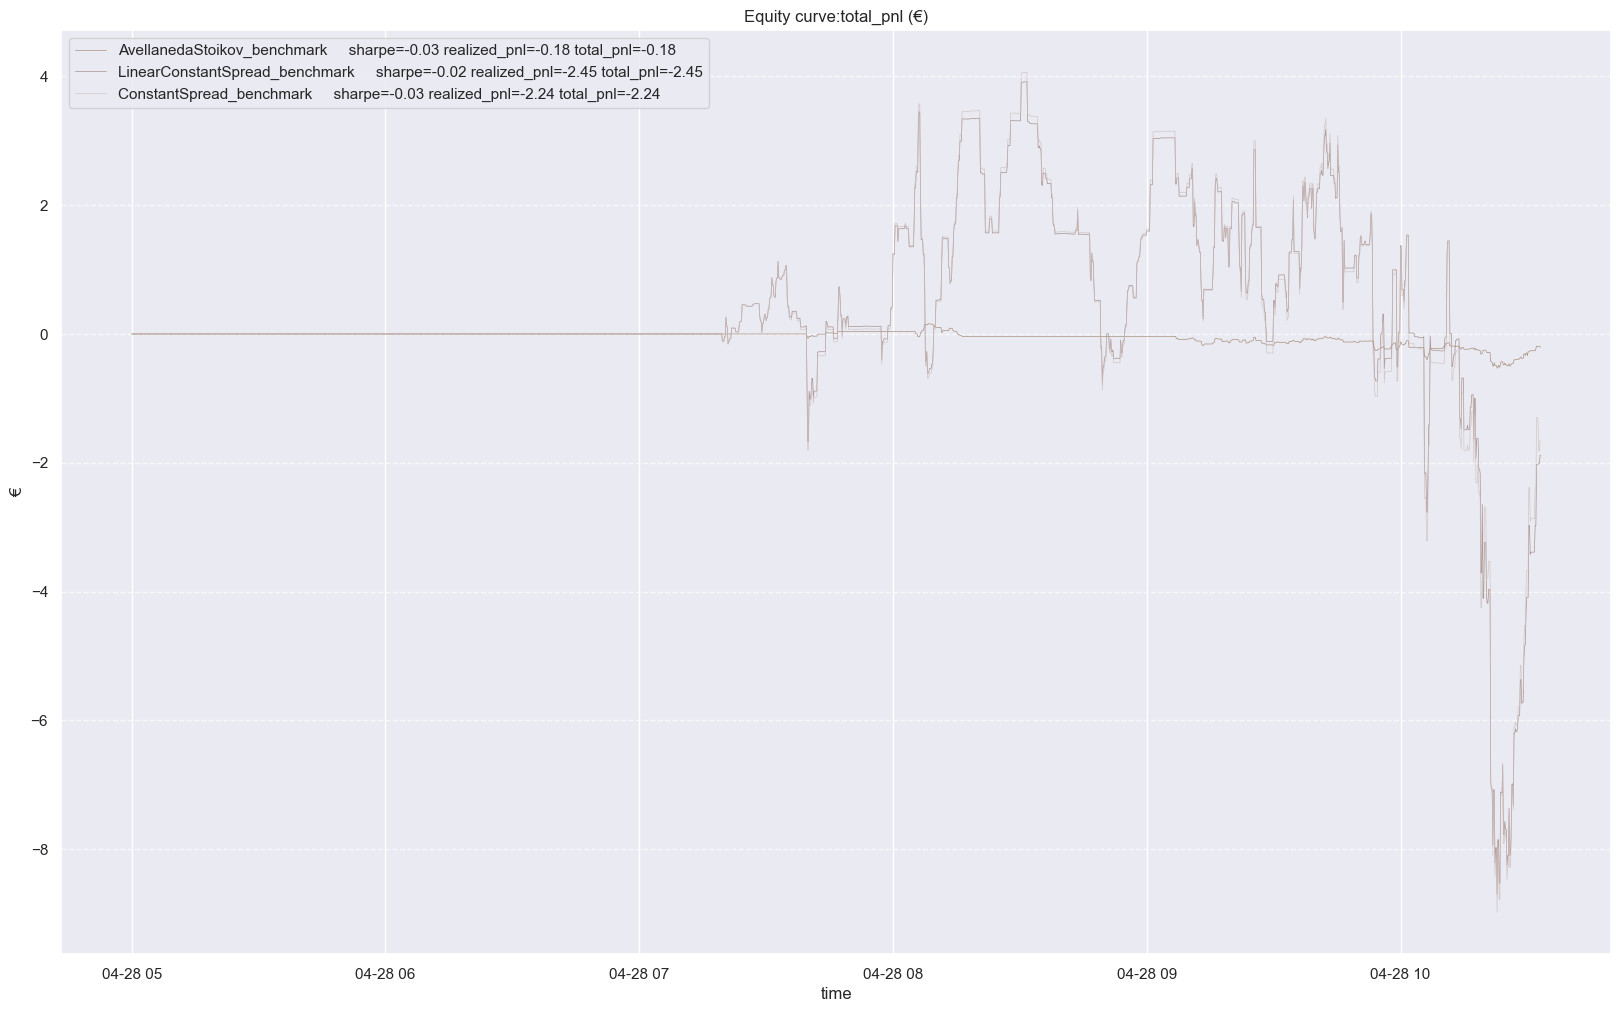

100%|███████████████████████████████████████████████████████████████████████████████| 29/29 [1:59:15<00:00, 246.74s/it]

test of 29 days 9 algorithms finished in 119.26 minutes


In [23]:
if TESTING:
    max_simultaneous = -2
    start=time.time()
    if DEBUG:
        print("DEBUG")
        max_simultaneous = 2

    print(rf"testing {len(days_backtest)} days")


    equity_column_score=ScoreEnum.total_pnl

    compare_trading_statistically = CompareStatisticallyTradingAlgorithms()


    for test_day in tqdm.tqdm(days_backtest):
        compare_trading = CompareTradingAlgorithms.get_instance(algorithms_list=algorithms_list,
                                                                 instrument_pk=instrument_pk,
                                                                 start_date=test_day+ datetime.timedelta(hours=int(FIRST_HOUR-2)),
                                                                 end_date=test_day+ datetime.timedelta(hours=int(LAST_HOUR+2)),
                                                                 benchmark_algorithms=algorithms_benchmark,
                                                                 
                                                                max_simultaneous = max_simultaneous
                                                               )
        compare_trading_results = compare_trading.get_results(equity_column_score_enum=equity_column_score)
        compare_trading_statistically.add_results_compare(compare_trading_results)
        df,fig = compare_trading.plot_equity_curve(plot_equity_column_score_enum=equity_column_score)
        

    elapsed=time.time()-start
    print('test of %d days %d algorithms finished in %.2f minutes'%(len(days_backtest),len(algorithms_list),elapsed/60))

    compare_trading_statistically.save(NAME)

## Results  <a class="anchor" id="results"></a>

In [24]:
compare_trading_statistically = CompareStatisticallyTradingAlgorithms.load(NAME)
# compare_trading_statistically.results_compare_dict

### Ratios <a class="anchor" id="ratios"></a>

In [25]:
ratios = [ScoreEnum.sharpe,ScoreEnum.sortino,ScoreEnum.max_dd,ScoreEnum.pnl_to_map]
algorithm_info_color=None

# algorithm_info_color={}
# for benchmark_algo in algorithms_benchmark: 
#     algorithm_info_color[benchmark_algo.algorithm_info] = 'red'

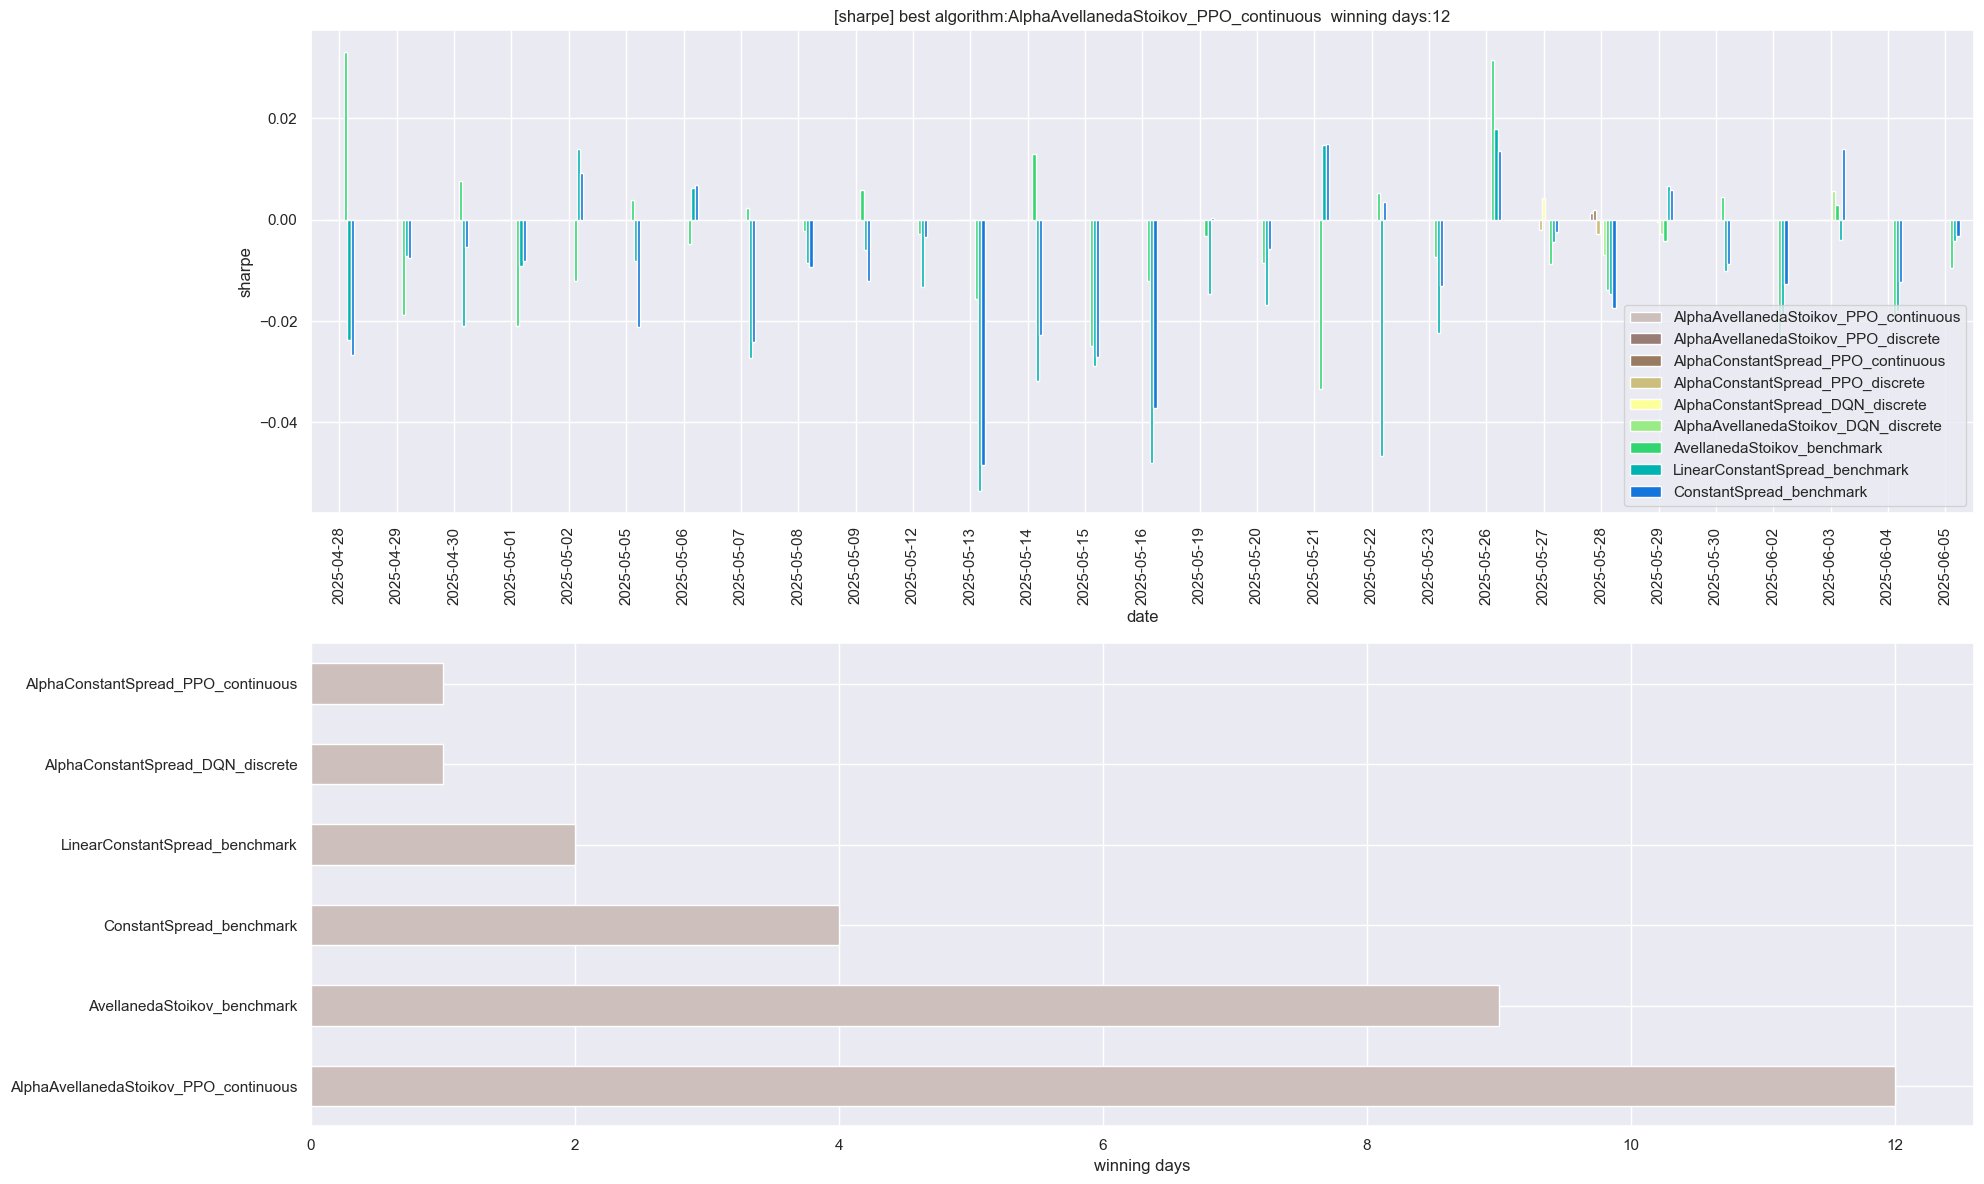

---------
sharpe score kruskal_wallis 
H(9)_sharpe = 57.47  p_value=5.02e-11

sharpe score mann_whitney vs ConstantSpread_benchmark 
AlphaAvellanedaStoikov_PPO_continuous    U = 609.0  p_value=6.12e-05 r=-0.59 
AlphaAvellanedaStoikov_PPO_discrete      U = 610.0  p_value=6.24e-05 r=-0.59 
AlphaConstantSpread_PPO_continuous       U = 610.0  p_value=6.24e-05 r=-0.59 
AlphaConstantSpread_PPO_discrete         U = 608.0  p_value=7.93e-05 r=-0.58 
AlphaConstantSpread_DQN_discrete         U = 611.0  p_value=6.73e-05 r=-0.60 
AlphaAvellanedaStoikov_DQN_discrete      U = 605.0  p_value=9.32e-05 r=-0.58 
AvellanedaStoikov_benchmark              U = 468.0  p_value=1.60e-02 r=-0.20 
LinearConstantSpread_benchmark            U = 344.0  p_value=8.18e-03 r=0.21 

sharpe score mann_whitney vs LinearConstantSpread_benchmark 
AlphaAvellanedaStoikov_PPO_continuous    U = 696.0  p_value=1.67e-07 r=-0.78 
AlphaAvellanedaStoikov_PPO_discrete      U = 696.0  p_value=1.95e-07 r=-0.79 
AlphaConstantSpread_PPO_c

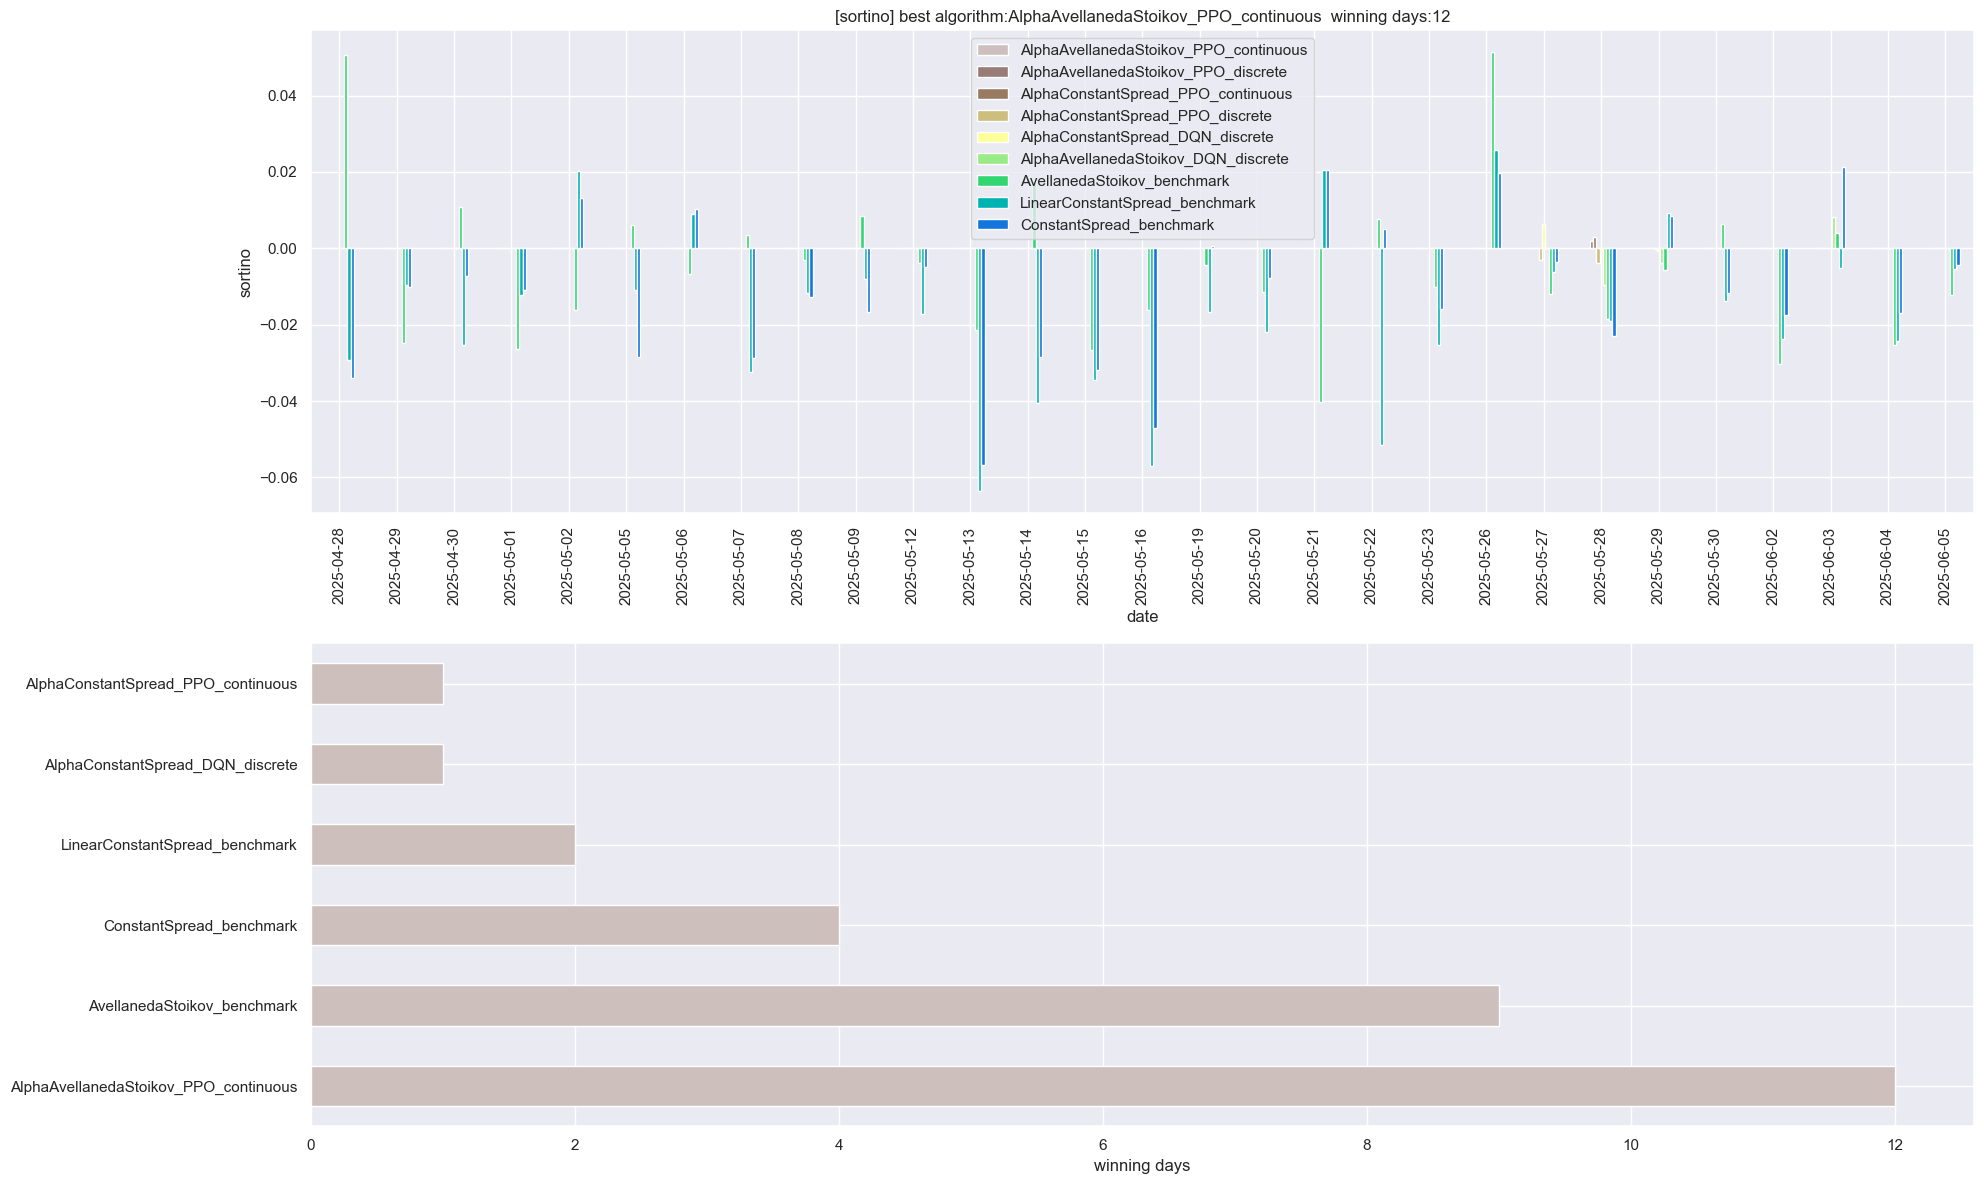

---------
sortino score kruskal_wallis 
H(9)_sortino = 57.43  p_value=5.11e-11

sortino score mann_whitney vs ConstantSpread_benchmark 
AlphaAvellanedaStoikov_PPO_continuous    U = 609.0  p_value=6.12e-05 r=-0.57 
AlphaAvellanedaStoikov_PPO_discrete      U = 610.0  p_value=6.24e-05 r=-0.57 
AlphaConstantSpread_PPO_continuous       U = 610.0  p_value=6.24e-05 r=-0.57 
AlphaConstantSpread_PPO_discrete         U = 608.0  p_value=7.93e-05 r=-0.56 
AlphaConstantSpread_DQN_discrete         U = 611.0  p_value=6.73e-05 r=-0.58 
AlphaAvellanedaStoikov_DQN_discrete      U = 605.0  p_value=9.32e-05 r=-0.55 
AvellanedaStoikov_benchmark              U = 469.0  p_value=1.57e-02 r=-0.21 
LinearConstantSpread_benchmark            U = 346.0  p_value=8.61e-03 r=0.19 

sortino score mann_whitney vs LinearConstantSpread_benchmark 
AlphaAvellanedaStoikov_PPO_continuous    U = 696.0  p_value=1.67e-07 r=-0.77 
AlphaAvellanedaStoikov_PPO_discrete      U = 696.0  p_value=1.95e-07 r=-0.77 
AlphaConstantSpread_P

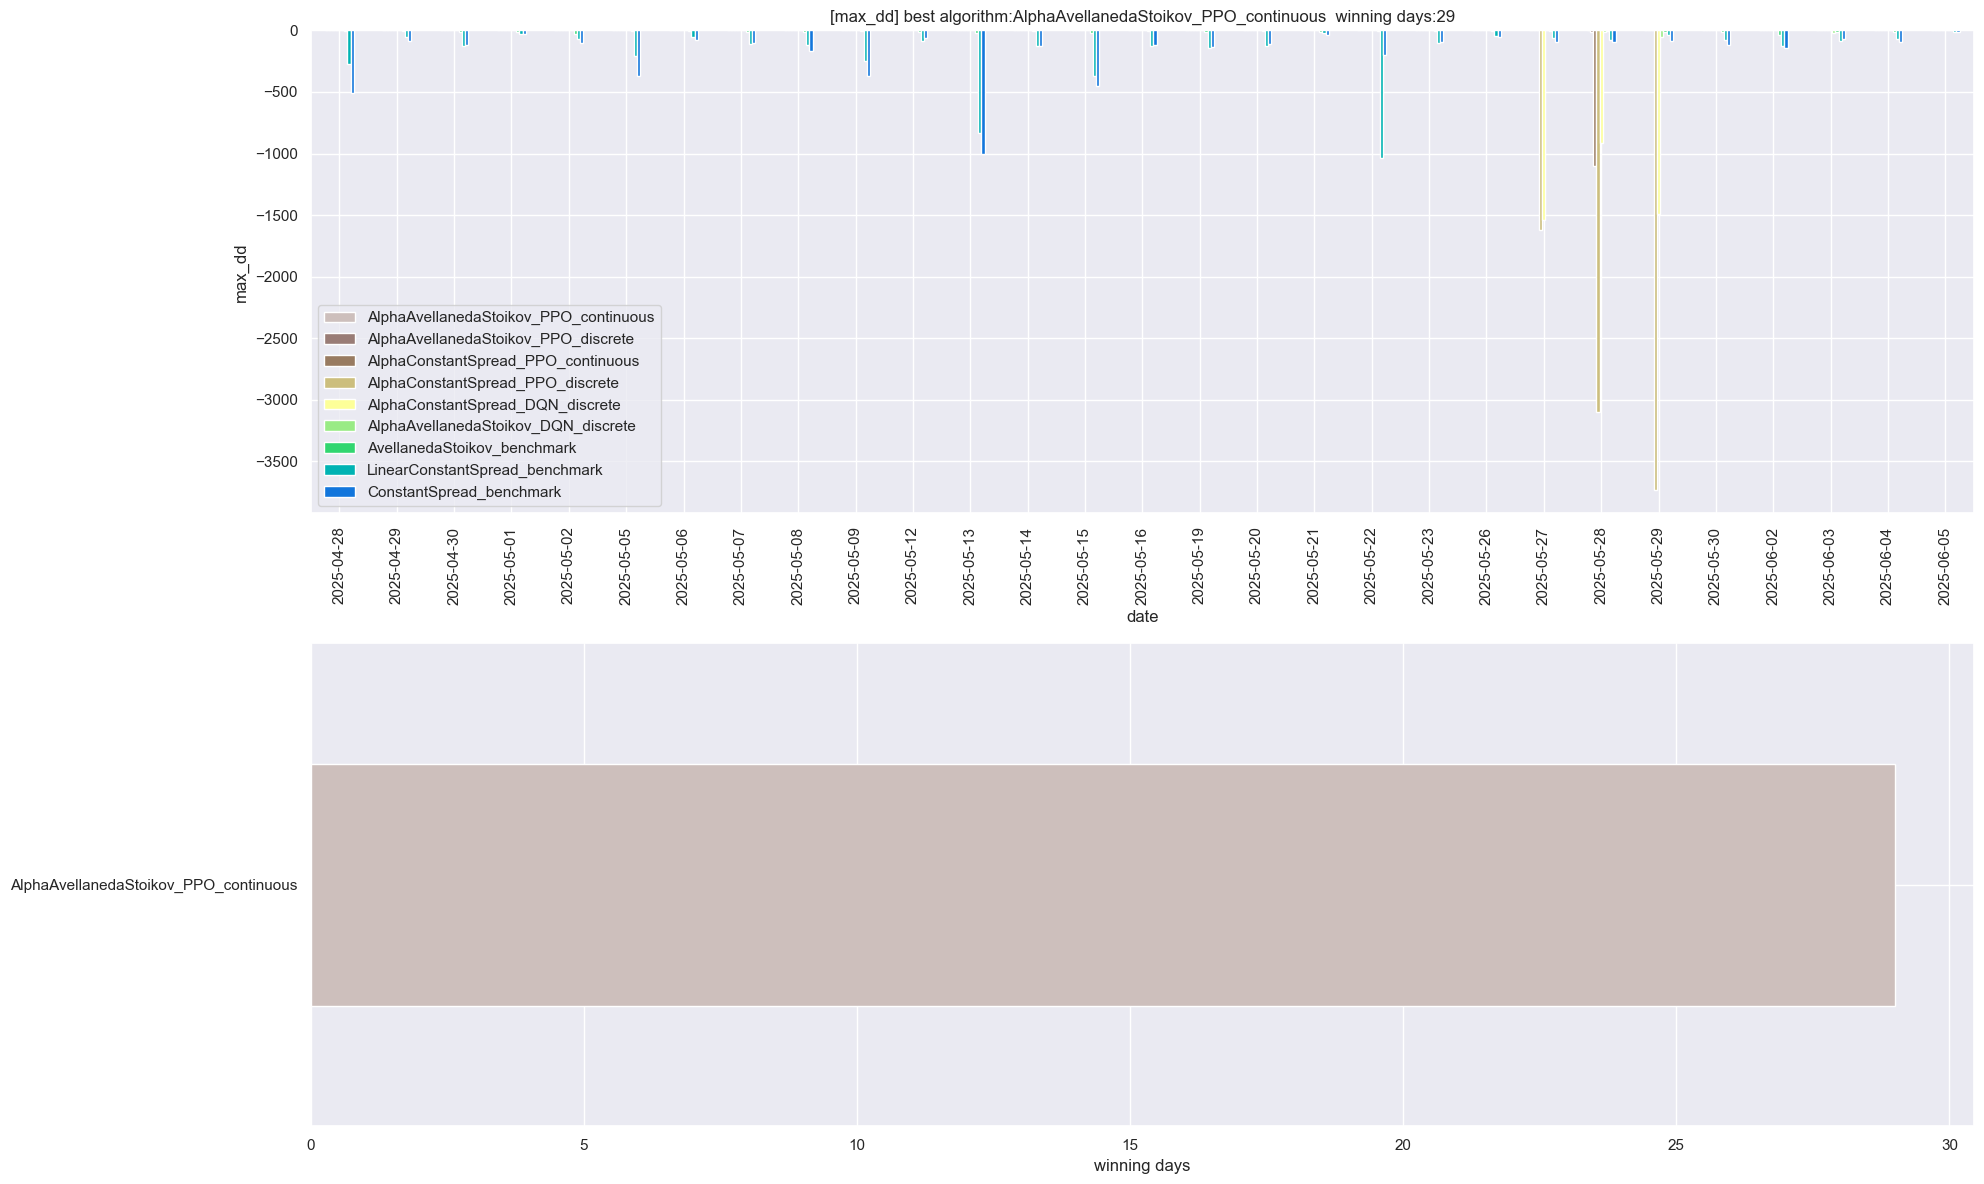

---------
max_dd score kruskal_wallis 
H(9)_max_dd = 199.51  p_value=2.80e-40

max_dd score mann_whitney vs ConstantSpread_benchmark 
AlphaAvellanedaStoikov_PPO_continuous    U = 841.0  p_value=1.00e-13 r=-0.86 
AlphaAvellanedaStoikov_PPO_discrete      U = 841.0  p_value=1.42e-13 r=-0.85 
AlphaConstantSpread_PPO_continuous       U = 812.0  p_value=3.75e-12 r=-0.47 
AlphaConstantSpread_PPO_discrete          U = 754.0  p_value=1.96e-09 r=0.13 
AlphaConstantSpread_DQN_discrete         U = 755.0  p_value=1.79e-09 r=-0.08 
AlphaAvellanedaStoikov_DQN_discrete      U = 836.0  p_value=4.59e-13 r=-0.84 
AvellanedaStoikov_benchmark              U = 831.0  p_value=6.27e-12 r=-0.80 
LinearConstantSpread_benchmark           U = 456.0  p_value=2.02e-02 r=-0.02 

max_dd score mann_whitney vs LinearConstantSpread_benchmark 
AlphaAvellanedaStoikov_PPO_continuous    U = 841.0  p_value=1.00e-13 r=-0.73 
AlphaAvellanedaStoikov_PPO_discrete      U = 841.0  p_value=1.42e-13 r=-0.73 
AlphaConstantSpread_PPO_

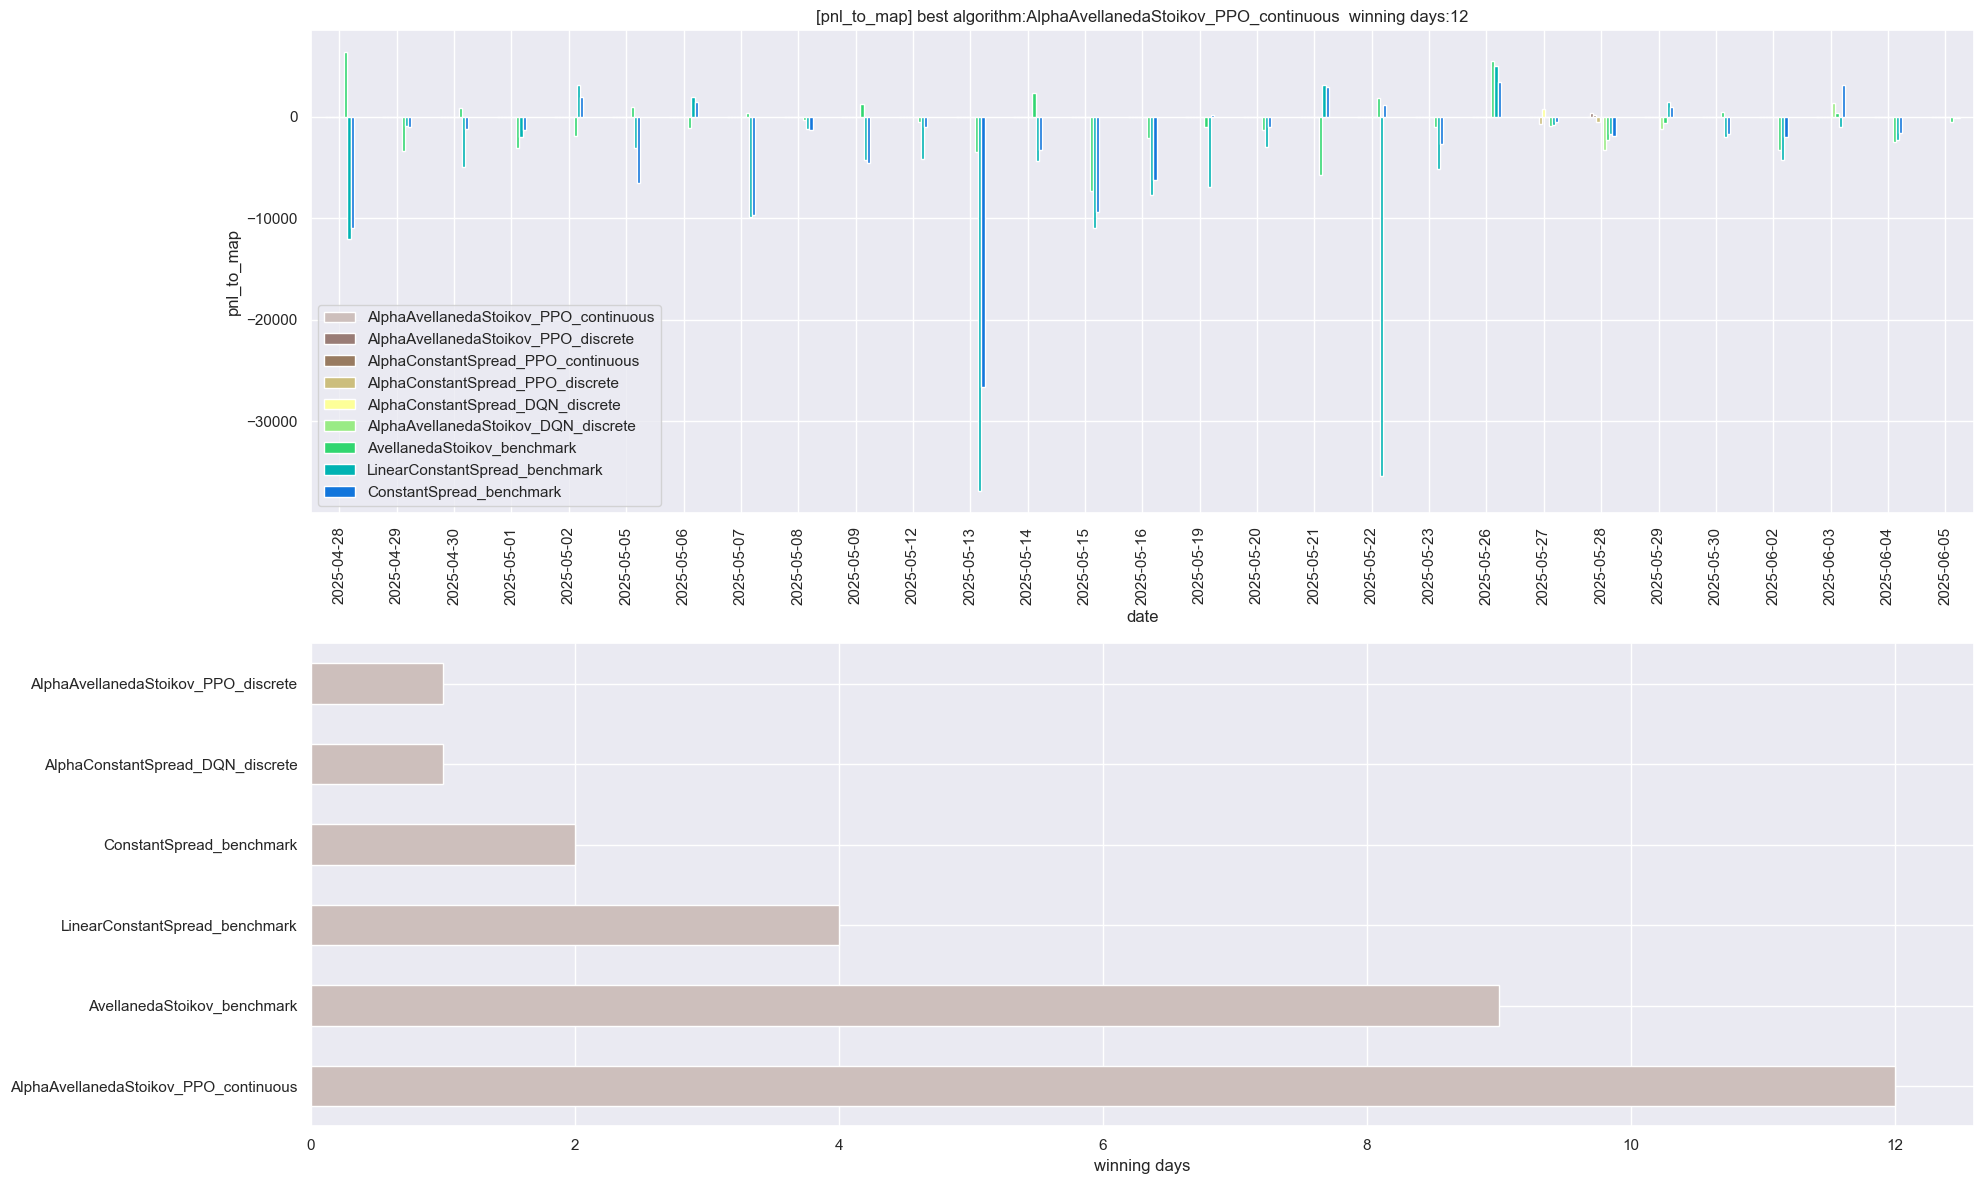

---------
pnl_to_map score kruskal_wallis 
H(9)_pnl_to_map = 57.21  p_value=5.64e-11

pnl_to_map score mann_whitney vs ConstantSpread_benchmark 
AlphaAvellanedaStoikov_PPO_continuous    U = 609.0  p_value=6.12e-05 r=-0.46 
AlphaAvellanedaStoikov_PPO_discrete      U = 610.0  p_value=6.24e-05 r=-0.46 
AlphaConstantSpread_PPO_continuous       U = 610.0  p_value=6.24e-05 r=-0.46 
AlphaConstantSpread_PPO_discrete         U = 605.0  p_value=9.32e-05 r=-0.45 
AlphaConstantSpread_DQN_discrete         U = 610.0  p_value=7.11e-05 r=-0.46 
AlphaAvellanedaStoikov_DQN_discrete      U = 592.0  p_value=1.83e-04 r=-0.44 
AvellanedaStoikov_benchmark              U = 479.0  p_value=1.27e-02 r=-0.30 
LinearConstantSpread_benchmark            U = 331.0  p_value=5.74e-03 r=0.22 

pnl_to_map score mann_whitney vs LinearConstantSpread_benchmark 
AlphaAvellanedaStoikov_PPO_continuous    U = 696.0  p_value=1.67e-07 r=-0.55 
AlphaAvellanedaStoikov_PPO_discrete      U = 696.0  p_value=1.95e-07 r=-0.55 
AlphaCons

In [26]:
ratios_dict={}
ratios_fig={}
for ratio in ratios:
    ratios_dict[ratio] = compare_trading_statistically.get_results_compare(score_enum=ratio)
    df_results , ratios_fig[ratio] = compare_trading_statistically.plot_results_compare(score_enum=ratio,algorithm_info_color=algorithm_info_color)
    print("---------")
    print(rf"{ratio} score kruskal_wallis ")
    compare_trading_statistically.get_kruskal_wallis(ratio)
    print("")
    for benchmark_algo in algorithms_benchmark: 
        print(rf"{ratio} score mann_whitney vs {benchmark_algo.algorithm_info} ")
        output_series = compare_trading_statistically.get_mann_whitney(ratio,benchmark_algo.algorithm_info)
        print(output_series.to_string())
        print("")

## Email  <a class="anchor" id="email"></a>

In [27]:
files_append = []
output_path = rf"{LAMBDA_TEMP_PATH}/notebooks/{NAME}"
if not os.path.exists(output_path):
    os.mkdir(path=output_path)
    
def save_ratios_fig():
    print(rf"save_ratios_fig in {output_path}")
    for ratio in ratios_fig.keys():
        fig = ratios_fig[ratio]
        file_path = rf"{output_path}/ratio_{ratio}.png"
        fig.savefig(file_path)
        files_append.append(file_path)
save_ratios_fig()

save_ratios_fig in E:\javif\Coding\Python\market_making_fw\java\temp/notebooks/AlphaAvellanedaStoikov


In [28]:
elapsed_notebook=time.time()-start_notebook
print(rf'Notebook HEDGE:{HEDGE} DEBUG:{DEBUG} PARAMETER_TUNING:{PARAMETER_TUNING} TRAINING:{TRAINING} TESTING:{TESTING} %d days and %d algorithms in %.2f minutes'%(len(days_backtest),len(algorithms_list),elapsed_notebook/60))

today_str = datetime.datetime.today().strftime('%Y%m%d')
if not DEBUG:
    save_ratios_fig()    
    send_email(recipient='javifalces@gmail.com',subject=f'[{today_str}]{NAME} finished ',body='',file_append=files_append)

Notebook HEDGE:True DEBUG:False PARAMETER_TUNING:False TRAINING:True TESTING:True 29 days and 9 algorithms in 294.90 minutes
save_ratios_fig in E:\javif\Coding\Python\market_making_fw\java\temp/notebooks/AlphaAvellanedaStoikov
adding file E:\javif\Coding\Python\market_making_fw\java\temp/notebooks/AlphaAvellanedaStoikov/ratio_sharpe.png
adding file E:\javif\Coding\Python\market_making_fw\java\temp/notebooks/AlphaAvellanedaStoikov/ratio_sortino.png
adding file E:\javif\Coding\Python\market_making_fw\java\temp/notebooks/AlphaAvellanedaStoikov/ratio_max_dd.png
adding file E:\javif\Coding\Python\market_making_fw\java\temp/notebooks/AlphaAvellanedaStoikov/ratio_pnl_to_map.png
adding file E:\javif\Coding\Python\market_making_fw\java\temp/notebooks/AlphaAvellanedaStoikov/ratio_sharpe.png
adding file E:\javif\Coding\Python\market_making_fw\java\temp/notebooks/AlphaAvellanedaStoikov/ratio_sortino.png
adding file E:\javif\Coding\Python\market_making_fw\java\temp/notebooks/AlphaAvellanedaStoikov/